### Imports and Paths

In [1]:
%matplotlib inline
import json
from importlib import reload
from dendropy import Tree
from dendropy.model import continuous, reconcile
import os
from functools import *
import random, string
from importlib import reload
from typing import Union
from Bio import Phylo
from io import StringIO
import operator
import re
from collections import Counter, defaultdict
from functools import *
from itertools import *
from multiprocessing.connection import wait
from pathlib import Path
from sys import argv

import dendropy
from dendropy.calculate import treecompare
import joblib  # import dump,load
import matplotlib.pyplot as plt
import numba as nb

# import msprime
import numpy as np
import pandas as pd
import seaborn as sns
from dendropy.simulate import treesim
from joblib import Parallel, delayed
from scipy import linalg, stats
from scipy.special import factorial, gammaln
from scipy.stats import multivariate_normal
from wrapt_timeout_decorator import timeout

from bd_functions import *
import re

rx = re.compile("\/l([\d.]+)\/m([\d.]+)\/")

nsims = 250
lam = 1
mus = np.arange(0.1, 1, 0.1)
heights = np.arange(1, 8, 0.5)
njobs = 24


parent_dir = Path("/N/project/phyloML/rate_timescaling/data/tree_sims")
parent_dir = Path("/N/project/phyloML/rate_timescaling/data")
if not parent_dir.exists():
    parent_dir = Path("/home/b/rate_timescaling/tree_sims")
figdir = parent_dir.parent / "figures"

# mu=.8
# tree_height=9

n_parent_trees = 100
njobs = 12
n_genes = [5, 10, 25, 50]

! pwd
! ls


/N/project/phyloML/rate_timescaling
 bd_corr.pd.gz
 bd_covs_deep_150.pd.gz
 bd_covs_deep_250.pd.gz
 bd_covs_deep_300.pd.gz
 bd_functions.py
 bd_simulate.py
 bd_sizes_deep_200.pd.gz
 bd_trees_200.pd.gz
 bd_trees.pd.gz
'Bias and Variance of sigma estimators.ipynb'
'Birth Death Trees.ipynb'
 calc_js.pbs
 calculate_dpy.py
 calculate_js.py
 calculate_pic_var.py
 calc_var.nb
 calc_var.pbs
 count_cherries.ipynb
 cov.py
 data
 evorates
 evorates_6658216.txt
 feature_importances
 figures
 fit_errors.py
 full_exp.txt
 js_6660754.txt
 map.txt
 pic_simple.old.pkl
 pic_v_6balanced_terms.expectation.str.txt
 pic_v_6balanced_terms.old.txt
 pic_v_6balanced_terms.txt
 pic_v.txt.gz
 __pycache__
 README.md
 run_xgb.sh
 simplify_pic_var_2.py
 simplify_pic_var.py
 simplify_pic_var_str.py
 sim_trait_figure.py
 simulate.py
 simulation
 test_contrast.py
 tree_topologies.nw


## Compute branch length distribution
Constraining the number of extant tips, the median branch length varies with $\lambda$ and $\mu/\lambda$:

In [2]:
# sns.relplot(
#     data=results.drop(columns=['std', 'max', 'mean']).stack().reset_index().rename(
#     columns={"level_2": "stat", 0: "value"}
# ),
#     x="mu",
#     col="stat",
#     y="value",
#     values="stat",
#     kind="heatmap",
#             # hue="lam",
#     # palette=sns.color_palette("viridis", N),
# )



df = (results
      # .query('lam>6')
      .rename(columns={'q1':r'25\% Quantile','mean':'Mean','median':'Median', 'q1':r'75\% Quantile'})
      .stack()
      .reset_index()
      .rename(columns={"level_2": "stat", 0: "value"})
     )

df.query('stat=="min"').pivot(columns="mu", index="lam", values="value")
g = sns.FacetGrid(df, row="stat")
g.map_dataframe(
    lambda data, color: sns.heatmap(
        data.pivot(columns="mu", index="lam", values="value"), 
        linewidths=0,
        # xticklabels=False,
        # yticklabels=False
    )
)
g.set_axis_labels(r"$\mu$", r"$\lambda$")
g.set_titles(row_template="{row_name}")

xlim,ylim= (df.mu.min(),df.mu.max()), (df.lam.min(),df.lam.max())
# g.set(xticks=xlim,
#      yticks=ylim,
#       xlim=xlim,
#       ylim=ylim
#      )
print(xlim,ylim)
plt.savefig('bl_dist.png')

plt.show()
# results.drop(columns=['std', 'max', 'mean']).stack().reset_index()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/N/project/phyloML/app/Quartz/miniconda3/envs/p311/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3672, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1490872/2215361763.py", line 16, in <module>
    df = (results
          ^^^^^^^
NameError: name 'results' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/N/project/phyloML/app/Quartz/miniconda3/envs/p311/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2178, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/N/project/phyloML/app/Quartz/miniconda3/envs/p311/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1182, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/N/project/phyl

In [ ]:
@timeout(TIMEOUT)
def simulate_traits(
    n_genes: list,
    data_dir: Path,
    sigmas: list=None,
    nsamps=100,
    njobs=24,
    overwrite=False,
):
    """Input: sigmas: #ngenes x #parent_trees x ntaxa x ntaxa.
    NOTE: values in n_genes list should match ngenes parameter used to generate sigmas list"""
    for g, sig in zip(n_genes, sigmas):
        try:
            if overwrite:
                raise FileNotFoundError
            samples = list(np.load(data_dir / f"samples_ngenes{g}.npz").values())
        except FileNotFoundError:
#             pass a seed to to each job prevent parallel jobs from using the sames seed
            samples = Parallel(njobs)(
                delayed(multivariate_normal.rvs)(np.zeros(len(s)), s, nsamps, i)
                for i, s in enumerate(sig)
            )
            # samples={f'n{n}':s for n,s in zip(sig,samples)}
            np.savez(data_dir / f"samples_ngenes{g}.npz", *samples)
            print(f"simulated {g}-gene  traits to {data_dir}")
    return samples


def get_median_bl(lam, mu):
    t = treesim.birth_death_tree(birth_rate=lam, death_rate=mu, num_extant_tips=20)
    x = [n.edge.length for n in t.internal_nodes()]
    return np.median(x)


def get_bl_stats(t:dendropy.Tree):
    """ignore zero-length edges."""
    x = np.array([n.edge.length for n in t.internal_nodes() if n.edge.length > 0])
    quantiles = [0,0.25, 0.5, 0.75,1]
    q_names = ["min", "q1", "median", "q3", "max"]
    qs ={ 
        k:v for k,v in zip(q_names, np.quantile(x,quantiles,method="inverted_cdf"))}
    return {
        "mean": x.mean(),
        "std": x.std(),
        **qs
    }

In [ ]:
e = 1
sig2=1
N=5000
# n_eps=500
# eps = np.linspace(0,5,n_eps)
xi = np.linspace(-5, 5,N)#np.random.randn(N,1)*e+x0
# c=np.random.randn(N,n_eps) * (eps+e) + x0
a,b,c = np.random.randn(3,N,1) * e * sig2

f = lambda xi,a,b,c: xi**2 - (a**2/2+b**2/2-c**2-a*c+b*c-3*a*b)

# plt.plot(eps,c.std(0))
y=f(xi,a,b,c)

# plt.hist(y.mean(0), bins=50);
# plt.plot(xi**2,(y<0).mean(0))
sns.set()
mean_1 = y.mean(0)
# std_1 = y.std(0)
b0,b1 = np.quantile(a = y, q = (.05,.95),  axis=0)
plt.plot(xi, mean_1, 'b-', label='argument')
plt.fill_between(xi, b0,b1, color='b', alpha=0.2);
print(std_1,b0)


In [ ]:
%%time

S = 100
N = 20

mus = np.linspace(1e-4, 1, 2*S)
lams = np.linspace(1, 10, S)

def sim_and_summarize(lam: float, mu: float):
    """simulate a tree and return summary statistics."""
    t = treesim.birth_death_tree(birth_rate=lam, death_rate=mu*lam, num_extant_tips=20)
    return {'lam':lam,'mu':mu*lam,**get_bl_stats(t)}

try:
    results = pd.read_pickle(parent_dir/"bl_stats.pd.gz")
    raise
except:
    with Parallel(njobs) as parallel:
        results = parallel(
            delayed(sim_and_summarize)(lam, mu) for lam in lams for mu in mus for rep in range(N)
        )
    results = pd.DataFrame(results)

    results['r']=results.lam-results.mu
    results = results.set_index(["lam", "mu"]).sort_index()
    results.to_pickle(parent_dir/"bl_stats.pd.gz")

    data=results.set_index('r').drop(columns='std').stack().reset_index().rename(
        columns={"level_1": "stat", 0: "value"}
    )


In [ ]:
results = pd.read_pickle(parent_dir/"bl_stats.pd.gz").groupby(['lam','mu']).mean()

### Compute MSE for cherry vs full PIC

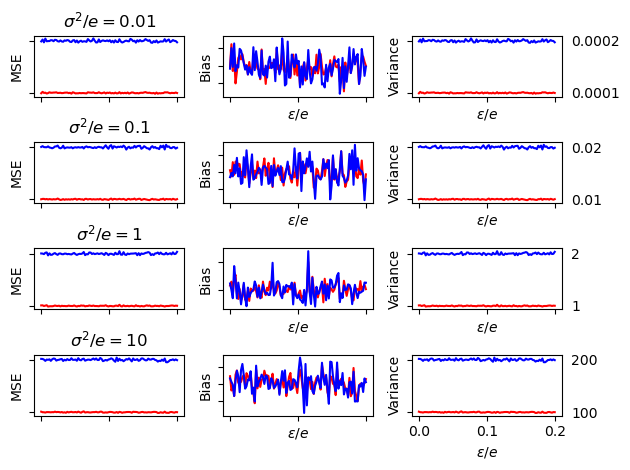

In [ ]:
from scipy import stats

x0=100
mu = np.repeat(x0,3)
e=1
r=[.01,.1,1,10]
j=1
for i, ratio in enumerate(r):
    sigsq = ratio*e
    eps=np.linspace(0,e/5,100)
    C = np.diag(3*[e])
    # C=np.expand_dims(C, -1)+np.expand_dims( np.eye(3), -1 )*eps
    m1,m2,m3=[],[],[]
    e1,e2,e3=[],[],[]
    v1,v2,v3=[],[],[]
    for ep in eps:
        c1 = lambda a,b,c: (a-b)**2 / (2*e)
        c2 = lambda a,b,c:  ((a+b)/2-c)**2 / (2*ep+3*e/2) 
        def f2(*args): return (c1(*args) + c2(*args)) / 2
        f1=c1
        cov = sigsq * (np.array(
            [[ep, ep, 0],
             [ep, ep, 0],
             [0, 0, ep]]) + C)
        
        abc = stats.multivariate_normal(mu, cov, allow_singular=True).rvs(200_000).T
        s_hat_1 = f1(*abc)
        s_hat_2 = f2(*abc)
        s_hat_3 = ( f1(*abc) + (f1(abc[0],abc[2],0)+f1(abc[1],abc[2],0)) * (2*e)/(2*e+ep) ) / 3
        m1.append(((s_hat_1-sigsq)**2).mean())
        m2.append(((s_hat_2-sigsq)**2).mean())
        m3.append(((s_hat_3-sigsq)**2).mean())
        s_hat_1_mean = s_hat_1.mean()
        s_hat_2_mean = s_hat_2.mean()
        s_hat_3_mean = s_hat_3.mean()
        e1.append(s_hat_1_mean-sigsq)
        e2.append(s_hat_2_mean-sigsq)
        e3.append(s_hat_3_mean-sigsq)
        v1.append(m1[-1] - e1[-1]**2)
        v2.append(m2[-1] - e2[-1]**2) # (s_hat_2**2).mean() - s_hat_2_mean**2
        v3.append(m3[-1] - e3[-1]**2) # (s_hat_2**2).mean() - s_hat_2_mean**2
    plt.subplot(len(r),3,j)
    plt.plot(eps,m2,'r',label=r'$\hat{\sigma}^2_2$');
    # plt.plot(eps,m3,'g',label=r'$\hat{\sigma}^2_3$')
    plt.plot(eps,m1,'b',label=r'$\hat{\sigma}^2_1$')

    plt.title(r'$\sigma^2/e=$'+str(ratio))
    # plt.xlabel(r'$\epsilon/e$')
    plt.ylabel('MSE')
    plt.tick_params(labelbottom=False, labelleft=False)
    j+=1
    plt.subplot(len(r), 3, j)
    plt.plot(eps,e2,'r',label=r'$\hat{\sigma}^2_2$');
    # plt.plot(eps,e3,'g',label=r'$\hat{\sigma}^2_3$');
    plt.plot(eps,e1,'b',label=r'$\hat{\sigma}^2_1$')
    # plt.title(r'$\sigma^2/e=$'+str(ratio))
    plt.xlabel(r'$\epsilon/e$')
    plt.ylabel('Bias')
    # if i>0:
    plt.tick_params(labelbottom=False, labelleft=False)
    j+=1
    plt.subplot(len(r), 3, j)
    plt.plot(eps,v2,'r',label=r'$\hat{\sigma}^2_2$');
    # plt.plot(eps,v3,'g',label=r'$\hat{\sigma}^2_3$');
    plt.plot(eps,v1,'b',label=r'$\hat{\sigma}^2_1$')
    # plt.title(r'$\sigma^2/e=$'+str(ratio))
    plt.xlabel(r'$\epsilon/e$')
    plt.ylabel('Variance')
    # if i>0:
    plt.tick_params(labelbottom=False, labelleft=False, labelright=True)
    j+=1
plt.tick_params(labelbottom=True)

# plt.legend()
plt.tight_layout();
plt.savefig('figures/mse_ABC_full_vs_cherries.png')

In [ ]:
# Import the necessary modules from SymPy
from sympy import symbols, simplify, factor, expand

# Define the symbols used in the expression
# 'a', 'b', 'c', 'd' are general variables.
# 'e', 'eps' (epsilon), 'delta' are also variables, often representing small quantities or parameters.
a, b, c, d, e, epsilon, delta, sigma, xr = symbols('a b c d e epsilon delta sigma xr')

# Define the given mathematical expression
# The expression is broken down into three main terms for clarity,
# then summed together.

expectations = {
    a**3*b:3*(e+epsilon+delta)*(epsilon+delta),
    b**3*a:3*(e+epsilon+delta)*(epsilon+delta),

    a**3*c:3*(e+epsilon+delta)*(delta),
    b**3*c:3*(e+epsilon+delta)*(delta),
    c**3*a:3*(e+epsilon+delta)*(delta),
    c**3*a:3*(e+epsilon+delta)*(delta),

    c**3*d:0,a**3*d:0,b**3*d:0,a**3*c:0,d**3*a:0,

    a**4:3*(e+epsilon+delta)**2,
    b**4:3*(e+epsilon+delta)**2,
    c**4:3*(e+epsilon+delta)**2,
    d**4:3*(e+epsilon+delta)**2,

    a**2*b**2:(e+epsilon+delta)**2 + 2*(epsilon+delta)**2,
    a**2*c**2:(e+epsilon+delta)**2 + 2*(delta)**2,
    b**2*c**2:(e+epsilon+delta)**2 + 2*(delta)**2,
    

    c**2*d**2:(e+epsilon+delta)**2,
    a**2*d**2:(e+epsilon+delta)**2,
    b**2*d**2:(e+epsilon+delta)**2,
    
    a**2*b*c:delta*(3*epsilon+3*delta+e),
    b**2*a*c:delta*(3*epsilon+3*delta+e),
    c**2*b*a:(delta+epsilon)*(epsilon+delta+e)+2*delta**2,
    a**2*b*d:0, b**2*a*d:0, c**2*b*d:0, c**2*a*d:0, a**2*c*d:0, b**2*c*d:0,
    
    d**2*c*a:(delta)*(epsilon+delta+e),
    d**2*c*b:(delta)*(epsilon+delta+e),
    
    d**2*b*a:(epsilon+delta)*(epsilon+delta+e),
    
    a*b*c*d:0
    
}

cherry = ((a - b)**2 / (2 * e) - sigma**2)**2
cherry_s = expand(cherry).subs(expectations)
#     {
#          a**4:xr**4+6*xr**2*sigma**2*(e+eps+delta) + 3 * (sigma**2*(e+eps+delta))**2,
#          b**4:xr**4+6*xr**2*sigma**2*(e+eps+delta) + 3 * (sigma**2*(e+eps+delta))**2,
#          a**2*b**2: xr**4+xr**2*2*(3*eps+3*delta+e)+(eps+delta)**2*3+2*e*(eps+delta)+eps**2,
#          a**3*b:xr**4+6*xr**2*(eps+delta)+3*xr**2*e+3*(eps+delta)**2+3*e*(eps+delta),
#          b**3*a:xr**4+6*xr**2*(eps+delta)+3*xr**2*e+3*(eps+delta)**2+3*e*(eps+delta),
#      }).subs(
#          {
#              a**2:sigma**2*(e+eps+delta)+xr**2,
#      b**2:sigma**2*(e+eps+delta)+xr**2,
#      a*b:sigma**2*(eps+delta)+xr**2,
#          }
#      ).subs({
#     xr:0,
# })

print('cherry factored:',factor(cherry_s),
      '\n---\n e=eps:',
      factor(expand(cherry_s).subs({epsilon:1,e:1})),) 

# exit()
pair_s = (((a - b)**2 / (2 * e) + \
             ((a - c)**2 + (b - c)**2) / (2 * (e + epsilon)) + \
             ((a - d)**2 + (b - d)**2 + (c - d)**2) / (2 * (e + epsilon + delta)))/6 - sigma**2)**2

# Print the original expression to see it before simplification
# print("Original Expression:")
# print(pic)
print("\n" + "="*30 + "\n") # Separator for better readability

# Simplify the expression using sympy's simplify function
# The simplify function attempts to transform the expression into a simpler form.


pair_s = expand(simplify(pair_s)).subs(expectations)
        
        # a**4:xr**4+6*xr**2*sigma**2*(e+eps+delta) + 3 * (sigma**2*(e+eps+delta))**2,
        #  b**4:xr**4+6*xr**2*sigma**2*(e+eps+delta) + 3 * (sigma**2*(e+eps+delta))**2,
        #  a**2*b**2: xr**4+xr**2*2*(3*eps+3*delta+e)+(eps+delta)**2*3+2*e*(eps+delta)+eps**2,
        #  a**3*b:xr**4+6*xr**2*(eps+delta)+3*xr**2*e+3*(eps+delta)**2+3*e*(eps+delta),
        #  b**3*a:xr**4+6*xr**2*(eps+delta)+3*xr**2*e+3*(eps+delta)**2+3*e*(eps+delta),
#     ).subs({
#              a**2: sigma**2*(e+eps+delta)+xr**2,
#         b**2: sigma**2*(e+eps+delta)+xr**2,
#         c**2: sigma**2*(e+eps+delta)+xr**2,
#         d**2: sigma**2*(e+eps+delta)+xr**2,
#         a*b:sigma**2*(eps+delta)+xr**2,
#         a*c:sigma**2*delta+xr**2,
#         b*c:sigma**2*delta+xr**2,
#         d*c:sigma**2*delta+xr**2,
#         d*a:xr**2,d*b:xr**2,

#     }
# ).subs({
#     xr:0,
# })


# Print the simplified expression
# print("Simplified All Pairs:", simplified_pairs)
print("\n---\nMSE all pairs:",
      factor(simplify((pair_s))),
      '\n--\n e=eps',factor( expand(pair_s).subs({epsilon:1,e:1}))
     )

contrast = lambda a,b,e: (a-b)**2 / e
def f_full(a,b,c,d): 
    c1 = contrast(a,b,2*e)
    x1=(a+b) / 2
    v1 = (e/2 + epsilon)
    v2 = (e + epsilon)
    denom = v1+v2 #[:,np.newaxis] 
    # print(x1.shape,c.shape,denom.shape, ep.shape)
    c2 = contrast(x1, c, denom)
    x2 =( x1*v2 + c*v1 ) / denom 
    e_k = v2*v1 / denom 
    c3 = contrast(x2,d, 2*delta + epsilon + e + e_k)
    return (c1+c2+c3) / 3
    

pic_s = expand(simplify(
    ( (f_full(a,b,c,d) - sigma**2)**2 ))
).subs(expectations)

#         {
#             a**4:xr**4+6*xr**2*sigma**2*(e+eps+delta) + 3 * (sigma**2*(e+eps+delta))**2,
#      b**4:xr**4+6*xr**2*sigma**2*(e+eps+delta) + 3 * (sigma**2*(e+eps+delta))**2,
#      a**2*b**2: xr**4+xr**2*2*(3*eps+3*delta+e)+(eps+delta)**2*3+2*e*(eps+delta)+eps**2,
#      a**3*b:xr**4+6*xr**2*(eps+delta)+3*xr**2*e+3*(eps+delta)**2+3*e*(eps+delta),
#      b**3*a:xr**4+6*xr**2*(eps+delta)+3*xr**2*e+3*(eps+delta)**2+3*e*(eps+delta),
#     }
# ).subs(
#     {
#                 a**2: sigma**2*(e+eps+delta)+xr**2,
#         b**2: sigma**2*(e+eps+delta)+xr**2,
#         c**2: sigma**2*(e+eps+delta)+xr**2,
#         d**2: sigma**2*(e+eps+delta)+xr**2,
#         a*b:sigma**2*(eps+delta)+xr**2,
#         a*c:sigma**2*delta+xr**2,
#         b*c:sigma**2*delta+xr**2,
#         d*c:sigma**2*delta+xr**2,
#         d*a:xr**2,d*b:xr**2,
#     }).subs({
#                 a:xr,
#                 b:xr,
#                 c:xr,
#                 d:xr

#     }
# ).subs({
#     xr:0,
# })

print("\nMSE PIC:",factor(simplify(pic_s)),
      '\n--\n with e=eps: ',
      factor(expand(pic_s).subs({epsilon:1,e:1})))


See 
https://colab.research.google.com/drive/1VmmP-1bMHOnshgetAGlMd3-Q_-U2Gye5#scrollTo=X5aMyAcGXIUw
https://gemini.google.com/app/4363311ca99acccd?_gl=1*1gzyuy7*_ga*NTQyMzE3NjU3LjE3NTAxNzI3NzE.*_ga_WC57KJ50ZZ*czE3NTAxNzI3NzAkbzEkZzEkdDE3NTAxNzI4NDYkajU2JGwwJGgw


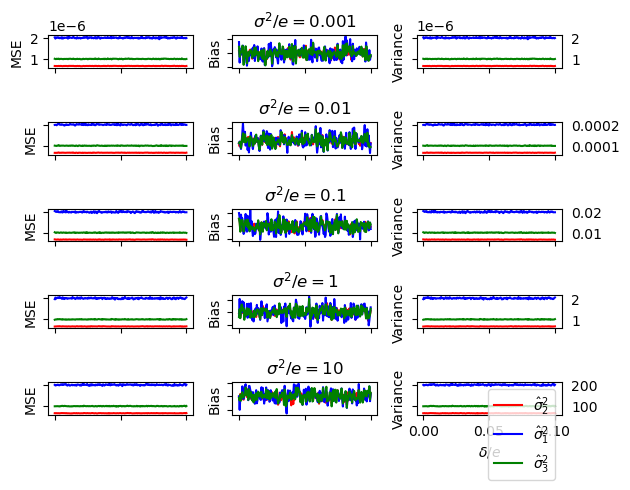

In [ ]:
from scipy import stats

x0=200
mu = np.repeat(x0,4)

e=.5
delta=1
ep=.2

r=[.001,.01,.1,1,10]
j=1
eps=np.linspace(0,e/5,200)

root_edge = np.ones(4) * 5.
C = np.diag(4*[e])

for i, ratio in enumerate(r):
    sigsq = ratio#*e
    # C=np.expand_dims(C, -1)+np.expand_dims( np.eye(3), -1 )*eps
    m1,m2,m3=[],[],[]
    e1,e2,e3=[],[],[]
    v1,v2,v3=[],[],[]
    for delta in eps:
        ep=delta
    # for ep in eps:
        # ep = ep[:,np.newaxis] 
        contrast = lambda a,b,e: (a-b)**2 / e

        
        # cov = sigsq * (np.array(
        #     [[2*ep, 2*ep, ep, 0],
        #      [2*ep, 2*ep, ep, 0],
        #      [ep, ep, 2*ep, 0],
        #      [0, 0, 0, 2*ep]]) + C)
        
#         uncomment
        # delta=ep
        cov = sigsq * (np.array(
            [[delta+ep, delta+ep, delta, 0],
             [delta+ep, delta+ep, delta, 0],
             [delta, delta, delta+ep, 0],
             [0, 0, 0, delta+ep]]) + C + root_edge)
        
        a,b,c,d = stats.multivariate_normal(mu, cov, allow_singular=True).rvs(100_000).T
        
        def f_paired_lineages(a,b,c,d):
            return (contrast(a,b,2*e) + contrast(c,d,2*(delta + ep + e)))/2
        
        
        def f_full(a,b,c,d): 
            c1 = contrast(a,b,2*e)
            x1=(a+b) / 2
            v1 = (e/2 + ep)
            v2 = (e + ep)
            denom = v1+v2 #[:,np.newaxis] 
            # print(x1.shape,c.shape,denom.shape, ep.shape)
            c2 = contrast(x1, c, denom)
            x2 =( x1*v2 + c*v1 ) / denom 
            e_k = v2*v1 / denom 
            c3 = contrast(x2,d, 2*delta + ep + e + e_k)
            return (c1+c2+c3) / 3
        
        def f_all_pairs(a,b,c,d):
            d_ac = 2*e+2*ep
            d_ad = 2*(delta + ep + e)
            return ( contrast(a,b,2*e) 
             + contrast(b,c,d_ac) 
             + contrast(a,c,d_ac) 
             + contrast(c,d,d_ad) 
             + contrast(a,d,d_ad) 
             + contrast(b,d,d_ad)) / 6
            
        s_hat_1 = contrast(a,b,2*e)
        s_hat_2 = f_full(a,b,c,d)
        # s_hat_3 = f_all_pairs(a,b,c,d)
        s_hat_3 = f_paired_lineages(a,b,c,d)
        # print(s_hat_1.shape, a.shape)
        m1.append(((s_hat_1-sigsq)**2).mean())
        m2.append(((s_hat_2-sigsq)**2).mean())
        m3.append(((s_hat_3-sigsq)**2).mean())
        s_hat_1_mean = s_hat_1.mean()
        s_hat_2_mean = s_hat_2.mean()
        s_hat_3_mean = s_hat_3.mean()
        e1.append(s_hat_1_mean-sigsq)
        e2.append(s_hat_2_mean-sigsq)
        e3.append(s_hat_3_mean-sigsq)
        v1.append(m1[-1] - e1[-1]**2)
        v2.append(m2[-1] - e2[-1]**2) # (s_hat_2**2).mean() - s_hat_2_mean**2
        v3.append(m3[-1] - e3[-1]**2) # (s_hat_2**2).mean() - s_hat_2_mean**2
    plt.subplot(len(r),3,j)
    plt.plot(eps,m2,'r',label=r'$\hat{\sigma}^2_2$');
    plt.plot(eps,m1,'b',label=r'$\hat{\sigma}^2_1$')
    plt.plot(eps,m3,'g',label=r'$\hat{\sigma}^2_3$')
    
    # plt.xlabel(r'$\epsilon/e$')
    plt.ylabel('MSE')
    if j==1:
        plt.tick_params(labelbottom=False, labelleft=True)
    else:
        plt.tick_params(labelbottom=False, labelleft=False)
    j+=1
    plt.subplot(len(r), 3, j)
    plt.title(r'$\sigma^2/e=$'+str(ratio))
    plt.plot(eps,e2,'r',label=r'$\hat{\sigma}^2_2$');
    plt.plot(eps,e1,'b',label=r'$\hat{\sigma}^2_1$')
    plt.plot(eps,e3,'g',label=r'$\hat{\sigma}^2_3$');
    # plt.title(r'$\sigma^2/e=$'+str(ratio))
    # plt.xlabel(r'$\epsilon/e$')
    plt.ylabel('Bias')
    # if i>0:
    plt.tick_params(labelbottom=False, labelleft=False)
    j+=1
    plt.subplot(len(r), 3, j)
    plt.plot(eps,v2,'r',label=r'$\hat{\sigma}^2_2$');
    plt.plot(eps,v1,'b',label=r'$\hat{\sigma}^2_1$')
    plt.plot(eps,v3,'g',label=r'$\hat{\sigma}^2_3$');
    # plt.title(r'$\sigma^2/e=$'+str(ratio))
    # plt.xlabel(r'$\epsilon/e$')
    plt.ylabel('Variance')
    # if i>0:
    plt.tick_params(labelbottom=False, labelleft=False, labelright=True)
    j+=1
plt.tick_params(labelbottom=True)
# plt.xlabel(r'$\epsilon/e$')
plt.xlabel(r'$\delta/e$')

plt.legend()
plt.tight_layout();
plt.savefig(f'figures/mse_ABCD_full_vs_cherries_vs_pairs_small_del_eps.png')

In [ ]:
from scipy import stats

x0=200
mu = np.repeat(x0,4)
e=1
delta=1
r=[.001,.01,.1,1,10]
j=1
eps=np.linspace(0,e/10,200)
C = np.diag(4*[e])

for i, ratio in enumerate(r):
    sigsq = ratio*e
    m1,m2,m3=[],[],[]
    e1,e2,e3=[],[],[]
    v1,v2,v3=[],[],[]
    for ep in eps:
        contrast = lambda a,b,e: (a-b)**2 / e

        
        # cov = sigsq * (np.array(
        #     [[2*ep, 2*ep, ep, 0],
        #      [2*ep, 2*ep, ep, 0],
        #      [ep, ep, 2*ep, 0],
        #      [0, 0, 0, 2*ep]]) + C)
        delta=ep
        cov = sigsq * (np.array(
            [[delta+ep, delta+ep, delta, 0],
             [delta+ep, delta+ep, delta, 0],
             [delta, delta, delta+ep, 0],
             [0, 0, 0, delta+ep]]) + C)
        
        a,b,c,d = stats.multivariate_normal(mu, cov, allow_singular=True).rvs(200_000).T
        
        def f_full(a,b,c,d): 
            c1 = contrast(a,b,2*e)
            x1=(a+b) / 2
            v1 = (e/2 + ep)
            v2 = (e + ep)
            denom = v1+v2 
            c2 = contrast(x1, c, denom)
            x2 =( x1*v2 + c*v1 ) / denom 
            e_k = v2*v1 / denom 
            c3 = contrast(x2,d, 2*delta + ep + e + e_k)
            return (c1+c2+c3) / 3
        
        def f_all_pairs(a,b,c,d):
            d_ac = 2*e+2*ep
            d_ad = 4*ep + 2*e
            return ( contrast(a,b,2*e) 
             + contrast(b,c,d_ac) 
             + contrast(a,c,d_ac) 
             + contrast(c,d,d_ad) 
             + contrast(a,d,d_ad) 
             + contrast(b,d,d_ad)) / 6
            
        s_hat_1 = contrast(a,b,2*e)
        s_hat_2 = f_full(a,b,c,d)
        s_hat_3 = f_all_pairs(a,b,c,d)
        # print(s_hat_1.shape, a.shape)
        m1.append(((s_hat_1-sigsq)).std())
        m2.append(((s_hat_2-sigsq)).std())
        m3.append(((s_hat_3-sigsq)).std())

    plt.subplot(len(r), 1, j)
    plt.plot(eps,m2,'r',label=r'$\hat{\sigma}^2_2$');
    # plt.plot(eps,m3,'g',label=r'$\hat{\sigma}^2_3$');
    plt.plot(eps,m1,'b',label=r'$\hat{\sigma}^2_1$')
    plt.title(r'$\sigma^2/e=$'+str(ratio))
    # plt.xlabel(r'$\epsilon/e$')
    plt.ylabel('Std Dev Error')
    # if i>0:
    plt.tick_params(labelbottom=False, labelleft=False, labelright=True)
    j+=1
plt.tick_params(labelbottom=True)
plt.xlabel(r'$\epsilon/e$')

# plt.legend()
plt.tight_layout();
plt.savefig(f'figures/std_ABCD_full_vs_cherries{"_2short" if delta==e else ""}.png')

### Calculate distribution of estimators for 6-taxa trees

In [ ]:

contrast = lambda a,b,e: (a-b)**2 / e

t0 = 1
sigma = 1
x0=200
mu = np.repeat(x0,6)

N = 40

res = []

quantiles = [.05, .1, .25 ,.5, .75, .9, .95]

def get_quantiles(sigsq,t1,t2,t3,t4):
    branching_times = [t0,t1,t2,t3,t4]
    root_to_tip = sum(branching_times)

    cov = np.array([
        [ root_to_tip,      root_to_tip-t0,     t4,             t4,           0,                  0],
        [root_to_tip-t0,    root_to_tip,        t4,             t4,           0,                  0],
        [t4,                t4,                 root_to_tip,    t2+t3+t4,     0,                  0],
        [t4,                t4,                 t2+t3+t4,       root_to_tip,  0,                  0],
        [0,                 0,                  0,             0,             root_to_tip,        t3+t4 ],
        [0,                 0,                  0,             0,             t3+t4,              root_to_tip ]
        ]) * sigsq

    a,b,c,d,e,f = stats.multivariate_normal(mu, cov, allow_singular=True).rvs(10_000).T



    sigsq_cherry = (( contrast(a,b,2*t0) + 
                     contrast(c,d, 2*(t0+t1)) + 
                      contrast(e,f,2*(t0+t1+t2))) / 3)

    c1 = contrast(a,b,2*t0)
    c2 = contrast(c, d, 2 * (t0+t1))
    c3 = contrast(e, f, 2 * (t0+t1+t2))
    x1 = ( a + b ) / 2
    x2 = (c + d) / 2
    x3 = (e + f) / 2
    e1 = (t0/2 + t1 + t2 + t3)
    e2 = ((t0+t1)/2 + t2 + t3)
    e3 = ((t0+t1+t2)/2 + t3 + t4)
    denom = e1 + e2 
    c4 = contrast(x1, x2, denom)
    x4 = (e1*x2+e2*x1) / (e1+e2)
    e4 = (e1*e2) / (e1+e2)
    c5 = contrast(x3,x4, e3 + e4 + t4)
    sigsq_pic = (c1+c2+c3+c4+c5) / 5

    return ((
        sigsq,
        t0,t1,t2,t3,t4,
    np.quantile(sigsq_pic,quantiles),
    np.quantile(sigsq_cherry,quantiles)
    ))

with Parallel(n_jobs=njobs) as parallel:
    res = parallel(
        delayed(get_quantiles)(sigsq,t1,t2,t3,t4) 
        for sigsq in [.1,1,10]
        for t1 in np.linspace(0, 1, N)
        for t2 in np.linspace(0, 1, N)
        for t3 in np.linspace(0, 1, N)
        for t4 in np.linspace(0, 1, N)
    )

res = pd.DataFrame(
    res,
    columns=[*'sigsq,t0,t1,t2,t3,t4'.split(','),
             'pic', 
             'cherry'] 
)


res[[f'pic_{q}' for q in quantiles]] = res.pic.tolist()
res[[f'cherry_{q}' for q in quantiles]] = res.cherry.tolist()
res.drop(columns=['pic','cherry'],inplace=True)
res.to_csv(parent_dir/'6taxa_probs.csv.gz')
                



In [ ]:
r=res
r['pic_0.95']-r['pic_0.05'], r['cherry_0.95']-r['cherry_0.05']

(0          0.194403
 1          0.198373
 2          0.197912
 3          0.201514
 4          0.202412
             ...    
 479995    19.668139
 479996    20.295554
 479997    20.073370
 479998    20.067580
 479999    19.851505
 Length: 480000, dtype: float64,
 0          0.246435
 1          0.248767
 2          0.247955
 3          0.252213
 4          0.253509
             ...    
 479995    24.924234
 479996    25.978006
 479997    25.099271
 479998    25.595179
 479999    24.903754
 Length: 480000, dtype: float64)

In [ ]:
# r1=r.query('sigsq==.1')
# r1[r1['pic_0.95']>r1['cherry_0.95']]#.corr('spearman')
res[res['cherry_0.75']<res['sigsq']]

,sigsq,t0,t1,t2,t3,t4,pic_0.05,pic_0.25,pic_0.5,pic_0.75,pic_0.95,cherry_0.05,cherry_0.25,cherry_0.5,cherry_0.75,cherry_0.95


In [ ]:
res.corr('spearman')['pic_0.95']#['sigsq,t0,t1,t2,t3,t4'.split(',')]

sigsq          0.942809
t0                  NaN
t1             0.000450
t2            -0.000425
t3            -0.000902
t4            -0.000387
pic_0.05       0.894438
pic_0.25       0.903122
pic_0.5        0.913570
pic_0.75       0.931130
pic_0.95       1.000000
cherry_0.05    0.893839
cherry_0.25    0.901570
cherry_0.5     0.909772
cherry_0.75    0.921352
cherry_0.95    0.944361
Name: pic_0.95, dtype: float64

In [ ]:

medians = np.empty((S, N))
fig, axes = plt.subplots(
    2,
    2,
    sharex=True,
    sharey=False,
)
mu_over_lam = mus / lam
with Parallel(njobs) as parallel:
    for ax, lam in zip(axes.ravel(), lams):
        for i, mu in enumerate(mus):
            medians[i] = parallel(delayed(get_median_bl)(lam, mu) for _ in range(N))
        ax.plot(mu_over_lam, medians.mean(1))
        ax.set_title(rf"$\lambda=${lam:.3f}")
axes[1, 0].set_xlabel(r"$\mu/\lambda$")
axes[0, 0].set_ylabel("Branch Lengths")
fig.tight_layout()
# plt.title(r'$\lamda$='+f'{lam}')

In [ ]:
sns.histplot(x[0], bins=20)
plt.title("Branch Length Distribution")
print(len(t))

In [ ]:
sim_tree_covs_branches(2.8,3, 7, 1)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7b4a13dee660>>
Traceback (most recent call last):
  File "/home/b/miniconda3/envs/stats/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
  File "/home/b/miniconda3/envs/stats/lib/python3.13/threading.py", line 1488, in enumerate
    return list(_active.values()) + list(_limbo.values())
KeyboardInterrupt: 


## Simulate trees
Fix $\lambda$ and vary $\mu$ and $H$:

In [ ]:
nsims = 100
njobs = 8
# heights = np.linspace(.1,4,10)
lam = 7
mus = np.linspace(0.1 * lam, 0.9 * lam, 10)
heights = np.linspace(.5, 7,10)

try:
    corrs = pd.read_pickle(f"bd_covs_deep_l{lam}_{nsims}.pd.gz")
    pvals=pd.read_pickle(f"bd_covs_deep_pvals_l{lam}_{nsims}.pd.gz")
    bl_mean=pd.read_pickle(f"bd_covs_deep_bl_mean_l{lam}_{nsims}.pd.gz")
    bl_min = pd.read_pickle(f"bd_covs_deep_bl_min_l{lam}_{nsims}.pd.gz")
                    
except:
    sims = Parallel(njobs)(
        delayed(sim_tree_covs_branches)(m, h, lam, nsims) for m in mus for h in heights
    )
    # sims = pd.DataFrame.from_records(reduce(operator.add, sims))
    #
    k = [(m, h) for m in mus for h in heights]
    ix = pd.MultiIndex.from_tuples(k, names=["mu", "h"])
    corrs,pvals,bl_mean,bl_min = (pd.Series(c, index=ix) for c in zip(*sims))
      # .unstack()
    corrs.to_pickle(f"bd_covs_deep_l{lam}_{nsims}.pd.gz")
    pvals=pd.read_pickle(f"bd_covs_deep_pvals_l{lam}_{nsims}.pd.gz")
    bl_mean=pd.read_pickle(f"bd_covs_deep_bl_mean_l{lam}_{nsims}.pd.gz")
    bl_min.to_pickle(f"bd_covs_deep_bl_min_l{lam}_{nsims}.pd.gz")
                    

In [ ]:
# lam=1
# corrs=pd.read_pickle(f"bd_covs_deep_l{lam}_{nsims}.pd.gz")

nsims = 100
njobs = 8
# heights = np.linspace(.1,4,10)
mu = .7
lam = np.linspace(1.1*mu, 10 * mu, 10)
heights = np.linspace(.5, 7,10)

try:
    corrs=pd.read_pickle(f"bd_covs_deep_m{mu}_{nsims}.pd.gz")
    pvals=pd.read_pickle(f"bd_covs_deep_pvals_m{mu}_{nsims}.pd.gz")
    bl_mean=pd.read_pickle(f"bd_covs_deep_bl_mean_m{mu}_{nsims}.pd.gz")
    bl_min=pd.read_pickle(f"bd_covs_deep_bl_min_m{mu}_{nsims}.pd.gz")
except:
    sims = Parallel(njobs)(
        delayed(sim_tree_covs_branches)(mu, h, l, nsims) for l in lam for h in heights
    )
    # sims = pd.DataFrame.from_records(reduce(operator.add, sims))
    #
    k = [(m, h) for m in mus for h in heights]
    ix = pd.MultiIndex.from_tuples(k, names=["mu", "h"])
    corrs,pvals,bl_mean,bl_min = (pd.Se
                                  ries(c, index=ix) for c in zip(*sims))
      # .unstack()
    corrs = pd.read_pickle(f"bd_covs_deep_m{mu}_{nsims}.pd.gz")
    pvals.to_pickle(f"bd_covs_deep_pvals_m{mu}_{nsims}.pd.gz")
    bl_mean.to_pickle(f"bd_covs_deep_bl_mean_m{mu}_{nsims}.pd.gz")
    bl_min.to_pickle(f"bd_covs_deep_bl_min_m{mu}_{nsims}.pd.gz")
                    

In [ ]:
lam

array([0.77      , 1.46222222, 2.15444444, 2.84666667, 3.53888889,
       4.23111111, 4.92333333, 5.61555556, 6.30777778, 7.        ])

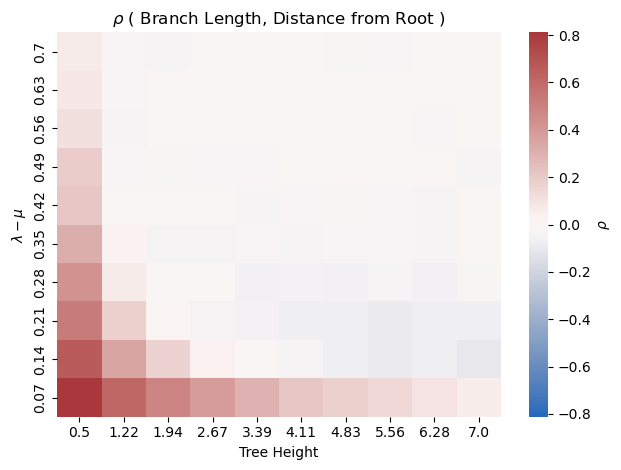

In [ ]:
rhos = corrs.unstack()#.iloc[:,1:]
rhos.index = np.round(lam-rhos.index, 2)
rhos.columns = np.round(rhos.columns, 2)
bound= rhos.abs().values.max()
ax = sns.heatmap(rhos,vmin=-bound, vmax=bound, cmap='vlag', center=0,
                 cbar_kws={"label": r"$\rho$"})

# from matplotlib.ticker import FormatStrFormatter

# majorFormatter = FormatStrFormatter('%2.2f')
# ax.xaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_major_formatter(majorFormatter)
ax.invert_yaxis()
ax.set_ylabel(r"$\lambda-\mu$")
ax.set_xlabel("Tree Height")
plt.title(r"$\rho$ ( Branch Length, Distance from Root )")
plt.tight_layout()
plt.savefig(f"bl_depth_corr_{lam}.png");

In [ ]:
try:
    n = pd.read_pickle("bd_sizes_deep_200.pd.gz")
except:
    n = pd.DataFrame(
        sizes, index=pd.MultiIndex.from_tuples(k, names=["mu", "h"])
    )  # .unstack()
# n.to_pickle('bd_sizes_deep_200.pd.gz')
# print(n.index)
n = fix_index(n)
n = np.log(n)
ax = sns.heatmap(n.mean(1).unstack())
plt.title("log(Number of Tips)")
ax.set_ylabel(r"$\mu$")
ax.set_xlabel("Tree Height")
plt.savefig("treesize_hm.png");

In [ ]:
n = (
    pd.read_pickle("bd_sizes_deep_200.pd.gz")
    .stack()
    .reset_index()
    .drop(columns="level_2")
)
n.columns = ["mu", "height", "ntaxa"]
n

In [ ]:
sns.relplot(
    data=n,
    kind="line",
    x="mu",
    y="ntaxa",
    hue="height",
    errorbar=("ci", 95),
)
plt.ylabel("Number of Tips")
plt.xlabel(r"$\mu$");
# plt.show()

## Exact bl probabilities based on Dieselhorst/Paradis

High $\lambda-\mu$ means short branches are more common everywhere.  Low $\lambda-\mu$ means they're more common near the tips.

Actually these figs are the probability that a speciation happens at time t0, and at time t1, and there're at least 3 descendant lineages that last forever.

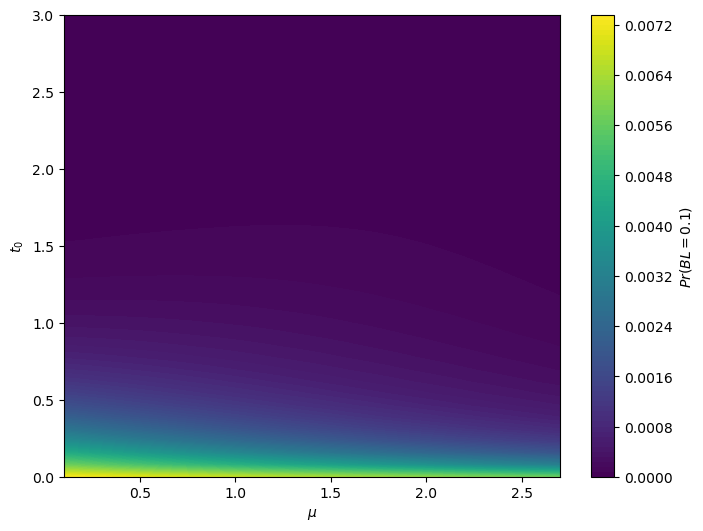

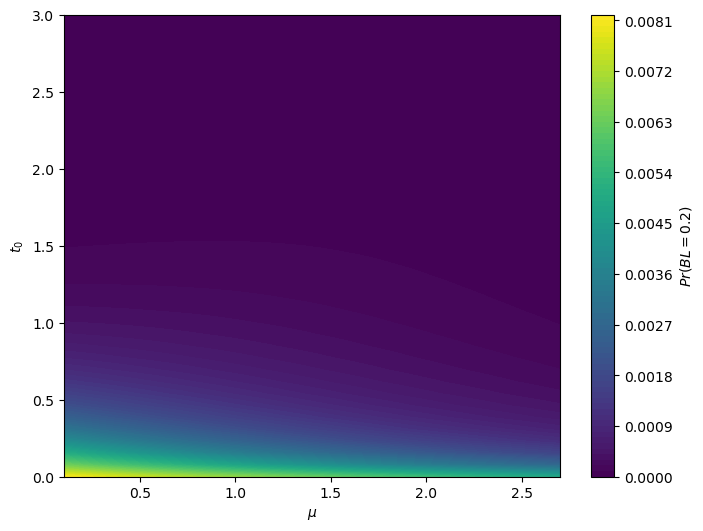

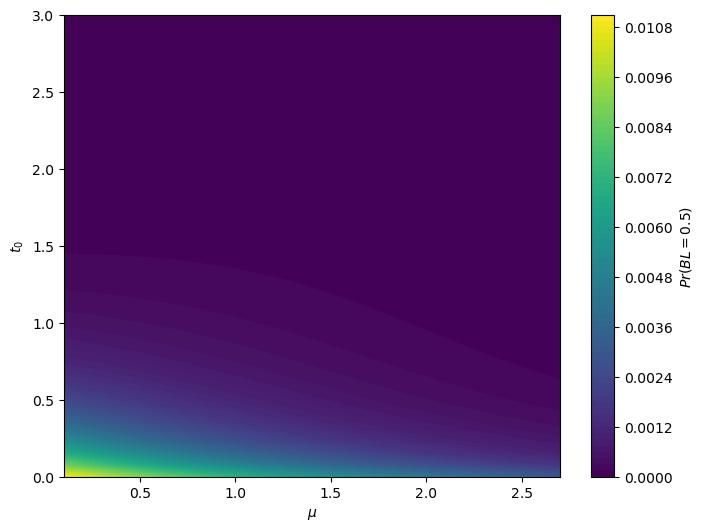

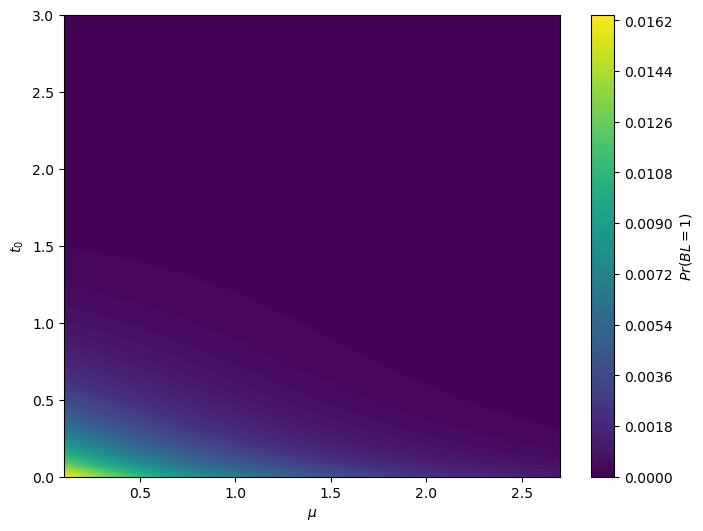

In [ ]:
# for T infinite:
f = lambda lam,mu,t0,dt: 2*lam**2 * (lam-mu) **3 * np.exp( (2*t0+dt) * (lam-mu) ) / (lam * np.exp( t0*(lam-mu) ) - mu)**3

# for finite T:
# f = lambda lam,mu,t0,dt: 2*lam**2 * (lam-mu) **3 * np.exp( (2*t0+dt) * (lam-mu)) / (lam * np.exp( t0*(lam-mu) ) - mu)**3 / ( (lam-mu*np.exp(-T*(lam-mu)))**2 )

# dt = t1-t0
lam = 3
N = 40
T=3
mu=np.linspace(0.1, 0.9 * lam, N)
t0 = np.linspace(0, T, N)
grid = np.meshgrid(mu, t0)

for dt in [ .1,.2, .5,1]:

    y = f(lam, grid[0], grid[1], dt)
    y/=y.sum()
    plt.figure(figsize=(8, 6))
    plt.contourf(grid[0], grid[1], y, levels=100, cmap='viridis')
    plt.colorbar(label=f'$Pr(BL = {dt})$')
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$t_0$');

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_105109/786626351.py:17: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label=f'pdf for $\lambda={lam},\mu={mu:.2f}$')
/tmp/ipykernel_105109/786626351.py:17: SyntaxWarning: invalid escape sequence '\m'
  plt.colorbar(label=f'pdf for $\lambda={lam},\mu={mu:.2f}$')


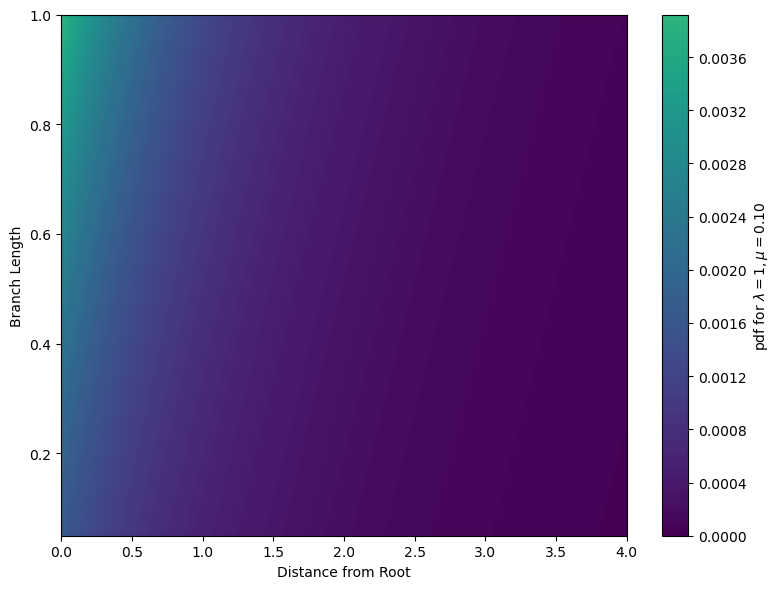

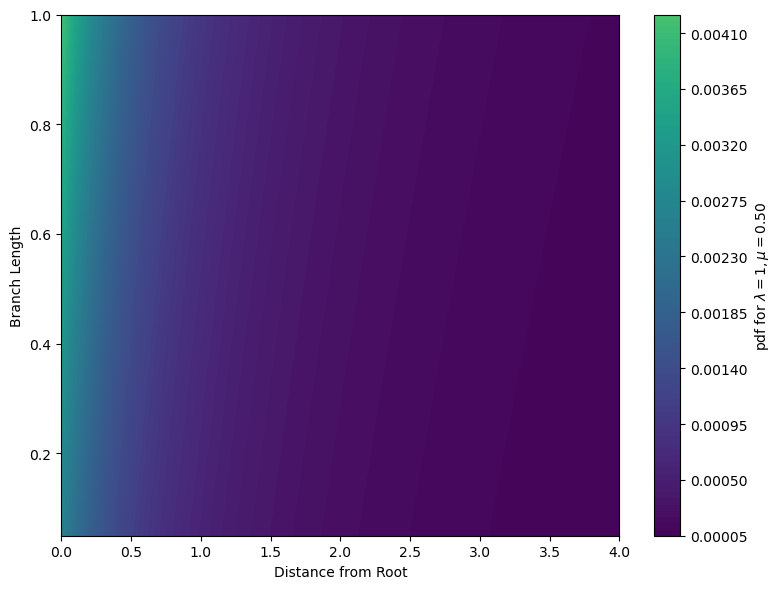

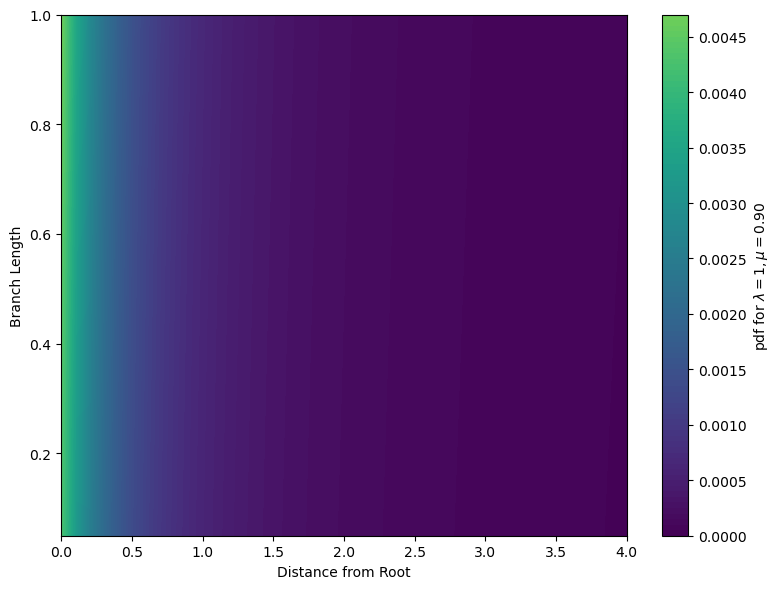

In [ ]:
lam = 1
# mu=np.linspace(0.1, 0.9 * lam, 10)
N = 40
T = 4
t0 = np.linspace(0, T, N)
max_bl = 1
dt=np.linspace(0.05,max_bl,N)
grid = np.meshgrid(t0, dt)


for mu in np.linspace(0.1*lam, 0.9 * lam, 3):
    y = f(lam,mu, grid[0], grid[1])
    y/=y.sum()
    plt.figure(figsize=(8, 6))
    plt.contourf(grid[0], grid[1], y, levels=100, cmap='viridis',
                 vmin=0.0, vmax=0.006,)
    plt.colorbar(label=f'pdf for $\lambda={lam},\mu={mu:.2f}$')
    plt.xlabel(r'Distance from Root')
    plt.ylabel(r'Branch Length')
    plt.tight_layout();

<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_105109/3966513466.py:14: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(t0, y, label=f'$\lambda={lam},\mu={mu:.2f}$')
/tmp/ipykernel_105109/3966513466.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(t0, y, label=f'$\lambda={lam},\mu={mu:.2f}$')


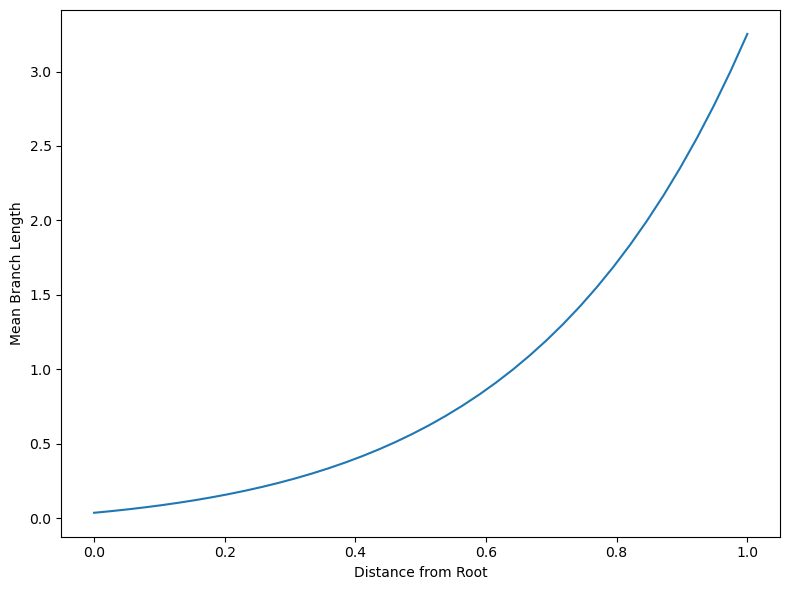

In [ ]:
lam = 5
# mu=np.linspace(0.1, 0.9 * lam, 10)
N = 40
T=1
t0 = np.linspace(0, T, N)
dt=np.linspace(0.05,.5,N)
grid = np.meshgrid(t0, dt)
mu=.1

y = f(lam,mu, grid[0], grid[1])
y/=y.sum(1)
y = (y*grid[1]).sum(axis=1)  # integrate over branch length
plt.figure(figsize=(8, 6))
plt.plot(t0, y, label=f'$\lambda={lam},\mu={mu:.2f}$')
plt.xlabel(r'Distance from Root')
plt.ylabel(r'Mean Branch Length')
plt.tight_layout();

## Exact probabilities for finite tree height $T$

In [ ]:
from sympy import integrate, Symbol
from sympy import sympify, symbols,exp,simplify
t,T,lam,mu,t0,dt,t1,z = symbols('t T lambda mu t0 dt t1 z',positive=True)
# integral_result = integrate(f, x)
# print(integral_result)
u = exp((mu-lam)*(T-t))

# w = 1/u + (mu/(mu-lam))*(1-1/u)
w = simplify(1/u *  ( 1 + integrate( exp( (mu-lam) * (z-t) ) * mu, (z,t,T))))
w = w.args[0][0]
w=simplify(sympy.factor(w))

(lambda*exp(T*lambda + mu*t) - mu*exp(T*mu + lambda*t))*exp(-T*mu - lambda*t)/(lambda - mu)

In [28]:
simplify(1/u + (mu/(mu-lam))*(1-1/u))

(-mu*(1 - exp((T - t)*(lambda - mu))) + (lambda - mu)*exp((T - t)*(lambda - mu)))/(lambda - mu)

In [37]:
p1 = 1/(u*w)
p0 = 1 - p1
p2 = 1 - p0 - 1/(u*w**2)
g1 = simplify( 2 * lam * p2 * p1)

g2 = simplify(lam * p1**2)

simplify(sympy.factor(g2))

lambda*(lambda - mu)**2*exp(2*T*lambda + 2*mu*t)/(lambda*exp(T*lambda + mu*t) - mu*exp(T*mu + lambda*t))**2

In [32]:
simplify(lam * p1**2)


lambda*(lambda - mu)**2*exp(2*(T - t)*(lambda - mu))/(-mu*(1 - exp((T - t)*(lambda - mu))) + (lambda - mu)*exp((T - t)*(lambda - mu)))**2

In [38]:
simplify(sympy.factor(g1))

2*lambda**2*(lambda - mu)**2*(exp(T*lambda + mu*t) - exp(T*mu + lambda*t))*exp(2*T*lambda + 2*mu*t)/(lambda*exp(T*lambda + mu*t) - mu*exp(T*mu + lambda*t))**3

In [39]:

integral_result = ( integrate(g2, (t,t0,t1)))
integral_result

(lambda*mu - mu**2)/(lambda**2*exp((T - t1)*(lambda - mu)) - lambda*mu) - (lambda*mu - mu**2)/(lambda**2*exp((T - t0)*(lambda - mu)) - lambda*mu) + (lambda - mu)*log(exp((T - t0)*(lambda - mu)) - mu/lambda)/lambda - (lambda - mu)*log(exp((T - t1)*(lambda - mu)) - mu/lambda)/lambda

In [42]:
simplify(integral_result)

(mu*(-lambda + mu)*(lambda*exp((T - t1)*(lambda - mu)) - mu) + mu*(lambda - mu)*(lambda*exp((T - t0)*(lambda - mu)) - mu) + (lambda - mu)*(lambda*exp((T - t0)*(lambda - mu)) - mu)*(lambda*exp((T - t1)*(lambda - mu)) - mu)*(log(lambda*exp((T - t0)*(lambda - mu)) - mu) - log(lambda*exp((T - t1)*(lambda - mu)) - mu)))/(lambda*(lambda*exp((T - t0)*(lambda - mu)) - mu)*(lambda*exp((T - t1)*(lambda - mu)) - mu))

In [40]:
f = g1.subs(t,t0) * g2.subs(t,t1) * exp(-integral_result - mu * (t1-t0))
print(f)
f

2*lambda**2*(lambda - mu)**4*((lambda - mu)*(mu*(1 - exp((T - t0)*(lambda - mu))) + (-lambda + mu)*exp((T - t0)*(lambda - mu))) + (mu*(1 - exp((T - t0)*(lambda - mu))) - (lambda - mu)*exp((T - t0)*(lambda - mu)))**2)*exp(2*(T - t0)*(lambda - mu))*exp(2*(T - t1)*(lambda - mu))*exp(-mu*(-t0 + t1) - (lambda*mu - mu**2)/(lambda**2*exp((T - t1)*(lambda - mu)) - lambda*mu) + (lambda*mu - mu**2)/(lambda**2*exp((T - t0)*(lambda - mu)) - lambda*mu) - (lambda - mu)*log(exp((T - t0)*(lambda - mu)) - mu/lambda)/lambda + (lambda - mu)*log(exp((T - t1)*(lambda - mu)) - mu/lambda)/lambda)/((mu*(1 - exp((T - t0)*(lambda - mu))) - (lambda - mu)*exp((T - t0)*(lambda - mu)))**4*(-mu*(1 - exp((T - t1)*(lambda - mu))) + (lambda - mu)*exp((T - t1)*(lambda - mu)))**2)


2*lambda**2*(lambda - mu)**4*((lambda - mu)*(mu*(1 - exp((T - t0)*(lambda - mu))) + (-lambda + mu)*exp((T - t0)*(lambda - mu))) + (mu*(1 - exp((T - t0)*(lambda - mu))) - (lambda - mu)*exp((T - t0)*(lambda - mu)))**2)*exp(2*(T - t0)*(lambda - mu))*exp(2*(T - t1)*(lambda - mu))*exp(-mu*(-t0 + t1) - (lambda*mu - mu**2)/(lambda**2*exp((T - t1)*(lambda - mu)) - lambda*mu) + (lambda*mu - mu**2)/(lambda**2*exp((T - t0)*(lambda - mu)) - lambda*mu) - (lambda - mu)*log(exp((T - t0)*(lambda - mu)) - mu/lambda)/lambda + (lambda - mu)*log(exp((T - t1)*(lambda - mu)) - mu/lambda)/lambda)/((mu*(1 - exp((T - t0)*(lambda - mu))) - (lambda - mu)*exp((T - t0)*(lambda - mu)))**4*(-mu*(1 - exp((T - t1)*(lambda - mu))) + (lambda - mu)*exp((T - t1)*(lambda - mu)))**2)

In [41]:
simplify(sympy.factor(f))

2*lambda**3*(lambda**4*exp(T*lambda + mu*t0) - lambda**4*exp(T*mu + lambda*t0) - 4*lambda**3*mu*exp(T*lambda + mu*t0) + 4*lambda**3*mu*exp(T*mu + lambda*t0) + 6*lambda**2*mu**2*exp(T*lambda + mu*t0) - 6*lambda**2*mu**2*exp(T*mu + lambda*t0) - 4*lambda*mu**3*exp(T*lambda + mu*t0) + 4*lambda*mu**3*exp(T*mu + lambda*t0) + mu**4*exp(T*lambda + mu*t0) - mu**4*exp(T*mu + lambda*t0))*exp(4*T*lambda + lambda*t0 - lambda*t1 + 3*mu*t0 + mu*t1 - mu*exp(T*mu + lambda*t1)/(lambda*exp(T*lambda + mu*t1) - mu*exp(T*mu + lambda*t1)) + mu*exp(T*mu + lambda*t0)/(lambda*exp(T*lambda + mu*t0) - mu*exp(T*mu + lambda*t0)) + mu**2*exp(T*mu + lambda*t1)/(lambda*(lambda*exp(T*lambda + mu*t1) - mu*exp(T*mu + lambda*t1))) - mu**2*exp(T*mu + lambda*t0)/(lambda*(lambda*exp(T*lambda + mu*t0) - mu*exp(T*mu + lambda*t0))) + mu*(-T*mu - lambda*t0 + log(lambda*exp(T*lambda + mu*t0) - mu*exp(T*mu + lambda*t0)))/lambda - mu*(-T*mu - lambda*t1 + log(lambda*exp(T*lambda + mu*t1) - mu*exp(T*mu + lambda*t1)))/lambda)/(lambda*

In [9]:
s0,s1 = symbols('s0 s1', positive=True)
final = f.subs(
    {exp((T - t0)*(lam - mu)): s0, exp((T - t1)*(lam - mu)): s1}
    )

print(final)
final

2*lambda**2*s0**2*s1**2*(lambda - mu)**4*((lambda - mu)*(mu*(1 - s0) + s0*(-lambda + mu)) + (mu*(1 - s0) - s0*(lambda - mu))**2)*exp(-mu*(-t0 + t1) - (mu*(-lambda + mu)*(lambda*s1 - mu) + mu*(lambda - mu)*(lambda*s0 - mu) + (lambda - mu)*(lambda*s0 - mu)*(lambda*s1 - mu)*(log(lambda*s0 - mu) - log(lambda*s1 - mu)))/(lambda*(lambda*s0 - mu)*(lambda*s1 - mu)))/((mu*(1 - s0) - s0*(lambda - mu))**4*(-mu*(1 - s1) + s1*(lambda - mu))**2)


2*lambda**2*s0**2*s1**2*(lambda - mu)**4*((lambda - mu)*(mu*(1 - s0) + s0*(-lambda + mu)) + (mu*(1 - s0) - s0*(lambda - mu))**2)*exp(-mu*(-t0 + t1) - (mu*(-lambda + mu)*(lambda*s1 - mu) + mu*(lambda - mu)*(lambda*s0 - mu) + (lambda - mu)*(lambda*s0 - mu)*(lambda*s1 - mu)*(log(lambda*s0 - mu) - log(lambda*s1 - mu)))/(lambda*(lambda*s0 - mu)*(lambda*s1 - mu)))/((mu*(1 - s0) - s0*(lambda - mu))**4*(-mu*(1 - s1) + s1*(lambda - mu))**2)

In [4]:
import sympy
t,T,lam,mu,t0,dt,t1,z = sympy.symbols('t T lambda mu t0 dt t1 z',positive=True)

er0 = sympy.exp((mu-lam) * (T-t0))
er1 = sympy.exp((mu-lam) * (T-t1))
f = 2 * lam**3 * (lam-mu)**4 * sympy.exp(-(lam*(lam-mu)**2+mu) * (t1-t0)) * \
    ( (lam/mu+er1) / (lam/mu+er0) ) ** (lam-mu) * \
( ( lam*er0**-3 + 2*mu*er0**-2 - lam*er0**-2) / (lam / er0 + mu)**3) / \
(lam+mu*er1)**2
f = sympy.powsimp(f.subs(t1,t0+dt), deep=True)



In [5]:
f

lambda**3*((lambda/mu + exp((-lambda + mu)*(T - dt - t0)))/(lambda/mu + exp((T - t0)*(-lambda + mu))))**(lambda - mu)*(lambda - mu)**4*(-2*lambda*exp(-2*(T - t0)*(-lambda + mu)) + 2*lambda*exp(-3*(T - t0)*(-lambda + mu)) + 4*mu*exp(-2*(T - t0)*(-lambda + mu)))*exp(dt*(-lambda*(lambda - mu)**2 - mu))/((lambda + mu*exp((-lambda + mu)*(T - dt - t0)))**2*(lambda*exp(-(T - t0)*(-lambda + mu)) + mu)**3)

In [6]:
func = sympy.lambdify(
    (lam, mu, T,t0,dt),
    f,
    modules='numpy'
)

[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]
(array([0., 1., 2., 3., 4., 5., 6., 7.]), [Text(0.0, 0, '0'), Text(1.0, 0, '1'), Text(2.0, 0, '2'), Text(3.0, 0, '3'), Text(4.0, 0, '4'), Text(5.0, 0, '5'), Text(6.0, 0, '6'), Text(7.0, 0, '7')])
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]
(array([0., 1., 2., 3., 4., 5., 6., 7.]), [Text(0.0, 0, '0'), Text(1.0, 0, '1'), Text(2.0, 0, '2'), Text(3.0, 0, '3'), Text(4.0, 0, '4'), Text(5.0, 0, '5'), Text(6.0, 0, '6'), Text(7.0, 0, '7')])
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.

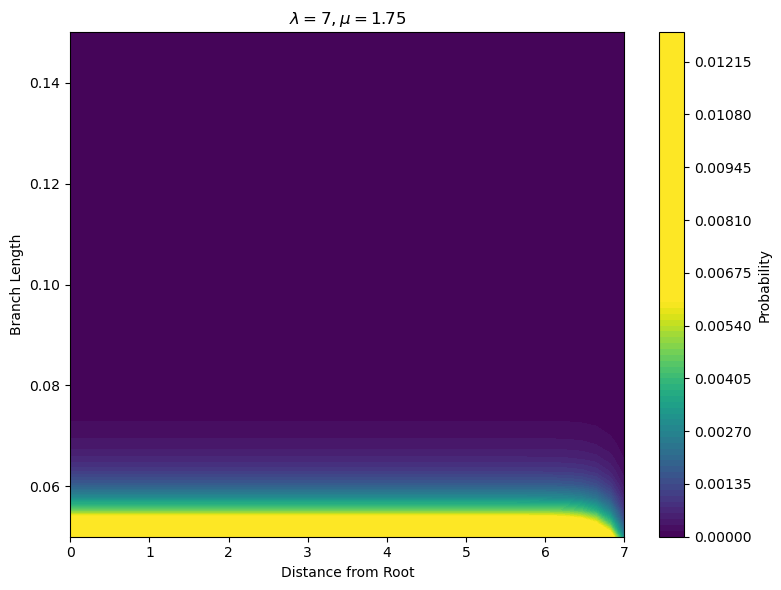

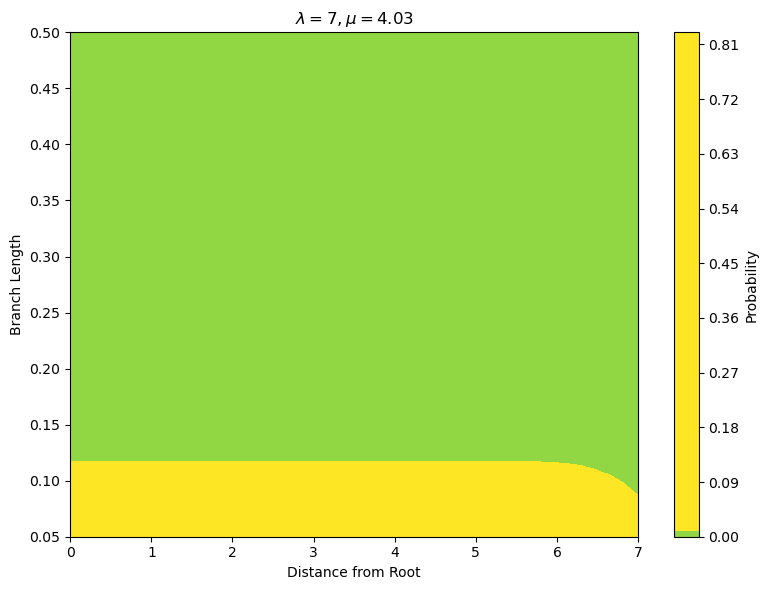

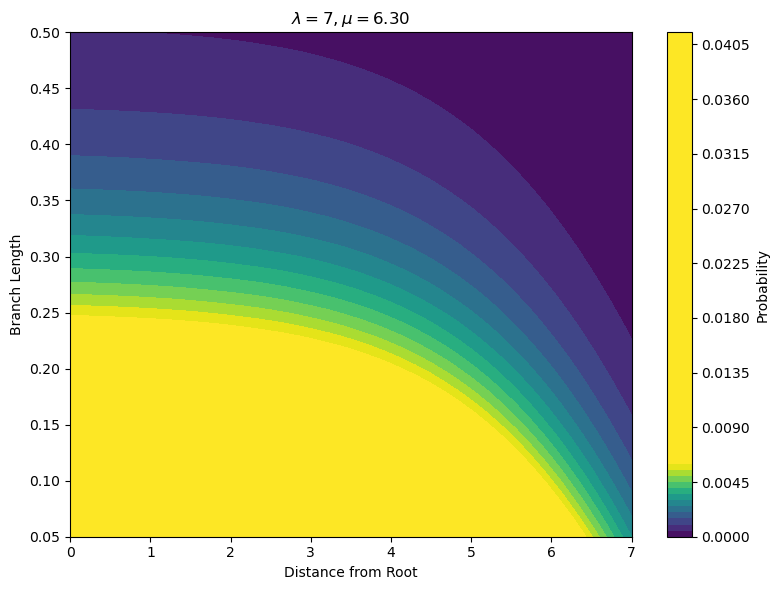

In [27]:
lam = 7#3
# mu=np.linspace(0.1, 0.9 * lam, 10)
N = 40
T = 7
t0 = np.linspace(0, T, N)

lim = 1e-90

for mu in np.linspace(0.25*lam, 0.9 * lam, 3):
    max_bl = .15 if mu < 0.5 * lam and lam > 3 else .5
    dt=np.linspace(0.05,max_bl,N)
    grid = np.meshgrid(t0, dt)

    y = func(lam,mu, T, grid[0], grid[1])
    # y/=y.sum(0)

    print(dt[y.argmax(axis=0)])
    plt.figure(figsize=(8, 6))
    plt.contourf(
        grid[0],
        grid[1],
        # grid[0] / T,
        # grid[1] / T,
        y, 
        levels=100, 
        cmap='viridis',
        vmin=0.0, 
        vmax=0.006,
    )
    print(plt.xticks())
    # plt.xticks(np.array(plt.xticks() )/ T)
    # plt.yticks(np.array(plt.yticks()) / T)
    plt.colorbar(label=f'Probability')
    plt.xlabel(r'Distance from Root')
    plt.ylabel(r'Branch Length')
    plt.title(rf'$\lambda={lam},\mu={mu:.2f}$')
    plt.tight_layout();
    plt.savefig(f'figures/branch_length_pdf_lam{lam}_mu{mu:.2f}_H{T}.png')

# plt.figure(figsize=(8, 6))

# plt.hist(y,bins=100, density=True);

In [17]:
grid[0]/T

array([[0.        , 0.02564103, 0.05128205, ..., 0.94871795, 0.97435897,
        1.        ],
       [0.        , 0.02564103, 0.05128205, ..., 0.94871795, 0.97435897,
        1.        ],
       [0.        , 0.02564103, 0.05128205, ..., 0.94871795, 0.97435897,
        1.        ],
       ...,
       [0.        , 0.02564103, 0.05128205, ..., 0.94871795, 0.97435897,
        1.        ],
       [0.        , 0.02564103, 0.05128205, ..., 0.94871795, 0.97435897,
        1.        ],
       [0.        , 0.02564103, 0.05128205, ..., 0.94871795, 0.97435897,
        1.        ]], shape=(40, 40))

In [ ]:
y = func(lam,mu, T, grid[0], grid[1])
y


(40, 40)

# Coalescent Simulations

## simulate bd parent trees


In [ ]:
# for lam in np.arange(1,15,2):
#     for mu in lam*np.arange(.1,.9,.2):#np.concatenate([np.arange(.1,.9,.2),[1]]):
#         for tree_height in [1,3,5]:

for lam in np.arange(0.5, 13, 0.5):
    # for mu in lam*np.arange(.7,.999,.1):#np.concatenate([np.arange(.1,.9,.2),[1]]):
    for mu in lam * np.arange(
        0.9, 0.999, 0.05
    ):  # np.concatenate([np.arange(.1,.9,.2),[1]]):
        for tree_height in [3, 5, 7, 1]:
            data_dir = parent_dir / f"l{lam:.1f}" / f"m{mu:.3f}" / f"h{tree_height}"
            data_dir.mkdir(exist_ok=True, parents=True)
            # print(data_dir)
            try:
                with open(data_dir / "parent_trees.phy", "r") as f:
                    parent_trees_full = [
                        dendropy.Tree.get_from_string(t, "newick") for t in f
                    ]
                # if len(parent_trees_full)<n_parent_trees:
                #     raise IOError('not enough trees, regenerating...')

            except (FileNotFoundError, IOError) as e:
                print(f"No files in {data_dir} not found, simulating...")
                parent_trees_full = sim_bd_trees(mu, lam, tree_height, n_parent_trees)
                with open(data_dir / "parent_trees.phy", "w") as f:
                    f.writelines([t.as_string("newick") for t in parent_trees_full])

                ntaxa = pd.Series(list(map(len, parent_trees_full)))
                # parent_trees=[t for t in parent_trees_full if len(t)>3]
                with open(data_dir / "parent_trees_4plus.phy", "w") as f:
                    f.writelines(
                        [t.as_string("newick") for t in parent_trees_full if len(t) > 3]
                    )

Given the covariance matrix C, can simulate a trait $\sim\mathcal{N}(0,\sigma_\xi^2C/L)$, where $\sigma_\xi^2$ is the variance of the mutational effect of each locus, and $L$ is the number of loci.

In [ ]:
print(gene_tree.as_ascii_plot(), gene_tree.taxon_namespace)
print(parent_tree.as_ascii_plot(), parent_tree.taxon_namespace)

In [ ]:
ntaxa = pd.Series([len(ss) for ss in s])
ntaxa.hist(bins=50)
plt.title("sampled gene tree")
plt.xlabel("number of taxa")
print(f"{sum(ntaxa < 4)} trees with < 4 taxa", "\n", ntaxa.value_counts().sort_index())

## Simulate traits

_TODO_: simulate traits on parent trees for 'no ILS' condition. Doesn't need $C^*$ matrix.

In [ ]:
njobs = 32

n_genes = (1, 10)  # [5,10,25,50]

for h in range(1, 5, 2):
    for lam in np.arange(1, 5, 2):
        for mu in lam * np.arange(
            0.3, 0.9, 0.2
        ):  # np.concatenate([np.arange(.1,.9,.2),[1]]):
            d = parent_dir / f"l{lam:.1f}" / f"m{mu:.3f}" / f"h{h}"
            try:
                sigmas = simulate_c_star_matrices(
                    d, n_genes=n_genes, overwrite=False, njobs=njobs
                )
            except Exception as e:
                print(e)
                pass

for h in range(5, 11, 2):
    for lam in np.arange(1, 5, 2):
        for mu in lam * np.arange(
            0.5, 0.9, 0.2
        ):  # np.concatenate([np.arange(.1,.9,.2),[1]]):
            d = parent_dir / f"l{lam:.1f}" / f"m{mu:.1f}" / f"h{h}"
            try:
                sigmas = simulate_c_star_matrices(
                    d, n_genes=n_genes, overwrite=False, njobs=njobs
                )
            except Exception as e:
                print(e)
                pass


In [ ]:
njobs = 16

print(n_genes)
n_genes = (1,)
for h in range(1, 9, 2):
    for d in parent_dir.glob(f"*/*/h{h}"):
        # sigmas = simulate_c_star_matrices(d, n_genes=n_genes, overwrite=False, njobs=njobs)
        if not (d / "sigmas_ngenes10.npz").exists():  # need at least some sims
            continue
        try:
            sigmas = simulate_c_star_matrices(
                d, n_genes=n_genes, overwrite=False, njobs=njobs
            )
            samples = simulate_traits(
                n_genes, sigmas, data_dir=d, njobs=njobs, overwrite=False
            )
            # print(d)
        except TimeoutError:
            continue

In [ ]:
d

## Null Model
Stretch all the trees so there's no ILS

In [ ]:
tall_dir = data_dir.parent / (data_dir.name + f"_s{stretch}")
tall_dir

In [ ]:
tall_samples = simulate_traits(n_genes, sigma_tall, tall_dir)

In [ ]:
tree = parent_trees[0]
tall_trees = [tree.clone(1) for tree in parent_trees]
stretch = 5

tall_height = tree_height * stretch
tall_dir = data_dir.parent / (data_dir.name + f"_s{stretch}")
tall_dir.mkdir(exist_ok=True)

for tree in tall_trees:
    tree.scale_edges(stretch)
sigma_tall = simulate_c_star_matrices(tall_trees, data_dir=tall_dir)

# Compute covariance matrix of a tree
Weird answers if $H< 1, \mathbf{E}_k<1,N_e=1$

In [ ]:
# from scipy.special import factorial
# from numba import njit
# from collections import defaultdict
# from itertools import combinations_with_replacement

# @lru_cache(maxsize=200)
# def rho(k,t):return rho_numba(k,t)

# @njit(parallel=True)
# def rho_numba(k,t):
#     return np.exp((-k**2+k)*t/2)

# @lru_cache(maxsize=200)
# def upto(a,j):return upto_numba(a,j)

# @njit(parallel=True)
# def upto_numba(a,j):
#     if j<1:return 1
#     r=1
#     for k in range(a,a+j): r*=k
#     return r

# @lru_cache(maxsize=200)
# def downto(a,j):return downto_numba(a,j)

# @njit(parallel=True)
# def downto_numba(a,j):
#     if j<1:return 1
#     r=1
#     for k in range(a,a-j,-1): r*=k
#     return r

# # @njit(parallel=True)
# @lru_cache(maxsize=200)
# def gterm(i,j,k):
#     if not j<=i: raise ValueError(f'i={i},j={j}')
#     try:
#         res=(2*k-1)*downto(i,k)*(-1)**k / upto(i,k)
#         if j>1:
#             res *= upto(j,k-1) / ( (-1)**j * factorial(j) * factorial(k-j) )
#         return res
#     except:
#         print(i,j,k)
#         raise

# # @njit(parallel=True)
# def g(i,j,t):
#     # tavare p132
#     if j==1:
#         try:
#             return 1 - sum( gterm(i,j,k)*rho(k,t) for k in range(2,i+1) )
#         except:
#             print(i,j,t)
#             raise
#     return sum(gterm(i,j,k)*rho(k,t) for k in range(j,i+1))


# def lineages_through_time(tree:dendropy.Tree, Ne:int=1,delta=1000,epsilon:float=1e-6):
#     children=[] # list of #nlineages:proba dictionaries
#     for e in tree.postorder_edge_iter():
#         if e.is_leaf():children.append({1:1})
#         elif e.length>delta:continue
#         else:
#             a=children.pop()
#             b=children.pop()
#             probs=defaultdict(lambda:0.)
#             for ai in a:
#                 for bi in b:
#                     p0=p=1
#                     for j in range(1,ai+bi+1):
#                         p=g(ai+bi,j,e.length)
#                         # print(ai+bi,j,e.length,'p',p)
#                         if epsilon>0 and p0>epsilon and p<epsilon:break # don't know if p's are increasing or decreasing
#                         probs[j]+=p*a[ai]*b[bi]
#             children.append(probs)
#     # print(children)
#     probs=children.pop()

#     return sum(probs[k]*(1-1/k) for k in probs)*2*Ne


# def calculate_uncorrected_covariance(tree:dendropy.Tree,
#                          L:int,
#                          Ne:int=1,
#                          sig2=1,
#                          delta=1000,
#                          epsilon=1e-5):
#     tree.calc_node_ages()
#     H=tree.max_distance_from_root()
#     L_sig=L*sig2
#     taxa = [n.taxon for n in tree.leaf_nodes()]
#     covs = {}
#     for a,b in combinations_with_replacement(taxa,2):
#         covs[(a.label, b.label)]= L_sig*(H-tree.mrca(taxa=(a,b)).age)
#         covs[(b.label, a.label)]= covs[(a.label, b.label)]
#     return covs


# def calculate_covariance(tree:dendropy.Tree,
#                          L:int,
#                          Ne:int=1,
#                          sig2=1,
#                          delta=1000,
#                          epsilon=1e-5,
#                         as_df=False):
#     E_k = lineages_through_time(tree,Ne=Ne, delta=delta, epsilon=epsilon)
#     tree.calc_node_ages()
#     H=tree.max_distance_from_root()
#     L_sig=L*sig2
#     # print(L,sig2,H,E_k,Ne)
#     if H==Ne:print('WARNING: covariances will be negative')
#     summand=L_sig*(H+E_k-Ne )
#     taxa = [n.taxon for n in tree.leaf_nodes()]
#     covs = {}
#     for a,b in combinations_with_replacement(taxa,2):
#         covs[(a.label, b.label)]= max(0,summand-L_sig*tree.mrca(taxa=(a,b)).age)
#         covs[(b.label, a.label)]= covs[(a.label, b.label)]
#     if as_df:
#         return pd.Series(covs).unstack()
#     return covs



## Null model - stretch trees
stretch species tree such that ILS is highly improbable.

In [ ]:
# parent_trees = sim_bd_trees(lam=lam,
#                             mu=mu,
#                             tree_height=h,
#                             n_parent_trees=100)
print("simulating covariances...")
d = parent_dir / f"l{lam:.1f}/m{mu:.3f}/h{h}"

sigmas_ils = simulate_c_star_matrices(d, n_genes=n_genes, overwrite=False, njobs=njobs)
print("simulating traits...")
samples_ils = simulate_traits(
    n_genes, sigmas_ils, data_dir=d, njobs=njobs, overwrite=True
)


In [ ]:
s_ils = np.load(
    "/N/project/phyloML/rate_timescaling/data/tree_sims/l11.0/m7.700/h1/samples_ngenes25.npz"
)
s1 = s_ils[s_ils.files[0]]
s = np.load(
    "/N/project/phyloML/rate_timescaling/data/tree_sims/l11.0/m7.700/h1/no_ils/samples_ngenes1.npz"
)
s2 = s[s.files[0]]
s1.max(), s2.max()

In [ ]:
lam, mu, h = 11, 5.5, 1  # 2,1.4,1

d = parent_dir / f"l{lam}_m{mu}_h{h}"
d.mkdir(parents=True, exist_ok=True)
print(d)

In [ ]:
try:
    with open(d / "parent_trees_4plus.phy", "r") as f:
        parent_trees = [dendropy.Tree.get_from_string(t, "newick") for t in f]
    print("loaded parent trees")
except:
    parent_trees = sim_bd_trees(lam=lam, mu=mu, tree_height=h, n_parent_trees=100)

    with open(d / "parent_trees.phy", "w") as f:
        f.writelines([t.as_string("newick") for t in parent_trees])

    with open(d / "parent_trees_4plus.phy", "w") as f:
        f.writelines([t.as_string("newick") for t in parent_trees if len(t) > 3])

sigmas_ils = simulate_c_star_matrices(d, n_genes=n_genes, overwrite=False, njobs=njobs)
samples_ils = simulate_traits(
    n_genes, sigmas_ils, data_dir=d, njobs=njobs, overwrite=True
)


In [ ]:
smallest_edge = min(e.length for t in parent_trees for e in t.internal_edges())

scaling = max(2, 1 / smallest_edge)

d_stretch = parent_dir / f"l{lam}_m{mu}_h{scaling:.3f}"
print(d, d_stretch)

try:
    with open(d_stretch / "parent_trees_4plus.phy", "r") as f:
        scaled_trees = [dendropy.Tree.get_from_string(t, "newick") for t in f]
except:
    scaled_trees = [t.clone() for t in parent_trees]
    for t in scaled_trees:
        t.scale_edges(scaling)
    d_stretch.mkdir(parents=True, exist_ok=True)

    with open(d_stretch / "parent_trees_4plus.phy", "w") as f:
        f.writelines([t.as_string("newick") for t in scaled_trees if len(t) > 3])
try:
    sigmas_stretch = simulate_c_star_matrices(
        d_stretch, n_genes=n_genes, overwrite=False, njobs=njobs
    )
finally:
    samples_stretch = simulate_traits(
        n_genes, sigmas_stretch, data_dir=d_stretch, njobs=njobs, overwrite=False
    )


In [ ]:
samples_ils = simulate_traits(
    n_genes, sigmas_ils, data_dir=d, njobs=njobs, overwrite=False
)
print(len(sigmas_ils[0]))

In [ ]:
with open(d / "parent_trees_4plus.phy", "r") as f:
    parent_trees = [dendropy.Tree.get_from_string(t, "newick") for t in f]
with open(d_stretch / "parent_trees_4plus.phy", "r") as f:
    parent_trees_stretch = [dendropy.Tree.get_from_string(t, "newick") for t in f]
print(len(parent_trees))

In [ ]:
for t in scaled_trees:
    t.calc_node_root_distances()
for t in parent_trees:
    t.calc_node_root_distances()
print(
    max(t.max_distance_from_root() for t in scaled_trees),
    max(t.max_distance_from_root() for t in parent_trees),
)

## Null model
simulate trait on species tree without ILS (i.e. 1 'gene' following the BD tree, not the multi-species coalescent on the BD tree)

In [ ]:
dirs = list(parent_dir.rglob("*/*/h*"))
np.random.shuffle(dirs)
for i, d in enumerate(dirs):
    # if not any(d.glob('samp*npz')):
    #     print('skipping',d)
    #     continue
    # print('in',d)

    with open(d / "parent_trees_4plus.phy", "r") as f:
        parent_trees = [dendropy.Tree.get_from_string(t, "newick") for t in f]
    parent_trees = list(islice(parent_trees, 5))
    sigmas = (*map(phylogenetic_covariance, parent_trees),)
    new_dir = d / "no_ils"
    new_dir.mkdir(exist_ok=True)
    samples = simulate_traits(
        [1], [sigmas], data_dir=new_dir, overwrite=False
    )  # parent_trees x #nsamples x ntaxa
    # break


In [ ]:
print(d)

In [ ]:
np.max(samples[0])
t = parent_trees[0]
print(t.as_ascii_plot())
t.calc_node_root_distances()
t.max_distance_from_root(), np.max(sigmas[0]), len(sigmas[0]), len(samples[0][0])

In [ ]:
(*map(len, (t, sigmas[0], samples[0][0])),)

sigmas[0], samples[0][0]

In [ ]:
! export OMP_NUM_THREADS=12
! export MPI_NUM_THREADS=12
! export MKL_NUM_THREADS=12
! export OPENBLAS_NUM_THREADS=12
! echo $OMP_NUM_THREADS

In [ ]:
a, j = 65, 64
i, j, k = 25, 1, 4
for i in range(20, 28):
    print(gterm(i, j, k), (-1) ** (k - j))
print(factorial(25))
np.exp(gammaln(5)), factorial(4), np.log(2 * k - 1) + ldownto(i, k) - lupto(i, k)

res = np.log(2 * k - 1) + ldownto(i, k) - lupto(i, k)
if j > 1:
    res += lupto(j, k - 1) - gammaln(j + 1) - gammaln(k - j + 1)
    sgn = k % 2 and -1 or 1
res, np.exp(res)

### Compare to empirical covariance
For each condition ($\lambda,\mu,H$), take mean Frobenius/Spectral/LD distance over all parent trees.

In [ ]:
njobs = 12
n_genes = [5, 10, 25, 50]

import joblib  # import dump,load

dists_dict = {}  # defaultdict(dict)

for i, d in enumerate(parent_dir.rglob("*/*/h1")):
    if not any(d.glob("samp*npz")):
        continue
    print("in", d)

    with open(d / "parent_trees_4plus.phy", "r") as f:
        parent_trees = [dendropy.Tree.get_from_string(t, "newick") for t in f]

    try:
        covs = joblib.load(d / "covs.gz")
        # raise
    except:
        continue

    sigmas = simulate_c_star_matrices(d, n_genes=n_genes, overwrite=False)

    samples = simulate_traits(
        n_genes, sigmas, data_dir=d, overwrite=False
    )  # parent_trees x #nsamples x ntaxa

    # print(len(sigmas),len(n_genes))
    for ngenes, sigs in zip(n_genes, sigmas):
        for tree_ix, (c, s) in enumerate(zip(covs, sigs)):
            tree_length = len(c)
            for fname, f in metrics.items():
                dists_dict[
                    (
                        tree_length,
                        fname,
                        ngenes,
                        d.parent.name[1:],
                        d.parent.parent.name[1:],
                    )
                ] = f(c, s / ngenes, normalize=True)
    dists = pd.Series(dists_dict)  # .unstack(level=[-1,-2])
    dists.index.names = ["tree_length", "metric", "ngenes", "mu", "lam"]
    dists = dists.reset_index().rename(columns={0: "value"})
    dists[["mu", "lam"]] = dists[["mu", "lam"]].applymap(float)
    dists.to_pickle(parent_dir / f"c_pred_v_actual_{d.name}.pd.gz")

In [ ]:
d = Path("/N/project/phyloML/rate_timescaling/data/tree_sims/l7.0/m4.900/h3")
# a = np.load(d/'sigmas_ngenes10.npz')

with open(d / "parent_trees_4plus.phy", "r") as f:
    parent_trees = [dendropy.Tree.get_from_string(t, "newick") for t in f]

# print(len((*a.keys(),)), a['arr_0'].shape, )

In [ ]:
from scipy.stats import mode

lens = list(map(len, parent_trees))
m = mode(lens)
m

In [ ]:
t = parent_trees[0]
a = get_branch_lengths_and_heights(t)
# ltt=dendr
len(t), a.shape, a
plt.plot(a[1], a[0], "ro")
import dendropy
from dendropy.calculate import treemeasure

treemeasure.pybus_harvey_gamma(t)

In [ ]:
a = get_branch_lengths_and_heights(t)
a2 = get_branch_lengths_and_heights2(t)
# ix=
# ltt=dendr
np.allclose(a[:, a[1].argsort()], a2[:, a2[1].argsort()]), a2.max()
# len(t.internal_nodes(exclude_seed_node=True)),len(list(t.preorder_internal_node_iter(exclude_seed_node=True)))

In [ ]:
# dists.index.set_levels(
#     dists.index.get_level_values('lam').map(lambda s:int(s[1:])),
#     level='lam'
# )
dists = pd.read_pickle(parent_dir / "c_pred_v_actual.pd.gz")

dists = dists.reset_index().drop(columns="ix")
dists.rename(columns={0: "value", "lam": "mu", "mu": "lam"}, inplace=True)

dists["lam"] = dists.lam.map(lambda s: float(s[1:]))
dists["mu"] = dists.mu.map(lambda s: float(s[1:]))
dists

In [ ]:
tree.max_distance_from_root()


In [ ]:
sns.relplot(
    data=dists[dists.metric == "fro"], col="ngenes", hue="lam", x="mu", y="value"
)

In [ ]:
print(tree.as_ascii_plot(), len(covs), len(parent_trees_full), c)
pdm = tree.phylogenetic_distance_matrix()
pdm.distances()

In [ ]:
x = np.array([[c.max().max(), s.max().max()] for c, s in zip(covs, sigs)]).T
x[0] - x[1]
# x.T

### Calculate Covariance

In [ ]:
def lineages(tree, steps=20):
    total_time = tree.max_distance_from_root()

    # Divide time span into 10 steps
    step = float(total_time) / steps

    # To store tuples of (time, number of lineages)
    ltt = []

    # Start at first time step
    current_time = step
    while current_time <= total_time:
        # Get number of lineages at current time
        num_lineages = tree.num_lineages_at(current_time)

        if num_lineages > 1:
            # Store it
            ltt.append((current_time, num_lineages))

        # Move to next time step
        current_time += step

    # Get the final number of lineages
    # Note: may not be the same as the number of tips if the tree has extinct
    # tips/taxa; though, if this were the case, we would not be dealing with an
    # ultrametric tree.
    if current_time < total_time:
        ltt.append((total_time, tree.num_lineages_at(total_time)))
    return np.array(ltt)


def d_lineages(s):
    return [(y1 - y0) / (x1 - x0) for (x0, y0), (x1, y1) in zip(s, s[1:])]

The correlation should be positive - if $C^*$ is a good estimator - or zero - if it's useless (e.g. random permutation of labels).  Why is it negative?

In [ ]:
print(d)

# cs=calculate_covariance(tree, L=1, epsilon=1e-8, as_df=True)
# print(cs,'\n-----\n')
joblib.__version__
# c=calculate_uncorrected_covariance(tree, L=1, epsilon=1e-8, as_df=True)
# print(frobenius_distance(c,cs,normalize=True), (cs-c).max())

In [ ]:
covs = [
    calculate_covariance(tree, L=1, epsilon=0, as_df=True) for tree in parent_trees_full
]

dists = {}  # defaultdict(dict)

for ngenes, sigs in zip(n_genes, sigmas):
    for tree_ix, (c, s) in enumerate(zip(covs, sigs)):
        for fname, f in metrics.items():
            dists[(tree_ix, fname, ngenes)] = f(c, s / ngenes, normalize=True)

dists = pd.Series(dists)  # .unstack(level=[-1,-2])
# dists.columns.names=['ngenes','function']#,'tree_ix'])

# sns.displot(data=dists)
dists = dists.reset_index()
dists.columns = ["ix", "func", "ngenes", "value"]
dists

In [ ]:
from scipy import stats

c1true, c1pred = c.iloc[0], s[0] / ngenes


def statistic(x):  # permute only `x`
    return stats.spearmanr(x, c1pred).statistic


res_asymptotic = stats.spearmanr(c1true, c1pred)

res_exact = stats.permutation_test((c1true,), statistic, permutation_type="pairings")
res_exact.pvalue, res_asymptotic.pvalue

In [ ]:
res_exact, res_asymptotic, c1true

In [ ]:
# dists.drop(columns=['level_0','index'],inplace=True)
data=dists[dists.value<1e10]
sns.relplot(data=data,kind='line',y='value',x='ngenes',col='func')
data.groupby('func').describe()pvalue

In [ ]:
 print('tree',tree.as_ascii_plot(),'\nH',H,'\nMRCA',{(a.label, b.label): tree.mrca(taxa=(a,b)).age for a in taxa for b in taxa }, '\nc',sorted(c.items()),'\nlineages' ,lineages_through_time(tree))

In [ ]:
dists["r"] = dists.lam - dists.mu
dists["rho"] = dists.lam / dists.mu
dists["fro_h"] = dists.fro / dists.h
dists["spec_h"] = dists.spec / dists.h

In [ ]:
sns.relplot(
    data=dists,  # .query('ngenes==25'), #.query('metric=="fro" & ngenes==25'),
    col="metric",
    hue="lam",
    style="lam",
    row="ngenes",
    x="r",
    y="value",
    kind="line",
)
plt.tight_layout()

In [ ]:
sns.relplot(
    data=dists,  # .query('ngenes==25'), #.query('metric=="fro" & ngenes==25'),
    col="metric",
    hue="lam",
    style="lam",
    row="ngenes",
    x="rho",
    y="value",
    kind="line",
)
plt.tight_layout()

In [ ]:
np.arange(0, 15, 3).append(3)

# Trait Divergence vs Time
Simplest correction: use pairwise distance plot.  Since traits are unnormalized, we normalize by ngenes. Since $\sigma^2=1$, $\mathbf{E}[X]=H$.
Must use $|dt|$, otherwise trend will be masked ($\mathbf{E}[Z(mX+b)]=0\; \forall m, b$ if $Z$ is a Rademacher r.v.).

In [ ]:
def rolling_window(df, offset, col=None):
    ix = df[col] if col else df.index
    imin, imax = ix.min(), ix.max()
    intervals = np.arange(imin, imax, offset)
    intervals = np.append(intervals, imax)
    return df.groupby(pd.cut(ix, intervals))


def div_ages(
    tree: dendropy.Tree,
    traits,
    reduction=np.mean,
    weighted=True,
    log=False,
    corrected=False,
    epsilon=1e-9,
):
    """unweighted: all paths contribute equally to the average.
    weighted: total deviation / total time; more distant pairs contribute more"""
    tree.encode_bipartitions()
    ns = sorted(tree.taxon_namespace)
    indices = {tax: i for i, tax in enumerate(ns)}
    # print(ns)
    paths = defaultdict(list)
    total_dist = defaultdict(list)
    total_time = defaultdict(list)
    ages = {}
    dxs = {}
    dts = {}
    tree.calc_node_ages()
    if corrected:
        c_star = calculate_covariance(tree, L=1, epsilon=epsilon)
        cmax = max(c_star.values())
    else:
        dists = tree.phylogenetic_distance_matrix()
    s = set(ns)
    for n_ix, n in enumerate(tree.internal_nodes()):
        # print(e.head_node.
        descendents = {l.taxon for l in n.leaf_nodes()}
        for l1 in descendents:
            for l2 in s.difference(
                descendents
            ):  # we won't double count dx's, so we should take abs value
                i, j = indices[l1], indices[l2]
                if (i, j) in dxs:
                    dx = dxs[(i, j)]
                    dt = dts[(i, j)]
                else:
                    # dx = np.log(traits[i]) - np.log(traits[j]) if log else traits[i]-traits[j]
                    dx = (
                        np.log(np.abs(traits[i]) - np.log(traits[j]))
                        if log
                        else np.abs(traits[i] - traits[j])
                    )
                    taxa = (ns[i], ns[j])
                    dt = (
                        cmax - c_star[(taxa[0].label, taxa[1].label)]
                        if corrected
                        else dists.distance(*taxa)
                    )

                    dxs[(i, j)] = dx
                    dts[(i, j)] = dt
                paths[n_ix].append(dx / dt)
                total_dist[n_ix].append(dx)
                total_time[n_ix].append(dt)
        ages[n_ix] = n.age
    # print(min(map(sum,total_time.values())),ages.keys(),total_time.keys())
    if weighted:
        res = [(ages[i], sum(total_dist[i]) / sum(total_time[i])) for i in paths]
    else:
        res = [(ages[i], reduction(paths[i])) for i in ages]
    return pd.DataFrame.from_records(res, columns=["node_age", "avg_trait_divergence"])


def divs(tree: dendropy.Tree, traits, log=False, covs=False):
    ns = sorted(tree.taxon_namespace)
    # print(ns)
    res = []
    c_star = calculate_covariance(t, L=1, epsilon=1e-9)
    dists = tree.phylogenetic_distance_matrix()
    for i, j in combinations(range(len(ns)), 2):
        # dx = np.log(traits[i]) - np.log(traits[j]) if log else traits[i]-traits[j]
        dx = (
            np.log(np.abs(traits[i]) - np.log(traits[j]))
            if log
            else np.abs(traits[i] - traits[j])
        )
        taxa = (ns[i], ns[j])

        res.append((dists.distance(*taxa), dx))
        # res.append((dists.distance(*taxa), c_star[(taxa[0].label,taxa[1].label)],dx))

    return pd.DataFrame.from_records(
        res, columns=["phenetic_distance", "trait_divergence"]
    )


from scipy import stats


def compute_rolling(vs, window, ix_col, trait_col, plot=False):
    vs = vs.set_index(ix_col).sort_index()
    vs = rolling_window(vs, window)[trait_col].agg(
        ["mean", "var"]
    )  # ,col='phenetic_distance')['trait_divergence'].var()
    vs.index = vs.index.map(lambda I: I.right).astype(float)
    # vs=vs.reset_index()
    vs = vs.interpolate("linear")
    # print(vs)
    # sns.scatterplot(vs)
    # sns.lineplot(vs)
    if plot:
        plt.plot(vs.index, vs["mean"], "r")
    return vs["mean"]
    # plt.xlabel(r'$dt$')
    # plt.ylabel(r'$Var$')
    # plt.title(f'Window size: {window}')


# plot_rolling(p,.1,'node_age','avg_trait_divergence')


In [ ]:
ngenes = 10
tree_ix = 17
trait_ix = 6

d = Path("/N/project/phyloML/rate_timescaling/data/tree_sims/l12.5/m11.250/h3/")

npzfile = np.load(d / f"samples_ngenes{ngenes}.npz")

samp = npzfile[f"arr_{tree_ix}"] / ngenes


with open(d / "parent_trees_4plus.phy", "r") as f:
    parent_trees = [dendropy.Tree.get_from_string(t, "newick") for t in f]
t = parent_trees[tree_ix]
print(len(npzfile.files), len(parent_trees), samp.shape, len(t))

In [ ]:
njobs = 24
print(njobs)
with Parallel(n_jobs=njobs) as parallel:
    parallel(
        delayed(process_dir)(
            d,
            True,
            False,
        )
        for h in (7, 1, 3, 5)
        for d in parent_dir.glob(f"*/*/h{h}")
    )


In [ ]:
t2 = t.clone()
ns = t2.taxon_namespace[:10]
subtrees = (t2.extract_tree_with_taxa(ns), t2.extract_tree_with_taxa(ns))

for st in subtrees:
    treestr = StringIO(
        st.as_string("newick", suppress_rooting=True, suppress_leaf_taxon_labels=False)
    )
    pt = Phylo.read(treestr, format="newick")
    Phylo.draw(pt)

In [ ]:
print([n.label for n in st.leaf_nodes()])
n = st.leaf_nodes()

In [ ]:
n[0].taxon.label

In [ ]:
tax = ["T108", "T89"]
n = st.mrca(taxon_labels=tax)
print(n.is_leaf())
st.prune_taxa_with_labels(tax)

# print(st.as_ascii_plot(), n.is_leaf())

treestr = StringIO(
    st.as_string("newick", suppress_rooting=True, suppress_leaf_taxon_labels=False)
)
pt = Phylo.read(treestr, format="newick")
Phylo.draw(pt)
print(len(st))


In [ ]:
lengths = sorted(
    [
        e.length
        for e in t.postorder_internal_edge_iter(filter_fn=None, exclude_seed_edge=True)
    ]
)
plt.plot(lengths)
np.quantile(lengths, 0.3)

In [ ]:
tl = dendropy.TreeList([t, subs])
tl.append(t)
len(tl), d

In [ ]:
sub_trees, sub_traits = dendropy.TreeList(), []
n_subsamples = 100
for _ in range(n_subsamples):
    subs = subsample_tree_random(t, 0.1)
    subsample = samp[:, [indices[n.taxon] for n in subs.leaf_node_iter()]]
    sub_trees.append(subs)
    sub_traits.append(subsample)
np.savez(sub_traits, d / f"subtraits_t{tree_ix}.npz")
sub_trees.write(path=d / f"subtrees_t{tree_ix}.nw", schema="newick")


In [ ]:
ps = {}
for t1, w in zip(("weighted", "unweighted"), (True, False)):
    for t2, c in zip(("C*", "C"), (True, False)):
        ps[(t1, t2)] = div_ages(
            t, samp[trait_ix], weighted=w, corrected=c, epsilon=1e-10
        ).dropna()  # ,stats.hmean)


In [ ]:
for names, p in ps.items():
    print(names)
    p.plot(x="node_age", y="avg_trait_divergence", kind="scatter")
    title = " ".join(names)
    plt.title(title)
    if names[0] == "weighted":
        plt.ylabel(r"$\langle dx \rangle\; / \;\langle dt \rangle$")
    else:
        plt.ylabel(r"$\langle dx/dt \rangle$")
    plt.xlabel(r"node age")
    plot_rolling(p, 0.15, "node_age", "avg_trait_divergence")
    plt.savefig(
        d
        / f"pairwise_divergence_v_age_{title.replace(' ', '_')}_tree{tree_ix}_trait{trait_ix}.png".replace(
            "*", "star"
        )
    )

In [ ]:
sns.relplot(
    kind="line",
    x="ix",
    y="val",
    row="w",
    col="c",
    hue="tree_ix",
    style="trait_ix",
    data=d,
)
plt.legend([], [], frameon=False)
plt.savefig("r_vs_h.png")

In [ ]:
(
    compute_rolling(ps[("weighted", "C*")], 0.15, "node_age", "avg_trait_divergence"),
    ps[("weighted", "C*")],
)

In [ ]:
import torch
import warnings

warnings.filterwarnings("ignore")

n_traits, n_trees = 50, 20


def process_dir(d):
    d = Path(d)
    rs = []
    try:
        npzfile = np.load(d / f"samples_ngenes{ngenes}.npz")
    except FileNotFoundError:
        return None
    params = [float(s[1:]) for s in str(d).split("/")[-3:]]
    with open(d / "parent_trees_4plus.phy", "r") as f:
        parent_trees = [dendropy.Tree.get_from_string(t, "newick") for t in f]
    for tree_ix in range(min(n_trees, len(npzfile.keys()))):
        samp = npzfile[f"arr_{tree_ix}"] / ngenes
        t = parent_trees[tree_ix]
        ps = {}
        for t1, w in zip(("weighted", "unweighted"), (True, False)):
            for t2, c in zip(("C*", "C"), (True, False)):
                names = (t1, t2)
                # print(d,t)
                for trait_ix, sample_trait in enumerate(samp[:n_traits]):
                    p = div_ages(
                        t, sample_trait, weighted=w, corrected=c, epsilon=1e-10
                    ).dropna()  # ,stats.hmean)
                    rs.append(
                        (
                            (*params, *names, tree_ix, trait_ix),
                            compute_rolling(
                                p, 0.15, "node_age", "avg_trait_divergence"
                            ).values,
                        )
                    )
    return rs


# doesnt work bc of closures
# with Parallel(prefer='processes', temp_folder='/tmp', n_jobs=8) as parallel:
#     res = parallel(
#         delayed(process_dir)(str(d)) for d in islice(Path('/N/project/phyloML/rate_timescaling/data/tree_sims').rglob('l*/m*/h*'),20))

res = []
for d in islice(
    Path("/N/project/phyloML/rate_timescaling/data/tree_sims").rglob("l*/m*/h*"), 50
):
    res.append(process_dir(d))
res = dict(chain(*filter(None, res)))
torch.save(res, "/N/project/phyloML/rate_timescaling/data/tree_sims/mean_div.pt")

df = pd.Series(res).explode()
df.name = "val"
ix = df.map(lambda s: range(len(s)))
df = pd.DataFrame(dict(ix=ix.explode(), val=df))

df.to_pickle("/N/project/phyloML/rate_timescaling/data/tree_sims/mean_div_2.pd.gz")
df.index.names = ["lam", "mu", "h", "w", "c", "tree_ix", "trait_ix"]


In [ ]:
df = pd.read_pickle(
    "/N/project/phyloML/rate_timescaling/data/tree_sims/mean_div.pd.gz"
).T

In [ ]:
# df=pd.Series(dict(df.tolist()))#.explode().reset_index()
df.to_pickle("/N/project/phyloML/rate_timescaling/data/tree_sims/mean_div.pd.gz")

p = df.apply(np.mean).reset_index()
(p)
# sns.boxplot(data=p,)

In [ ]:
import torch

x = [zip("aoeu", range(4)) for i in range(7)]
dict(chain(*x))

In [ ]:
torch.save(res, "/N/project/phyloML/rate_timescaling/data/tree_sims/mean_div.pt")

The variance should always go down, because there are always fewer nodes deeper in the tree.  If there is a rate increase, the mean rate should decrease as we go back in time.

In [ ]:
plot_rolling(pw, 0.1, "node_age", "avg_trait_divergence")

In [ ]:
p.describe()

In [ ]:
pw.describe()

Are the mean estimates increasing? Fit linear model but deal with the heteroskedasticity.

In [ ]:
# import statsmodels.api as sm
t.taxon_namespace[0].label

In [ ]:
trait_divs = divs(t, samp[0])
trait_divs.plot(x="phenetic_distance", y="trait_divergence", kind="scatter")
plt.title(f"$dx$ vs $dt$ for n={len(t)} tips")
plt.ylabel(r"$dx$")
plt.xlabel(r"$dt$")
# plot_rolling(trait_divs,.1,'node_age','avg_trait_divergence')
plt.savefig(d / "pairwise_divergence.png")

In [ ]:
trait_divs.describe()

In [ ]:
td = trait_divs.set_index("phenetic_distance").sort_index()
# td=trait_divs.sort_values('phenetic_distance')
# from pandas.api.indexers import BaseIndexer
# class IntervalIndexer(BaseIndexer):
#     def get_window_bounds(self, num_values, min_periods, center, closed, step):
#         intervals = np.arange(self.index.min(),self.index.max(),self.offset)
#         start, end =(np.zeros_like(intervals,dtype=np.int64) for _ in range(2))
#         for l,r in zip (intervals,intervals[1:]):
#             start[i], *_, end[i]  =  self.index[l:r]
#         print(start,end)
#         return start,end
# (td.index<4).nonzero()

# indexer = IntervalIndexer(offset=1,index=td.index)
# td.rolling(indexer).var()


vs = rolling_window(
    td, 0.2
).var()  # ,col='phenetic_distance')['trait_divergence'].var()
vs.index = vs.index.map(lambda I: I.right)
vs = vs.reset_index()
vs.plot.scatter(x="index", y="trait_divergence")
plt.xlabel(r"$dt$")
plt.ylabel(r"$Var(dx)$");

In [ ]:
g = 10
tindex = 10
t = parent_trees[tindex]
print(len(t))
samples = np.load(data_dir / f"samples_ngenes{g}.npz")
samples = [samples[s] for s in samples.files]


In [ ]:
c = np.zeros((2, 2))
for i in range(nsamps):
    d = divs(t, samples[tindex][i])
    c = c + d.corr("spearman")

d.plot.scatter(0, 1)
plt.xlabel(r"$d(a,b)$")
plt.ylabel(r"$z_a-z_b$")
c / nsamps


# PIC versus branch length

In [ ]:
ngenes = 10
max_rep = 20
tree_ix = 18
ils = True
ngenes = 10

d = Path("/N/project/phyloML/rate_timescaling/data/tree_sims/l2.5/m1.750/h7")

if ils:
    npzfile = np.load(d / f"samples_ngenes{ngenes}.npz")
    samples = [v / ngenes for v in npzfile.values()]
else:
    npzfile = np.load(d / "no_ils/samples_ngenes1.npz")
    samples = list(npzfile.values())


n = len(npzfile.files)
print(len(samples))

with open(d / "parent_trees_4plus_pos_edges.phy", "r") as f:
    parent_trees = [
        dendropy.Tree.get_from_string(t, "newick", rooting="force-rooted") for t in f
    ]

t, s = parent_trees[tree_ix], samples[tree_ix]

### fix branch lengths for analysis
Some trees generated have zero-length edges.

In [ ]:
for h in (7, 1, 3, 5):
    for d in parent_dir.glob(f"*/*/h{h}"):
        outfile = d / "parent_trees_4plus_pos_edges.phy"
        infile = d / "parent_trees_4plus.phy"
        if infile.exists() and not outfile.exists():
            with open(infile, "r") as f:
                trees = []
                for t in f:
                    t = dendropy.Tree.get_from_string(
                        t, "newick", rooting="force-rooted"
                    )
                    for e in t.edges():
                        if e.length == 0:
                            e.length = 1e-9
                    trees.append(t.as_string("newick"))

            with open(outfile, "w") as f:
                f.writelines(trees)

## PIC functions

In [ ]:
ngenes = 1


def estimate_sigmas(
    t,
    chars: Union[np.array, dendropy.ContinuousCharacterMatrix],
    pic_calculator=continuous.PhylogeneticIndependentContrasts,
    max_replicates: int = None,
):
    n_replicates, n_taxa = chars.shape
    if max_replicates:
        n_replicates = min(n_replicates, max_replicates)

    for e in t.edges():
        if e.length == 0:
            e.length = 1e-9
    if not isinstance(chars, dendropy.ContinuousCharacterMatrix):
        taxa = sorted(t.taxon_namespace)
        chars = dict(zip(taxa, map(list, chars.T)))
        # print(chars)
        chars = dendropy.ContinuousCharacterMatrix.from_dict(chars)

    pic = pic_calculator(tree=t, char_matrix=chars)
    sigmas = np.empty(n_replicates)
    for i in range(n_replicates):
        ctree = pic.contrasts_tree(
            character_index=i,
            annotate_pic_statistics=True,
            state_values_as_node_labels=False,
            corrected_edge_lengths=False,
        )
        # for nd in ctree1.postorder_internal_node_iter():
        #      row = [nd.pic_state_value,
        #             nd.pic_state_variance,
        #             nd.pic_contrast_raw,
        #             nd.pic_edge_length_error]
        #      row_str = [(("%10.8f") % i) for i in row]
        #      row_str = "    ".join(row_str)
        #      label = nd.label.ljust(6)
        #      print ("%s %s" % (label, row_str))
        sigmas[i] = sigma_pic(ctree)
    return sigmas


def subtree_sigma(t: Tree, chars: np.array, eps=0.01, n_samples=20):
    samps = set()
    sigs = []
    if not isinstance(chars, dendropy.ContinuousCharacterMatrix):
        taxa = sorted(t.taxon_namespace)
        chars = dict(zip(taxa, map(list, chars.T)))
        # print(chars)
        chars = dendropy.ContinuousCharacterMatrix.from_dict(chars)

    for _ in range(n_samples):
        subtree = subsample_tree_random(t, eps)
        sigs.append(estimate_sigmas(subtree, chars))
    return sigs


def cherries_sigma(
    t: Tree, chars: np.array, eps=None, normalize=True, max_replicates: int = None
):
    """cherries only"""
    n_replicates, n_taxa = chars.shape
    if max_replicates:
        n_replicates = min(n_replicates, max_replicates)
        chars = chars[:n_replicates, :]
    t = t.clone()

    taxa = sorted(t.taxon_namespace)
    chars = dict(zip(taxa, chars.T))
    contrasts_sq = []
    filter_fn = lambda n: all(child.is_leaf() for child in n.child_node_iter())
    for i in t.postorder_internal_node_iter(filter_fn=filter_fn):
        n1, n2 = i.child_nodes()
        tax1, tax2 = n1.taxon, n2.taxon
        v = n1.edge.length + n2.edge.length
        c = chars[tax1] - chars[tax2]
        contrasts_sq.append(c**2 / v)
    # print(len(contrasts_sq))
    return np.array(contrasts_sq).mean(axis=0)


def paired_lineages_sigma(
    t: Tree, chars: np.array, eps=None, normalize=True, max_replicates: int = None
):
    """paired lineages"""
    n_replicates, n_taxa = chars.shape
    if max_replicates:
        n_replicates = min(n_replicates, max_replicates)
        chars = chars[:n_replicates, :]
    t = t.clone()

    taxa = sorted(t.taxon_namespace)
    chars = dict(zip(taxa, chars.T))
    contrasts_sq = []
    filter_fn = lambda n: all(child.is_leaf() for child in n.child_node_iter())
    while len(t) > 1:
        for i in t.postorder_internal_node_iter(
            filter_fn=filter_fn, exclude_seed_node=False
        ):
            n1, n2 = i.child_nodes()
            # except:
            #     print(len(t),i.child_nodes(),i.leaf_nodes())
            #     raise

            if n1.is_leaf() and n2.is_leaf():
                v = n1.edge.length + n2.edge.length
                tax1, tax2 = n1.taxon, n2.taxon
                c = chars[tax1] - chars[tax2]
                contrasts_sq.append(c**2 / v)
                try:
                    t.prune_taxa([tax1, tax2])
                except AttributeError:
                    pass
                break
    #                 TODO: we miss the last contrast - attribute error bc dendropy wont allow zero length trees
    # print(len(contrasts_sq))
    return np.array(contrasts_sq).mean(axis=0)


def subsample_tree(t, eps=0.05):
    # TODO: need to fix recursion
    subtrees = set()
    above_threshold = True
    for e in t.postorder_internal_edge_iter(filter_fn=None, exclude_seed_edge=True):
        if e.length < eps:
            head, tail = e.head_node, e.tail_node
            for v in tail.child_node_iter():  # tail towards root, head towards leaves
                if v != head:
                    new_tree = t.clone()
                    new_tree.prune_subtree(v)
                    subtrees.update(subsample_tree(new_tree, eps))
            for v in head.child_node_iter():  # tail towards root, head towards leaves
                new_tree = t.clone()
                new_tree.prune_subtree(v)
                subtrees.update(subsample_tree(new_tree, eps))
            above_threshold = False
    if above_threshold:
        subtrees.add(t)
    return subtrees


# taxa = dendropy.TaxonNamespace()
# tree = dendropy.Tree.get(
#     path="primates.cc.tre",
#     schema="newick",
#     taxon_namespace=taxa)
# .get(
#     path="primates.cc.nex",
#     schema="nexus",
#     taxon_namespace=taxa)


def get_cherries(t):
    # TODO: make this more efficient
    filter_fn = lambda n: all(child.is_leaf() for child in n.child_node_iter())
    for i in t.postorder_internal_node_iter(
        filter_fn=filter_fn, exclude_seed_node=True
    ):
        yield i


def sigma_pic(ctree):
    """
    Computes the average of the squared contrasts divided by the variance.
    Leaves do not have contrasts (requires at least a cherry), so iterate over internal nodes only.
    must call _get_contrasts on ctree first."""
    return np.mean(
        [
            (nd.pic[0]['pic_contrast_raw']**2 / nd.pic[0]['pic_contrast_variance'])
            for nd in ctree.postorder_internal_node_iter()
        ]
    )
    # return np.mean([nd.pic_contrast_standardized**2 for nd in ctree.postorder_internal_node_iter()])


class BrownianBridgePIC(continuous.PhylogeneticIndependentContrasts):
    def _get_contrasts(self, character_index):
        """
        Main work-horse method. If needed, adds an entry to
        self._character_constrants, with key being the character index, and a
        value being another dictionary that contains the constrast information.
        This second dictionary has the node's id as a key and as a value the a
        dictionary with the following:

                - ``pic_state_value``
                - ``pic_state_variance``
                - ``pic_contrast_raw``
                - ``pic_contrast_variance``
                - ``pic_contrast_standardized``
                - ``pic_edge_length_error``
                - ``pic_corrected_edge_length``

        """
        #         TODO: rewrite the state, var funcs to handle polytomies
        if character_index in self._character_contrasts:
            return self._character_contrasts[character_index]
        all_results = {}
        for nd in self._tree.postorder_node_iter():
            nd_results = {}
            child_nodes = nd.child_nodes()
            if len(child_nodes) == 0:
                nd_results["pic_state_value"] = self._char_matrix[nd.taxon][
                    character_index
                ]
                nd_results["pic_state_variance"] = None
                nd_results["pic_contrast_raw"] = None
                nd_results["pic_contrast_variance"] = None
                nd_results["pic_contrast_standardized"] = None
                nd_results["pic_edge_length_error"] = 0.0
                nd_results["pic_corrected_edge_length"] = nd.edge.length
            elif len(child_nodes) == 1:
                # root node?
                nd_results["pic_state_value"] = None
                nd_results["pic_state_variance"] = None
                nd_results["pic_contrast_raw"] = None
                nd_results["pic_contrast_variance"] = None
                nd_results["pic_contrast_standardized"] = None
                nd_results["pic_edge_length_error"] = None
                nd_results["pic_corrected_edge_length"] = None
            else:
                state_vals = []
                corrected_edge_lens = []
                actual_edge_lens = []
                for cnd in child_nodes:
                    state_vals.append(all_results[cnd._track_id]["pic_state_value"])
                    actual_edge_lens.append(cnd.edge.length)
                    if (
                        all_results[cnd._track_id]["pic_corrected_edge_length"]
                        is not None
                    ):
                        corrected_edge_lens.append(
                            all_results[cnd._track_id]["pic_corrected_edge_length"]
                        )
                    else:
                        corrected_edge_lens.append(cnd.edge.length)
                n = len(state_vals)
                # numerator_fn = lambda i : (1.0/corrected_edge_lens[i]) * state_vals[i]
                # denominator_fn = lambda i  : 1.0/corrected_edge_lens[i]
                # nd_results['pic_state_value'] = \
                #         sum(numerator_fn(i) for i in range(n)) \
                #         / sum(denominator_fn(i) for i in range(n))
                sum_of_child_edges = sum(corrected_edge_lens)
                prod_of_child_edges = reduce(operator.mul, corrected_edge_lens)

                numerator = (
                    corrected_edge_lens[0] ** 2 * state_vals[1]
                    + corrected_edge_lens[1] ** 2 * state_vals[0]
                )
                denominator = sum_of_child_edges**2 - prod_of_child_edges

                nd_results["pic_state_value"] = numerator / denominator
                e0, e1 = corrected_edge_lens
                # where did this come from?
                nd_results["pic_edge_length_error"] = (
                    prod_of_child_edges * (e0**3 + e1**3)
                ) / (e0**2 + prod_of_child_edges + e1**2) ** 2
                if nd.edge.length is not None:
                    nd_results["pic_corrected_edge_length"] = (
                        nd.edge.length + nd_results["pic_edge_length_error"]
                    )
                else:
                    nd_results["pic_corrected_edge_length"] = None
                nd_results["pic_state_variance"] = nd_results[
                    "pic_corrected_edge_length"
                ]

                if len(child_nodes) != 2:
                    if self._polytomy_strategy == "ignore":
                        nd_results["pic_contrast_raw"] = None
                        nd_results["pic_contrast_standardized"] = None
                        nd_results["pic_contrast_variance"] = sum_of_child_edges
                    else:
                        raise ValueError("Tree is not fully-bifurcating")
                else:
                    nd_results["pic_contrast_raw"] = state_vals[0] - state_vals[1]
                    nd_results["pic_contrast_standardized"] = nd_results[
                        "pic_contrast_raw"
                    ] / (sum_of_child_edges**0.5)
                    nd_results["pic_contrast_variance"] = sum_of_child_edges

            nd._track_id = id(nd)  # will get cloned
            all_results[nd._track_id] = nd_results
            try:
                nd.pic[character_index] = dict(nd_results)
            except AttributeError:
                nd.pic = {character_index: dict(nd_results)}
        self._character_contrasts[character_index] = dict(all_results)
        return self._character_contrasts[character_index]


#     original!  new version is in calculate_pic.py
class JamesSteinPIC(continuous.PhylogeneticIndependentContrasts):
    def _get_contrasts(self, character_index):
        """
        Main work-horse method. If needed, adds an entry to
        self._character_constrants, with key being the character index, and a
        value being another dictionary that contains the constrast information.
        This second dictionary has the node's id as a key and as a value the a
        dictionary with the following:

                - ``pic_state_value``
                - ``pic_state_variance``
                - ``pic_contrast_raw``
                - ``pic_contrast_variance``
                - ``pic_contrast_standardized``
                - ``pic_edge_length_error``
                - ``pic_corrected_edge_length``
        """
        # TODO: fix numerator, denominator -
        # need to compute y_mean, sigma_hat from all cherries BEFORE we iterate postorder
        if character_index in self._character_contrasts:
            return self._character_contrasts[character_index]
        all_results = {}
        dists = self._tree.calc_node_root_distances(
            return_leaf_distances_only=True
        )  # use to weight leaves if tree isnt ultrametric
        for nd in self._tree.postorder_node_iter():
            if nd.is_leaf():
                nd.height = 0
            else:
                nd.height = max(x.height for x in nd.child_nodes()) + 1
        root_state_est = np.average(
            [
                self._char_matrix[nd.taxon][character_index]
                for nd in self._tree.leaf_node_iter()
            ],
            weights=dists,
        )  # x_bar

        n_leaves = len(self._tree)
        max_level = max(
            leaf.level() for leaf in self._tree.leaf_node_iter()
        )  # varies for unbalanced trees
        # n_cherries = get_cherries(t)
        sig_sq = count = 0.0
        # states = np.empty(n_cherries)
        # h = np.empty(n_cherries)
        i = 0

        # TODO create hashset of nodes for easy access, sort by level
        # for nd in self._tree.leaf_nodes():
        #     nd_results = {}
        #     nd_results['pic_state_value'] = self._char_matrix[nd.taxon][character_index]
        #     nd_results['pic_state_variance'] = None
        #     nd_results['pic_contrast_raw'] = None
        #     nd_results['pic_contrast_variance'] = None
        #     nd_results['pic_contrast_standardized'] = None
        #     nd_results['pic_edge_length_error'] = 0.0
        #     nd_results['pic_corrected_edge_length'] = nd.edge.length

        #     nd._track_id = id(nd) # will get cloned
        #     all_results[nd._track_id] = nd_results
        #     try:
        #         nd.pic[character_index] = dict(nd_results)
        #     except AttributeError:
        #         nd.pic = {character_index: dict(nd_results)}

        # node_list = sorted(self._tree.postorder_node_iter(),key=lambda nd:-nd.level()) # need to preserve order within level
        node_list = sorted(
            self._tree.postorder_node_iter(), key=lambda nd: nd.height
        )  # need to preserve order within level
        max_level = node_list[0].level()
        # for level in range(max_level, 0, -1):
        sig_sq = n_nodes_this_level = 0
        states = []
        edge_sums = []
        h = []
        level_nodes = []
        level = max_level
        prev_height = 0
        for nd_num, nd in enumerate(node_list):  # node_list gets shorter
            if nd.height != prev_height and prev_height > 0:
                states = np.array(
                    states
                )  # TODO: store everything in a size(tree) array and index appropriately
                h = np.array(h)
                sig_sq /= n_nodes_this_level
                y = states / h
                denom = y - root_state_est
                n_level_nodes = len(states)
                num = sig_sq * (n_level_nodes - 3)
                # TODO: do we need to rerun everything after fixing denom
                states = h * (
                    (1 - num / np.linalg.norm(denom)) * denom + root_state_est
                ) 
                # xc_cov = np.array(edge_sums)
                # states = h * (
                #     (1 - num / (denom**2/xc_cov).sum()) * denom + root_state_est
                # ) 

                for i, n in enumerate(level_nodes):  # iterate again and add PIC fields
                    all_results[n._track_id]["pic_state_value"] = states[i]
                    # nd_results['pic_edge_length_error'] = # TODO calculate this for JS estimator
                # RESET EVERYTHING FOR NEXT LEVEL:
                sig_sq = n_nodes_this_level = 0
                states = []
                h = []
                edge_sums=[]
                level_nodes = []
                level = nd.level()
                prev_height = nd.height

            nd_results = {}
            child_nodes = nd.child_nodes()
            if len(child_nodes) == 0:
                nd_results["pic_state_value"] = self._char_matrix[nd.taxon][
                    character_index
                ]
                nd_results["pic_state_variance"] = None
                nd_results["pic_contrast_raw"] = None
                nd_results["pic_contrast_variance"] = None
                nd_results["pic_contrast_standardized"] = None
                nd_results["pic_edge_length_error"] = 0.0
                nd_results["pic_corrected_edge_length"] = nd.edge.length
            elif len(child_nodes) == 1:
                # root node?
                nd_results["pic_state_value"] = None
                nd_results["pic_state_variance"] = None
                nd_results["pic_contrast_raw"] = None
                nd_results["pic_contrast_variance"] = None
                nd_results["pic_contrast_standardized"] = None
                nd_results["pic_edge_length_error"] = None
                nd_results["pic_corrected_edge_length"] = None
            elif len(child_nodes) > 2:
                if self._polytomy_strategy == "ignore":
                    nd_results["pic_contrast_raw"] = None
                    nd_results["pic_contrast_standardized"] = None
                    nd_results["pic_contrast_variance"] = sum_of_child_edges
            else:  # ignore polytomies
                corrected_edge_lens = []
                actual_edge_lens = []
                state_vals = []
                for cnd in child_nodes:
                    state_vals.append(all_results[cnd._track_id]["pic_state_value"])
                    actual_edge_lens.append(cnd.edge.length)
                    if (
                        all_results[cnd._track_id]["pic_corrected_edge_length"]
                        is not None
                    ):
                        corrected_edge_lens.append(
                            all_results[cnd._track_id]["pic_corrected_edge_length"]
                        )
                    else:
                        corrected_edge_lens.append(cnd.edge.length)
                state_vals = np.array(state_vals)
                edges = np.array(corrected_edge_lens)
                num = (state_vals[1] - state_vals[0]) ** 2
                sum_of_child_edges = edges.sum()
                prod_of_child_edges = edges.prod()
                sig_sq += num / sum_of_child_edges
                nd_results["pic_edge_length_error"] = prod_of_child_edges / (
                    sum_of_child_edges
                )
                if nd.edge.length is not None:
                    # TODO: figure out what the variance of the JS est is, use that for edge length error.
                    nd_results["pic_corrected_edge_length"] = (
                        nd.edge.length + nd_results["pic_edge_length_error"]
                    )
                nd_results["pic_contrast_raw"] = state_vals[0] - state_vals[1]
                nd_results["pic_contrast_standardized"] = nd_results[
                    "pic_contrast_raw"
                ] / (sum_of_child_edges**0.5)
                nd_results["pic_contrast_variance"] = sum_of_child_edges
                nd_results["pic_state_value"] = np.sum(state_vals / edges) / np.sum(
                    1.0 / edges
                )
                states.append(nd_results["pic_state_value"])
                edge_sums.append(sum_of_child_edges)
                h.append(2 * prod_of_child_edges / sum_of_child_edges)
            nd._track_id = id(nd)  # will get cloned
            n_nodes_this_level += 1
            all_results[nd._track_id] = nd_results
            level_nodes.append(nd)
            try:
                nd.pic[character_index] = dict(nd_results)
            except AttributeError:
                nd.pic = {character_index: dict(nd_results)}

        self.sigma_sq = np.mean(
            [
                nd["pic_contrast_standardized"] ** 2
                for nd in all_results.values()
                if nd["pic_contrast_standardized"] is not None
            ]
        )
        self._character_contrasts[character_index] = dict(all_results)
        return self._character_contrasts[character_index]


class PIC(object):
    def __init__(
        self,
        t,
        chars: np.array,
        eps: float = None,
        coalescent_correction: bool = False,
        calculate_pic=continuous.PhylogeneticIndependentContrasts,
        max_replicates=20,
    ):
        """chars: n_replicates x n_taxa.
        If eps>0, will prune cherries / paths / branches with separation < eps.
        If coalescent_correction s True, adds the *expected* time to coalescence,
        assuming branch lengths are in coalescent units.  No effect for 'full' algorithm"""
        for e in t.edges():
            if e.length == 0:
                e.length = 1e-9
        self.t = t
        self.eps = eps
        self.coalescent_correction = coalescent_correction

        self.taxa = sorted(t.taxon_namespace)
        self.chars = dict(zip(self.taxa, chars[:max_replicates, :].T))
        self.nchars = len(chars)
        self.max_replicates = max_replicates
        self.calculate_pic = calculate_pic

    def make_pic(self, tree=None):
        if tree is None:
            tree = self.t
        # print(len(self.taxa), self.chars)
        chars = {k: list(v) for k, v in self.chars.items()}
        chars = dendropy.ContinuousCharacterMatrix.from_dict(chars)
        self.pic = self.calculate_pic(tree=tree, char_matrix=chars)

    def estimate_sigmas(self, tree=None):
        """use full tree. If self.eps is provided, will delete paths with pendant edges < eps."""
        n_replicates = self.max_replicates
        if self.eps:
            tree = subsample_tree_random(self.t, self.eps)
        if tree is not None or not hasattr(self, "pic"):
            self.make_pic(tree)

        sigmas = np.empty(n_replicates)
        for i in range(n_replicates):
            ctree = self.pic.contrasts_tree(
                character_index=i,
                annotate_pic_statistics=True,
                state_values_as_node_labels=False,
                corrected_edge_lengths=False,
            )
            sigmas[i] = sigma_pic(ctree)
        return sigmas

    def js_sigma(self):
        """deprecated. Pass JS calculator in constructor."""
        dists = self.t.calc_node_root_distances(
            return_leaf_distances_only=True
        )  # use to weight leaves if tree isnt ultrametric
        root_state_est = np.average(
            [self.chars[nd.taxon][character_index] for nd in self.t.leaf_node_iter()],
            weights=dists,
        )

        n_leaves = len(self.t)
        max_level = next(self.t.leaf_node_iter()).level()
        n_cherries = n_leaves - 1
        sig_sq = count = 0.0
        states = np.empty(n_cherries)
        h = np.empty(n_cherries)
        i = 0
        # last level only
        state_ests = {}
        c_sq = []
        for nd in self._tsqree.postorder_node_iter():
            child_nodes = nd.child_nodes()
            # if len(child_nodes) == 2 and all(child.is_leaf() for child in child_nodes):
            if nd.level() == level:
                c_sq.append(self.contrast_sq(nd))
                c1, c2 = child_nodes
                state_vals = np.array(
                    (
                        self._char_matrix[c1.taxon][character_index],
                        self._char_matrix[c2.taxon][character_index],
                    )
                )
                edges = np.array((c1.edge.length, c2.edge.length))
                num = (state_vals[1] - state_vals[0]) ** 2
                sum_of_child_edges = np.sum(edges)
                prod_of_child_edges = np.prod(edges)
                sig_sq += num / sum_of_child_edges

                states[i] = np.sum(state_vals / edges) / np.sum(1.0 / edges)
                h[i] = 2 * prod_of_child_edges / sum_of_child_edges
                i += 1
                self.t.prune(child_nodes)
            # elif nd.level() == level-1: break
        sig_sq /= count
        y = states / h
        denom = y - root_state_est
        num = sig_sq * (n_children - 3)
        states = h * ((1 - num / np.linalg.norm(denom)) * denom + y)

    def cherries_sigma(self, normalize=True):
        """use cherries only."""
        n_replicates = self.max_replicates
        t = self.t.clone()

        if self.eps:
            contrasts_sq = self.pruned_cherries(t)
        else:
            contrasts_sq = []
            for i in get_cherries(t):
                contrasts_sq.append(self.contrast_sq(i))

        return np.array(contrasts_sq).mean(axis=0)

    def contrast_sq(self, node):
        n1, n2 = node.child_nodes()
        tax1, tax2 = n1.taxon, n2.taxon
        v = n1.edge.length + n2.edge.length + 2 * self.coalescent_correction
        c = self.chars[tax1] - self.chars[tax2]
        return c**2 / v

    def pruned_cherries(self, t):
        t.calc_node_root_distances()
        cherries = list(get_cherries(t))
        taxa = {c: [n.taxon for n in c.leaf_nodes()] for c in cherries}
        found = True
        removed = 0
        while found:
            found = False
            for c1, c2 in combinations(cherries, 2):
                mrca = t.mrca(
                    taxa=(*taxa[c1], *taxa[c2])
                )  # [n.taxon for n in (*c1.leaf_nodes(), *c2.leaf_nodes())])
                if (c1.root_distance - mrca.root_distance < self.eps) or (
                    c2.root_distance - mrca.root_distance < self.eps
                ):
                    cherries.remove(c1)
                    found = True
                    removed += 1
                    # print(c1.root_distance - mrca.root_distance, c2.root_distance - mrca.root_distance)
                    break
        # print('removed', removed)

        return [self.contrast_sq(i) for i in cherries]

    def paired_lineages_sigma(self, normalize=True, max_replicates: int = None):
        """paired lineages.
        if eps is provided, will delete paths with pendant edges < eps.
        This is extreme - all we really need is > eps separation between any 2 paths."""
        n_replicates = self.nchars
        if max_replicates:
            n_replicates = min(n_replicates, max_replicates)

        t = self.t.clone()

        contrasts_sq = []
        filter_fn = lambda n: all(child.is_leaf() for child in n.child_node_iter())
        while len(t) > 1:
            for i in t.postorder_internal_node_iter(
                filter_fn=filter_fn, exclude_seed_node=False
            ):
                
                n1, n2 = i.child_nodes()

                if n1.is_leaf() and n2.is_leaf():
                    tax1, tax2 = n1.taxon, n2.taxon
                    if (not self.eps) or (i.edge.length > self.eps):
                        v = (
                            n1.edge.length
                            + n2.edge.length
                            + 2 * self.coalescent_correction
                        )
                        c = self.chars[tax1] - self.chars[tax2]
                        contrasts_sq.append(c**2 / v)
                    try:
                        t.prune_taxa([tax1, tax2])
                    except AttributeError:
                        pass
                    break
        #                 TODO: we miss the last contrast - attribute error bc dendropy wont allow zero length trees
        # print(len(contrasts_sq))
        return np.array(contrasts_sq).mean(axis=0)

## Test JS est

In [8]:
lam, mu, h = 3, 2.7, 3
print(lam, mu)
d = parent_dir / f"tree_sims/l{lam:.1f}/m{mu:.3f}/h{h}"

sigmas_ils = simulate_c_star_matrices(d, n_genes=n_genes, overwrite=False, njobs=njobs)
print("simulating traits...")
samples_ils = simulate_traits( 
    n_genes, 
    data_dir=d,
    sigmas=sigmas_ils, 
    njobs=njobs, overwrite=False
)

tree_file = d / "parent_trees_4plus_pos_edges.phy"

if tree_file.exists():
    with open(tree_file, "r") as f:
        parent_trees = [
            dendropy.Tree.get_from_string(t, "newick", rooting="force-rooted")
            for t in f
        ]

t = parent_trees[0]
s = samples_ils[0]


3 2.7
simulating traits...


In [9]:
for pic_func in (BrownianBridgePIC, JamesSteinPIC):
    pic = PIC(t, s, max_replicates=1, calculate_pic=pic_func)
    print(
        {
            "full": pic.estimate_sigmas(),
            "cherries": pic.cherries_sigma(),
            "paired_lineages": pic.paired_lineages_sigma(),
        }
    )

{'full': array([370.44781111]), 'cherries': array([587.11959347]), 'paired_lineages': array([587.11959347])}
{'full': array([373.77316575]), 'cherries': array([587.11959347]), 'paired_lineages': array([587.11959347])}


In [ ]:
nvc = []
for h in (7, 1, 3, 5):
    for d in parent_dir.glob(f"*/*/h{h}"):
        tree_file = d / "parent_trees_4plus_pos_edges.phy"
        if tree_file.exists():
            with open(tree_file, "r") as f:
                parent_trees = [
                    dendropy.Tree.get_from_string(t, "newick", rooting="force-rooted")
                    for t in f
                ]
                ns = list(map(len, parent_trees))
                n_cherries = [len(list(get_cherries(t))) for t in parent_trees]
                nvc.append(pd.Series(n_cherries, index=ns))


In [ ]:
nvc = pd.concat(nvc)
a = nvc / nvc.index
nvc.plot(style=".")
nvc.to_pickle(parent_dir / "n_vs_cherries.pd.gz")

In [ ]:
a.describe()

In [ ]:
# TODO: rerun all PIC est from here so we keep track of tree index

def process_dir_object(
    d: Path,
    overwrite: bool = True,
    ils=False,
    eps=None,
    ngenes=1,
    max_replicates=None,
    js=False
):
    tree_file = d / "parent_trees_4plus_pos_edges.phy"
    if ils:
        samp_file = d / f"samples_ngenes{ngenes}.npz"
        outdir = d
    else:
        samp_file = d / "no_ils/samples_ngenes1.npz"
        ngenes = 1
        # if ngenes!=1 :
        # raise ValueError('ngenes must be 1 unless ILS is True')
        outdir = d / "no_ils"
    outfile = outdir / f"pic_sigmas{max_rep}_ngenes{ngenes}.pd.gz"
    if (
        (not overwrite and outfile.exists())
        or not samp_file.exists()
        or not tree_file.exists()
    ):
        return 1
    # print(samp_file)

    with open(tree_file, "r") as f:
        parent_trees = [
            dendropy.Tree.get_from_string(t, "newick", rooting="force-rooted")
            for t in f
        ]
    npzfile = np.load(samp_file)
    n = len(npzfile.files)
    samples = [v / ngenes for v in npzfile.values()]
    sigmas = np.empty((3, n, max_rep))
    full = {}
    # pic_constructor = JamesSteinPIC if js else BrownianBridgePIC
    for i, (t, s) in enumerate(zip(parent_trees, samples)):
            for eps in (0,.05,.1):# np.linspace(0, 2, 10):
                try:
                    pic = PIC(
                        t,
                        s,
                        max_replicates=max_replicates,
                        calculate_pic=JamesSteinPIC if js else BrownianBridgePIC,
                        coalescent_correction=ils,
                        eps=eps,
                    )
                    res = dict(
                        zip(
                            ("full", "cherries", "paired"),
                            (
                                pic.estimate_sigmas(),
                                pic.cherries_sigma(),
                                pic.paired_lineages_sigma(),
                            ),
                        )
                    ) if not js else {"james_stein":pic.estimate_sigmas()}
                    full[(i, eps)] = res
                except ZeroDivisionError:
                    print(f"error in tree {i} of dir {d}, eps {eps}")

    df = pd.DataFrame.from_dict(
        {(*i, j): full[i][j] for i in full.keys() for j in full[i].keys()},
    ).unstack()  # .reset_index()
    df.index = df.index.droplevel(-1)
    df = df.reset_index()
    df.columns = ["tree_no", "epsilon", "Algorithm", "sigma_sq"]
    df["Absolute Error"] = np.abs(df["sigma_sq"] - 1)
    df.to_pickle(outfile)
    return 0

def process(dirname):
    return process_dir_object(
                dirname, 
        overwrite=True, 
                ngenes=ngenes, 
                max_replicates=max_rep, 
                ils = False,
                js = True,
            )

max_rep = 20
ils = True
ngenes = 1  # if ils else 1
njobs = 24

process(Path("/N/project/phyloML/rate_timescaling/data/tree_sims/l5.0/m1.500/h3"))
print('finished')


### null model - n oILS
calculate PIC from file

full        1.504766
cherries    0.303104
paired      0.274447
js          0.174715
dtype: float64

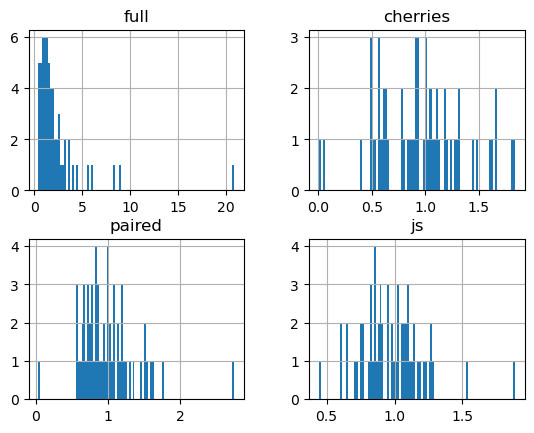

In [ ]:
from simulation.calculate_sigmas import *

null_dir=Path('/N/project/phyloML/rate_timescaling/data/tree_sims/l12.0/m11.400/h3')
# null_dir=Path('/N/project/phyloML/rate_timescaling/data/tree_sims/l3.5/m2.450/h1')
tree_file='null_trees_cagee.phy'
trait_file='null_trait_0.csv'

tree_file='trees_cagee.phy'
trait_file='trait_0.csv'
results=[]

with open(null_dir/tree_file) as trees, open( null_dir/ trait_file) as traits:
    
    for tree, trait in zip(trees,traits):
        # print(tree)
        tree = dendropy.Tree.get_from_string(tree, schema="newick", rooting="force-rooted")
        s = np.array(
            list(
                map(float, 
                     (tt for tt in trait.strip().split(',') if tt!='')
                   )
                )
        )[np.newaxis,:]
        # print(len(tree),s.shape)
        pic = PIC(t=tree, chars = s, max_replicates=1,calculate_pic= BrownianBridgePIC)
        res = dict(
            zip(
                ("full", "cherries", "paired"),
                (pic.estimate_sigmas()[0], pic.cherries_sigma()[0], pic.paired_lineages_sigma()[0]),
            )
        )
        pic = PIC(tree, s, max_replicates=1, calculate_pic = JamesSteinPIC)
        res['js'] = pic.estimate_sigmas()[0]
        results.append(res)
results=pd.DataFrame(results)
results.hist(bins=100)

(results-1).abs().mean()

full        0.446064
cherries    0.727313
paired      0.562160
js          0.466853
dtype: float64

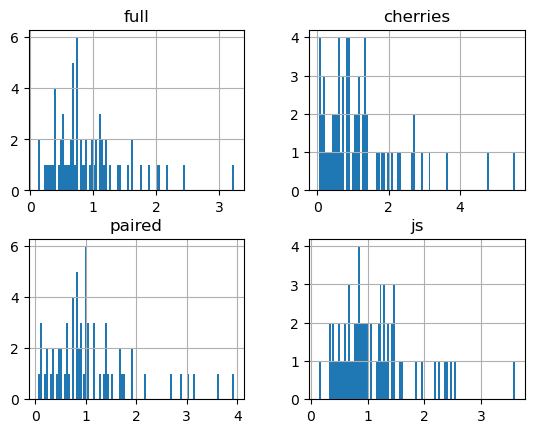

In [ ]:
from simulation.calculate_sigmas import *

null_dir=Path('/N/project/phyloML/rate_timescaling/data/tree_sims/l3.5/m2.450/h1')
tree_file='null_trees_cagee.phy'
trait_file='null_trait_0.csv'
results=[]

with open(null_dir/tree_file) as trees, open( null_dir/ trait_file) as traits:
    
    for tree, trait in zip(trees,traits):
        # print(tree)
        tree = dendropy.Tree.get_from_string(tree, schema="newick", rooting="force-rooted")
        s = np.array(
            list(
                map(float, 
                     (tt for tt in trait.strip().split(',') if tt!='')
                   )
                )
        )[np.newaxis,:]
        # print(len(tree),s.shape)
        pic = PIC(t=tree, chars = s, max_replicates=1,calculate_pic= BrownianBridgePIC)
        res = dict(
            zip(
                ("full", "cherries", "paired"),
                (pic.estimate_sigmas()[0], pic.cherries_sigma()[0], pic.paired_lineages_sigma()[0]),
            )
        )
        pic = PIC(tree, s, max_replicates=1, calculate_pic = JamesSteinPIC)
        res['js'] = pic.estimate_sigmas()[0]
        results.append(res)
results=pd.DataFrame(results)
results.hist(bins=100)
(results-1).abs().mean()

In [ ]:
pics = np.load(null_dir/'no_ils/pic_bbridge_sigmas20_ngenes1_full.npy')[:,0]
pics,results.full

(array([2.156541  , 1.15084555, 2.43838029, 0.4824628 , 0.50716917,
        1.17142704, 1.77724449, 0.6801605 , 3.24472175, 0.79491614,
        0.31942985, 0.66027866, 1.60681189, 0.24988433, 0.99867546,
        0.13080983, 1.10908243, 1.53791892, 0.30178268, 0.57415323,
        0.90534935, 0.64736334, 0.40594568, 0.54458303, 0.68088711,
        1.11722205, 0.48246018, 0.12578733, 1.19350421, 0.97835201,
        0.38873632, 0.72267749, 0.83854804, 0.67454714, 0.38639209,
        0.70506559, 0.51987309, 0.64140989, 1.04641013, 1.14293842,
        0.74924094, 0.37218667, 0.79461498, 0.27103931, 0.74797446,
        0.45052134, 0.86113307, 1.4242728 , 1.19884803, 1.59566997,
        0.74283211, 1.01989096, 0.73677932, 1.05230519, 0.94082636,
        0.50477584, 0.74795135, 2.02408047, 1.25148778, 1.11314291,
        0.89652451, 0.66837135, 0.60956246, 1.39185759, 2.03603891,
        0.37556427, 1.90325855]),
 0      7.060323
 1      5.613159
 2      4.311741
 3      3.982457
 4      2.7724

(sigma           0.446064
 sigma_cherry    0.636483
 sigma_js        0.466853
 sigma_paired    0.555036
 dtype: float64,
 sigma           0.933157
 sigma_cherry    0.999295
 sigma_js        1.117966
 sigma_paired    1.002204
 dtype: float64)

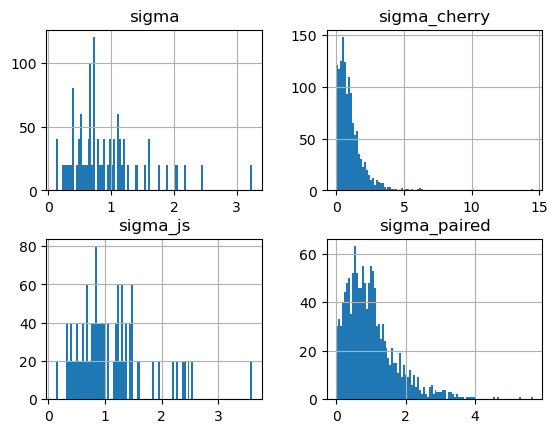

In [ ]:
xq=x.query('lam==3.5 & mu ==2.450 & h==1')[[c for c in x if c.startswith('sig')]]
xq.hist(bins=100);
(xq-1).abs().mean(),xq.mean()

In [ ]:
a2 = nvc / (nvc.index - 1)
a2.describe()

### Compute $\sigma^2$ on all available contrasts.

In [ ]:
max_replicates = 100
pic = PIC(t, s, max_replicates=max_replicates)
res = dict(
    zip(
        ("full", "cherries", "paired"),
        (pic.estimate_sigmas(), pic.cherries_sigma(), pic.paired_lineages_sigma()),
    )
)
{k: (v.mean(), v.std()) for k, v in res.items()}

In [ ]:
# print(njobs, os.cpu_count())
ngenes = 10
ils = True


def process(dirname):
    return process_dir_object(
        dirname, overwrite=False, ngenes=ngenes, max_replicates=max_rep, ils=ils
    )


# for h in (7,1,3,5):
#     for d in parent_dir.glob(f'*/*/h{h}') :
#         process(d)

with Parallel(n_jobs=njobs) as parallel:
    skipped = parallel(
        delayed(process)(d) for h in (3, 5, 7, 1) for d in parent_dir.glob(f"*/*/h{h}")
    )
print("skipped:", sum(skipped))

# df = pd.DataFrame.from_dict({(i,j): r[i][j]
#                            for i in r.keys()
#                            for j in r[i].keys()},
#                        orient='index')

In [ ]:

print(njobs, "ngenes", ngenes, os.cpu_count())
# for ils in (False,True):
ils = False
for js in (True,False):
    def process(dirname):
        return process_dir_object(
            dirname, overwrite=False, 
            ngenes=ngenes, 
            max_replicates=max_rep, 
            ils = ils,
            js = js,
        )

    process(Path("/N/project/phyloML/rate_timescaling/data/tree_sims/l5.0/m1.500/h3"))

    # with Parallel(n_jobs=njobs) as parallel:
    #     skipped = parallel(
    #         delayed(process)(d)
    #         for h in (3, 5, 7, 1)
    #         for d in parent_dir.glob(f"*/*/h{h}")
    #     )
    print("skipped:", sum(skipped))

# df = pd.DataFrame.from_dict({(i,j): r[i][j]
#                            for i in r.keys()
#                            for j in r[i].keys()},
#                        orient='index')

In [ ]:
for eps in np.linspace(0, 2.2, 20):
    pic = PIC(t, s, max_replicates=max_replicates, eps=eps)
    res = dict(
        zip(
            ("full", "cherries", "paired"),
            (pic.estimate_sigmas(), pic.cherries_sigma(), pic.paired_lineages_sigma()),
        )
    )
    r[eps] = {k: {"mean": v.mean(), "std": v.std()} for k, v in res.items()}
    full[(eps, "lam", "mu")] = res
# df = pd.DataFrame.from_dict({(i,j): r[i][j]
#                            for i in r.keys()
#                            for j in r[i].keys()},
#                        orient='index')

In [ ]:
df = pd.DataFrame.from_dict(
    {(i, j): full[i][j] for i in full.keys() for j in full[i].keys()},
).unstack()  # .reset_index()
df.index = df.index.droplevel(-1)
df = df.reset_index()
df.columns = ["eps", "Algorithm", "sigma_sq"]
df["Absolute Error"] = np.abs(df["sigma_sq"] - 1)

In [ ]:
# fig, axes = plt.subplots(1, 2)
for metric in ("sigma_sq", "Absolute Error"):
    sns.relplot(
        data=df,
        hue="Algorithm", 
        x="eps", 
        y=metric, 
        kind="line", errorbar="ci"
    )  # , ax=axes[0])
    plt.yscale("log")
    plt.xlabel(r"$\epsilon$")
    plt.savefig(d / f"tree{tree_ix}_ils_{metric}.png")
df.describe()

# Find the best $\epsilon$ (in coalescent units) to prune contrasts for estimating $\sigma^2$.

## Plot by $\epsilon$

In [24]:
z = []

ngenes = 1
max_rep = 20
# data/tree_sims/l10.0/m9.500/h1/no_ils/pic_dendropy_sigmas20_ngenes1_paired_0.8.npy
parent_dir = Path("/N/project/phyloML/rate_timescaling/data/tree_sims")

for eps in np.arange(0, 1, .1):
    for h in (7, 1, 3, 5):
        for d in parent_dir.glob(f"*/*/h{h}/no_ils"):
            for alg in ('full', 'cherries', 'paired'):
                infile = d / (f"pic_dendropy_sigmas{max_rep}_ngenes{ngenes}_{alg}"+(f"_{eps:.1f}" if eps else "") + ".npy")
                if infile.exists():
                    x = pd.DataFrame(np.load(infile).ravel(), columns  = ['sig'])
                    x['tree_no'] = np.repeat(np.arange(len(x) // max_rep), max_rep)
                    x["lam"], x["mu"] = map(float, rx.findall(str(d))[0])
                    x["h"] = h
                    x["alg"] = alg
                    x['eps'] = eps
                    z.append(x)
z = pd.concat(z, ignore_index = True)
# z.to_csv(parent_dir/'pic_dendropy_pruning.csv.gz')
z

,sig,tree_no,lam,mu,h,alg,eps
0,1.109160,0,4.5,4.275,7,full,0.0
1,1.109160,0,4.5,4.275,7,full,0.0
2,1.109160,0,4.5,4.275,7,full,0.0
3,1.109160,0,4.5,4.275,7,full,0.0
4,1.109160,0,4.5,4.275,7,full,0.0
...,...,...,...,...,...,...,...
15596755,0.017552,94,3.0,2.550,5,paired,0.9
15596756,0.094451,94,3.0,2.550,5,paired,0.9
15596757,0.301566,94,3.0,2.550,5,paired,0.9
15596758,0.068087,94,3.0,2.550,5,paired,0.9


In [38]:
z.dropna()

,sig,tree_no,lam,mu,h,alg,eps,mae
0,1.109160,0,4.5,4.275,7,full,0.0,0.109160
1,1.109160,0,4.5,4.275,7,full,0.0,0.109160
2,1.109160,0,4.5,4.275,7,full,0.0,0.109160
3,1.109160,0,4.5,4.275,7,full,0.0,0.109160
4,1.109160,0,4.5,4.275,7,full,0.0,0.109160
...,...,...,...,...,...,...,...,...
15596755,0.017552,94,3.0,2.550,5,paired,0.9,0.982448
15596756,0.094451,94,3.0,2.550,5,paired,0.9,0.905549
15596757,0.301566,94,3.0,2.550,5,paired,0.9,0.698434
15596758,0.068087,94,3.0,2.550,5,paired,0.9,0.931913


In [53]:
z.query('alg=="paired" & eps==0.9').mae.agg(['mean','std','count'])

mean          0.629511
std           0.770001
count    422160.000000
Name: mae, dtype: float64

In [50]:
z.dropna().groupby(['alg','eps']).sig.count()#.value_counts()#.value_counts()

alg       eps
cherries  0.0    701980
          0.1    436080
          0.2    701980
          0.3    444800
          0.4    563900
          0.5    613040
          0.6    701980
          0.7    297880
          0.8    315120
          0.9    422160
full      0.0    701980
          0.1    431360
          0.2    688180
          0.3    432360
          0.4    545680
          0.5    589560
          0.6    671400
          0.7    282880
          0.8    298500
          0.9    398920
paired    0.0    701980
          0.1    436080
          0.2    701980
          0.3    444800
          0.4    563900
          0.5    613040
          0.6    701980
          0.7    297880
          0.8    315120
          0.9    422160
Name: sig, dtype: int64

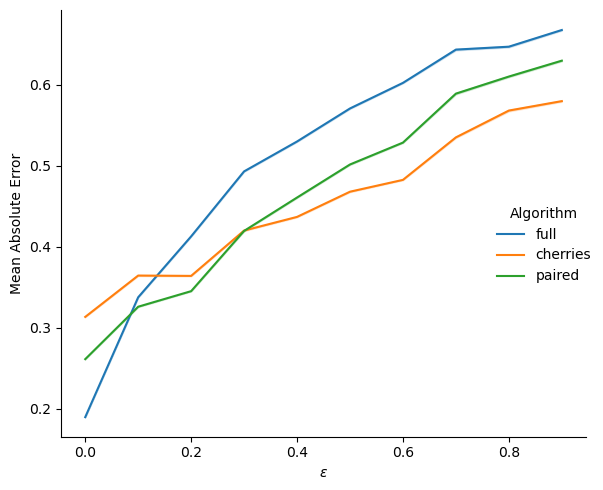

In [59]:
z['mae'] = (z.sig-1).abs()

sns.relplot(
        data=z.rename(columns={'alg':'Algorithm'}) ,
        hue = "Algorithm",
        x = "eps",
        y = "mae",
        kind = "line",
        err_style = 'band',
        errorbar = ("ci", 50), #'sd', #
        # col='lam',row='mu'
    )  # , ax=axes[0])
plt.ylabel('Mean Absolute Error')
# plt.yscale("log")
plt.xlabel(r"$\epsilon$")
# plt.ylim([0,1])
plt.tight_layout()
plt.savefig(figdir / f"no_ils_eps_v_err.png")

In [26]:
zz = z

In [ ]:
tree_stats = []

for h in (7, 1, 3, 5):
    for d in parent_dir.glob(f"*/*/h{h}"):
        # infile = d/f'pic_sigmas{max_rep}_ngenes{ngenes}.pd.gz'
        taufile = d / "no_ils/taus.npy"
        x = pd.DataFrame()
        rhofile = d / "rhos.npy"
        if rhofile.exists():
            if taufile.exists():
                taus = np.load(taufile)
                n_trees = taus.shape[0]
                x["taus"] = taus[:, :max_rep].ravel()
                x["tree_no"] = np.arange(n_trees).repeat(max_rep, axis=0)
                x["rep_no"] = np.tile(np.arange(max_rep), n_trees)

            x["lam"], x["mu"] = map(float, rx.findall(str(d))[0])
            rhos = np.load(rhofile).repeat(max_rep, axis=0)
            # print(rhos.shape,np.load(taufile)[:,:max_rep].shape)
            x["h"] = h
            x["bl_corr"] = rhos[:, 0].ravel()
            x["n"] = rhos[:, 1].ravel()

        tree_stats.append(x)
tree_stats = pd.concat(tree_stats)

In [ ]:
tree_stats

TODO: plot PIC performance vs fraction of short branches instead of $\rho$

In [ ]:
cols = ["lam", "mu", "h", "tree_no"]
# z=z.set_index(cols)
tree_stats = tree_stats.set_index(cols)

# res = z.query('h>1').join(tree_stats.query('h>1 & 4<n<2000'))

In [ ]:
stats_means = tree_stats.drop(columns="rep_no").groupby(tree_stats.index.names).mean()

z_no_ils = z_no_ils.set_index(cols)

err_means = (
    z_no_ils.query("h>1")
    .dropna()
    .groupby([*z_no_ils.index.names, "epsilon", "Algorithm"])["Absolute Error"]
    .mean()
)

# z = z.set_index(cols)

# err_means = (z.query('h>1')
#              .dropna()
#              .groupby([*z.index.names,'epsilon','Algorithm'])['Absolute Error']
#              .mean())

In [ ]:
rep_mean = pd.merge(err_means.reset_index(), stats_means.reset_index())

In [ ]:
# sns.relplot(data = rep_mean.query('epsilon<1.5 & 10<n<2000'),
sns.relplot(
    data=rep_mean.query("10<n<2000"),
    row="Algorithm",
    hue="epsilon",
    y="Absolute Error",
    # col='lam',
    x="bl_corr",
    kind="scatter",
    # errorbar = 'ci',
)  # , ax=axes[0])
plt.yscale("log")
plt.xlabel(r"$\rho$")
# plt.title(fr'$\lambda={l},\mu={m},H={h}$')
plt.tight_layout()
# plt.savefig(figdir / f'ils_{ngenes}gene_10_lt_n_lt_2000.png')
plt.savefig(figdir / f"no_ils_low_eps_10_lt_n_lt_2000.png")

In [ ]:
sns.relplot(
    data=rep_mean.query("epsilon<1.5 & 10<n<2000"),
    row="Algorithm",
    hue="epsilon",
    y="Absolute Error",
    # col='lam',
    x="n",
    kind="scatter",
    # errorbar = 'ci',
)  # , ax=axes[0])
plt.yscale("log")
plt.xlabel(r"$n$")
# plt.title(fr'$\lambda={l},\mu={m},H={h}$')
plt.tight_layout()
plt.savefig(figdir / f"no_ils_n_low_eps_10_lt_n_lt_2000.png")

In [ ]:
zz = z.query("lam==4.5 & mu==4.275 & h==7")

# fig, axes = plt.subplots(1, 2)
# for metric in ('sigma_sq', 'Absolute Error'):
for (l, m, h), zz in z.groupby(["lam", "mu", "h"]):
    sns.relplot(
        data=zz.reset_index(),
        hue="Algorithm",
        x="epsilon",
        y="Absolute Error",
        kind="line",
        errorbar="ci",
        # col='lam',row='mu'
    )  # , ax=axes[0])
    plt.yscale("log")
    plt.xlabel(r"$\epsilon$")
    plt.title(rf"$\lambda={l},\mu={m},H={h}$")
    plt.tight_layout()
    plt.savefig(figdir / f"ils_{metric}_l{l}_m{m}_h{h}.png")


In [ ]:
rep_mean.query(".9<epsilon<1.2")

In [ ]:
sns.relplot(
    data=z_no_ils.reset_index(),
    hue="Algorithm",
    x="epsilon",
    y="Absolute Error",
    kind="line",
    errorbar="ci",
    # col='lam',row='mu'
)  # , ax=axes[0])
plt.yscale("log")
plt.xlabel(r"$\epsilon$")
# plt.title(fr'$\lambda={l},\mu={m},H={h}$')
plt.tight_layout()
# plt.savefig(figdir / f'ils_{ngenes}genes_all.png')
plt.savefig(figdir / f"no_ils_all.png")

In [ ]:
sns.relplot(
    data=z.query("h>1").reset_index(),
    hue="Algorithm",
    x="epsilon",
    y="Absolute Error",
    kind="line",
    errorbar="ci",
    # col='lam',row='mu'
)  # , ax=axes[0])
plt.yscale("log")
plt.xlabel(r"$\epsilon$")
# plt.title(fr'$\lambda={l},\mu={m},H={h}$')
plt.tight_layout()
plt.savefig(figdir / f"ils_all_h_lt_1.png")

In [ ]:
z = pd.read_pickle(parent_dir / "subsampling_pic.pd.gz")
z

In [ ]:
df = z.reset_index()  # .query('Algorithm=="full" & epsilon<.2')
df["r"] = df["lam"] - df["mu"]
df["rho"] = df["mu"] / df["lam"]
df

In [ ]:
df.query("rho>.9 & h>1").groupby("Algorithm").mean()

In [ ]:
df = df.set_index(["lam", "mu", "h", "r", "rho", "tree_no"])
ix = (
    df.query("epsilon<.1")["Absolute Error"] < df.query("epsilon>=.1")["Absolute Error"]
)

When $r, \lambda, \mu$ are low, and $H$ is high, full$_0$ is better than full$_1$.  Can we quantify the amount of ILS? Number of short internal branches? Fraction of short internal branches?

In [ ]:
ix[ix].reset_index().describe()

In [ ]:
ix[~ix].reset_index().describe()

In [ ]:
full_err = z.query('Algorithm=="full"').groupby("epsilon")["Absolute Error"].mean()
full_err.plot()

In [ ]:
t = parent_trees[0]
chars = s0
if not isinstance(chars, dendropy.ContinuousCharacterMatrix):
    taxa = sorted(t.taxon_namespace)
    chars = dict(zip(taxa, map(list, chars.T)))
    # print(chars)
    chars = dendropy.ContinuousCharacterMatrix.from_dict(chars)
print(len(chars), len(taxa), chars.sequence_size)
subsigs = []
for _ in range(10):
    st = subsample_tree_random(t)
    subsigs.append(estimate_sigmas(st, s0))
print(subsigs)

In [ ]:
st = subsample_tree_random(t, eps=0.1)

In [ ]:
taus = np.load(d / "no_ils/taus.npy")

i = 0
samp = samples[tree_ix][i]
(
    len(samp),
    taus[tree_ix, i],
    samp.mean(),
    samp.std(),
    samp.min(),
    samp.max(),
    len(samples),
    len(parent_trees),
    samples[0].shape,
)

In [ ]:

t = parent_trees[tree_ix]

t.as_string("newick")[5:] == t.as_string("newick", suppress_rooting=True)


treestr = StringIO(
    t.as_string("newick", suppress_rooting=True, suppress_leaf_taxon_labels=True)
)
pt = Phylo.read(treestr, format="newick")
Phylo.draw(pt)

# calculate all PIC $\hat{\sigma}^2$

In [ ]:
max_rep = 20
ngenes = 10


In [ ]:
def process_dir(
    d: Path,
    overwrite: bool = True,
    ils=False,
    func="full",
):
    suffix = "_" + func
    if func == "full":
        func = estimate_sigmas
    elif func == "paired":
        func = paired_lineages_sigma
    elif func == "cherries":
        func = cherries_sigma

    tree_file = d / "parent_trees_4plus_pos_edges.phy"
    if ils:
        samp_file = d / f"samples_ngenes{ngenes}.npz"
        outfile = d / f"pic_sigmas{max_rep}_ngenes{ngenes}{suffix}.npy"
    else:
        samp_file = d / "no_ils/samples_ngenes1.npz"
        outfile = d / f"no_ils/pic_sigmas{max_rep}{suffix}.npy"
    if (
        (not overwrite and outfile.exists())
        or not samp_file.exists()
        or not tree_file.exists()
    ):
        return 1
    # print(samp_file)

    with open(tree_file, "r") as f:
        parent_trees = [
            dendropy.Tree.get_from_string(t, "newick", rooting="force-rooted")
            for t in f
        ]
    npzfile = np.load(samp_file)
    n = len(npzfile.files)
    samples = [v / (ils and ngenes or 1) for v in npzfile.values()]
    sigmas = np.empty((n, max_rep))
    for i, args in enumerate(zip(parent_trees, samples)):
        try:
            # print(args[1].shape)
            res = func(*args, max_replicates=max_rep)
            sigmas[i, :] = res
        except ZeroDivisionError:
            print("error", i, args[0])
    np.save(outfile, sigmas)
    return 0


njobs = 32
print(njobs, os.cpu_count())

for func in ["full", "paired", "cherries"]:

    def process(dirname):
        return process_dir(
            dirname,
            overwrite=True,
            ils=True,
            func=func,
        )

    with Parallel(n_jobs=njobs) as parallel:
        skipped = parallel(
            delayed(process)(d)
            for h in (7, 1, 3, 5)
            for d in parent_dir.glob(f"*/*/h{h}")
        )
    print("skipped:", sum(skipped), func)


## Calculate *ALL* PIC (BD trees)
Use new Brownian Bridge estimator.

In [9]:
max_rep = 20
ngenes= 1

def process_dir_object(
    d: Path,
    overwrite: bool = False,
    ils=False,
    eps=None,
    ngenes=1,
    calculate_pic=continuous.PhylogeneticIndependentContrasts,
    max_replicates=None,
):
    tree_file = d / "parent_trees_4plus_pos_edges.phy"
    if ils:
        samp_file = d / f"samples_ngenes{ngenes}.npz"
        outdir = d
    else:
        samp_file = d / "no_ils/samples_ngenes1.npz"
        if ngenes != 1:
            raise ValueError("ngenes must be 1 unless ILS is True")
        outdir = d / "no_ils"
    outfile = outdir / (
        f"pic_bbridge_sigmas{max_rep}_ngenes{ngenes}_full{'_{eps}' if eps else ''}.npy"
    )
    # print(outfile)

    if (
        (not overwrite and outfile.exists())
        or not samp_file.exists()
        or not tree_file.exists()
    ):
        return 1
    # print(samp_file)

    with open(tree_file, "r") as f:
        parent_trees = [
            dendropy.Tree.get_from_string(t, "newick", rooting="force-rooted")
            for t in f
        ]
    npzfile = np.load(samp_file)
    n = len(npzfile.files)
    samples = [v / ngenes for v in npzfile.values()]
    sigmas = np.empty((3, n, max_rep))
    for i, (t, s) in enumerate(zip(parent_trees, samples)):
        try:
            pic = PIC(
                t=t,
                chars=s,
                calculate_pic=calculate_pic,
                max_replicates=max_replicates,
                eps=eps,
            )
            res = np.vstack(
                (
                    pic.estimate_sigmas(),
                    pic.cherries_sigma(),
                    pic.paired_lineages_sigma(),
                )
            )
            sigmas[:, i, :] = res
        except ZeroDivisionError:
            print("error", i, args[0])
    for suffix, sig in zip(("full", "cherries", "paired"), sigmas):
        outfile = f"pic_bbridge_sigmas{max_rep}_ngenes{ngenes}_{suffix}{'_{eps}' if eps else ''}.npy"
            
        np.save(outdir / outfile, sig)
    return 0


njobs = 16
print(njobs, os.cpu_count(), parent_dir)


def process(dirname):
    return process_dir_object(
        dirname,
        overwrite = False,
        ngenes = ngenes,
        max_replicates=max_rep,
        ils=False,
        calculate_pic=BrownianBridgePIC,
    )

print(parent_dir)
# for h in (7,1,3,5):
#     for d in parent_dir.glob(f'tree_sims/*/*/h{h}') :
#         print(d)
#         process(d)

with Parallel(n_jobs=njobs, timeout=30) as parallel:
    skipped = parallel(
        delayed(process)(d) for h in (7, 5, 3, 1) for d in parent_dir.glob(f"tree_sims/*/*/h{h}")
        # delayed(process)(d) for d in parent_dir.glob("tree_sims/*/*/h*")
    )
print("skipped:", sum(skipped))


16 128 /N/project/phyloML/rate_timescaling/data
/N/project/phyloML/rate_timescaling/data
skipped: 448


Use dendropy's PIC implementation:

In [4]:
max_rep = 20
ngenes= 1

def process_dir_object(
    d: Path,
    overwrite: bool = False,
    ils = False,
    eps = None,
    ngenes = 1,
    calculate_pic = continuous.PhylogeneticIndependentContrasts,
    max_replicates = None,
):
    tree_file = d / "parent_trees_4plus_pos_edges.phy"
    if ils:
        samp_file = d / f"samples_ngenes{ngenes}.npz"
        outdir = d
    else:
        samp_file = d / "no_ils/samples_ngenes1.npz"
        if ngenes != 1:
            raise ValueError("ngenes must be 1 unless ILS is True")
        outdir = d / "no_ils"
    outfile = outdir / (
        f"pic_dendropy_sigmas{max_rep}_ngenes{ngenes}_full{'_{eps}' if eps else ''}.npy"
    )
    # print(outfile)

    if (
        (not overwrite and outfile.exists())
        or not samp_file.exists()
        or not tree_file.exists()
    ):
        return 1

    with open(tree_file, "r") as f:
        parent_trees = [
            dendropy.Tree.get_from_string(t, "newick", rooting="force-rooted")
            for t in f
        ]
    npzfile = np.load(samp_file)
    n = len(npzfile.files)
    samples = [v / ngenes for v in npzfile.values()]
    sigmas = np.empty((3, n, max_rep))
    for i, (t, s) in enumerate(zip(parent_trees, samples)):
        try:
            pic = PIC(
                t=t,
                chars=s,
                calculate_pic=calculate_pic,
                max_replicates=max_replicates,
                eps=eps,
            )
            res = np.vstack(
                (
                    pic.estimate_sigmas(),
                    pic.cherries_sigma(),
                    pic.paired_lineages_sigma(),
                )
            )
            sigmas[:, i, :] = res
        except ZeroDivisionError:
            print("error", i, args[0])
    for suffix, sig in zip(("full", "cherries", "paired"), sigmas):
        outfile = f"pic_dendropy_sigmas{max_rep}_ngenes{ngenes}_{suffix}{'_{eps}' if eps else ''}.npy"
            
        np.save(outdir / outfile, sig)
    return 0


njobs = 4
print(njobs, os.cpu_count(), parent_dir)


def process(dirname):
    return process_dir_object(
        dirname,
        overwrite = False,
        ngenes = ngenes,
        max_replicates = max_rep,
        ils = False,
    )

print(parent_dir)
# for h in (5, 7, 1, 3):
#     for d in parent_dir.glob(f'tree_sims/*/*/h{h}') :
#         print(d)
#         process(d)

with Parallel(n_jobs=njobs, timeout=3600) as parallel:
    skipped = parallel(
        delayed(process)(d) for h in (5, 3, 1, 7) for d in parent_dir.glob(f"tree_sims/*/*/h{h}")
    )
print("skipped:", sum(skipped))


4 128 /N/project/phyloML/rate_timescaling/data
/N/project/phyloML/rate_timescaling/data
skipped: 448


Repeat with James-Stein estimator.

In [ ]:
max_rep = 20


def process_dir_object(
    d: Path,
    overwrite: bool = True,
    ils=False,
    eps=None,
    ngenes=1,
    calculate_pic=continuous.PhylogeneticIndependentContrasts,
    max_replicates=None,
):
    tree_file = d / "parent_trees_4plus_pos_edges.phy"
    if ils:
        samp_file = d / f"samples_ngenes{ngenes}.npz"
        outdir = d
    else:
        samp_file = d / "no_ils/samples_ngenes1.npz"
        if ngenes != 1:
            raise ValueError("ngenes must be 1 unless ILS is True")
        outdir = d / "no_ils"
    
    already_written=0
    for suffix in ("full", "cherries", "paired"):
        outfile = Path(
        f"pic_js_sigmas{max_rep}_ngenes{ngenes}_{suffix}"
        + (f"_{eps}" if eps else "")
        + ".npy"
        )
        if outfile.exists(): already_written+=1
    if ( not overwrite and already_written==3
        or not samp_file.exists()
        or not tree_file.exists()
    ):
        return 1
    # print(samp_file)

    with open(tree_file, "r") as f:
        parent_trees = [
            dendropy.Tree.get_from_string(t, "newick", rooting="force-rooted")
            for t in f
        ]
    npzfile = np.load(samp_file)
    n = len(npzfile.files)
    samples = [v / ngenes for v in npzfile.values()]
    sigmas = np.empty((3, n, max_rep))
    for i, (t, s) in enumerate(zip(parent_trees, samples)):
        try:
            pic = PIC(
                t=t,
                chars=s,
                calculate_pic=calculate_pic,
                max_replicates=max_replicates,
                eps=eps,
            )
            res = np.vstack(
                (
                    pic.estimate_sigmas(),
                    pic.cherries_sigma(),
                    pic.paired_lineages_sigma(),
                )
            )
            sigmas[:, i, :] = res
        except ZeroDivisionError:
            print("error", i, args[0])
    for suffix, sig in zip(("full", "cherries", "paired"), sigmas):
        outfile = (
            f"pic_js_sigmas{max_rep}_ngenes{ngenes}_{suffix}"
            + (f"_{eps}" if eps else "")
            + ".npy"
        )
        np.save(outdir / outfile, sig)
    return 0


njobs = 32
ngenes=1
print(njobs, os.cpu_count(), parent_dir)


def process(dirname):
    return process_dir_object(
        dirname,
        overwrite=False,
        ngenes=ngenes,
        max_replicates=max_rep,
        ils=False,
        calculate_pic=JamesSteinPIC,
    )


# for h in (7,1,3,5):
#     for d in parent_dir.glob(f'*/*/h{h}') :
#         process(d)

with Parallel(n_jobs=njobs) as parallel:
    skipped = parallel(
        delayed(process)(d) for h in (7,  3, 5, 1,) for d in Path('/N/project/phyloML/rate_timescaling/data/tree_sims').glob(f"*/*/h{h}")
    )
print("skipped:", sum(skipped))

In [ ]:
from simulation.calculate_sigmas import *


max_rep = 20


def process_dir_object(
    d: Path,
    overwrite: bool = True,
    ils=False,
    eps=None,
    ngenes=1,
    calculate_pic=continuous.PhylogeneticIndependentContrasts,
    max_replicates=None,
):
    tree_file = d / "parent_trees_4plus_pos_edges.phy"
    if ils:
        samp_file = d / f"samples_ngenes{ngenes}.npz"
        outdir = d
    else:
        samp_file = d / "no_ils/samples_ngenes1.npz"
        if ngenes != 1:
            raise ValueError("ngenes must be 1 unless ILS is True")
        outdir = d / "no_ils"
    outfile = Path(
        f"pic_js_sigmas{max_rep}_ngenes{ngenes}_full_v2"
        + (f"_{eps}" if eps else "")
        + ".npy"
    )

    if (
        (not overwrite and outfile.exists())
        or not samp_file.exists()
        or not tree_file.exists()
    ):
        return 1
    # print(samp_file)

    with open(tree_file, "r") as f:
        parent_trees = [
            dendropy.Tree.get_from_string(t, "newick", rooting="force-rooted")
            for t in f
        ]
    npzfile = np.load(samp_file)
    n = len(npzfile.files)
    samples = [v / ngenes for v in npzfile.values()]
    sigmas = np.empty((1, n, max_rep))
    for i, (t, s) in enumerate(zip(parent_trees, samples)):
        try:
            pic = PIC(
                t=t,
                chars=s,
                calculate_pic=calculate_pic,
                max_replicates=max_replicates,
                eps=eps,
            )
#             we've verified that cherries/paired doesn't change under JS
            
            sigmas[:, i, :] = pic.estimate_sigmas()
        except ZeroDivisionError:
            print("error", i, args[0])

    outfile = (
        f"pic_js_sigmas{max_rep}_ngenes{ngenes}_full_v2"
        + (f"_{eps}" if eps else "")
        + ".npy"
    )
    np.save(outdir / outfile, sigmas[0])
    return 0


njobs = 8
print(njobs, os.cpu_count(), parent_dir)


def process(dirname):
    return process_dir_object(
        dirname,
        overwrite=False,
        ngenes=ngenes,
        max_replicates=max_rep,
        ils=False,
        calculate_pic=JamesSteinPIC,
    )


# for h in (7,1,3,5):
#     for d in parent_dir.glob(f'*/*/h{h}') :
#         process(d)

with Parallel(n_jobs=njobs) as parallel:
    skipped = parallel(
        delayed(process)(d) for h in (7, 3, 5,1) for d in parent_dir.glob(f"*/*/h{h}")
    )
print("skipped:", sum(skipped), func)

In [ ]:
def process(dirname):
    return process_dir_object(
        dirname,
        overwrite=False,
        ngenes=ngenes,
        max_replicates=max_rep,
        ils=True,
        epsilon=1,
    )


# for h in (7,1,3,5):
#     for d in parent_dir.glob(f'*/*/h{h}') :
#         process(d)

with Parallel(n_jobs=njobs) as parallel:
    skipped = parallel(
        delayed(process)(d) for h in (7, 1, 3, 5) for d in parent_dir.glob(f"*/*/h{h}")
    )

In [ ]:
t = parent_trees[71].clone()
# t.scale_edges(10)
# print(t)
for e in t.edges():
    if e.length == 0:
        print(e.length)
        e.length = 1e-9
print(min([e.length for e in t.edges() if e.length > 0]))
naive_s = estimate_sigmas(t, samples[71], max_replicates=max_rep)
naive_s.shape

In [ ]:
max_rep = 20
pic_sigmas = []
for t, samp in zip(parent_trees, samples):
    t = t.clone()
    s = estimate_sigmas(t, samp, max_replicates=max_rep)
    pic_sigmas.append(s)
# torch.save(s, d/f'no_ils/pic_sigmas{max_rep}.pty')


In [ ]:
s_ils = list(np.load(d / f"pic_sigmas{max_rep}.npz").values())


# Visualize Results
### PIC without ILS
(no pruning.)

TODO: add metrics for species tree internal branch lengths;  

In [ ]:
# gather all PIC predictions

vals = {}
max_rep=20
ngenes=1
for h in (7, 1, 3, 5):
    for d in parent_dir.glob(f"tree_sims/l*/m*/h{h}"):
        picfile = d / f"no_ils/pic_bbridge_sigmas{max_rep}_ngenes{ngenes}_full.npy"## f"no_ils/pic_sigmas{max_rep}.npy"
        picfile2 = d / f"no_ils/pic_bbridge_sigmas{max_rep}_ngenes{ngenes}_cherries.npy" #f"no_ils/pic_sigmas{max_rep}_cherries.npy"
        picfile3 = d / f"no_ils/pic_bbridge_sigmas{max_rep}_ngenes{ngenes}_paired.npy" #f"no_ils/pic_sigmas{max_rep}_paired.npy"
        taufile = d / "no_ils/taus.npy"
        if taufile.exists() and picfile.exists():
            pic_sigmas = np.load(picfile)
            taus = np.load(taufile)
            rhos = np.load(d / "rhos.npy").repeat(max_rep, axis=0)
            sigs = np.array(pic_sigmas).ravel()
            taus = taus[: len(pic_sigmas), :max_rep].ravel()
            lam, mu = map(float, rx.findall(str(d))[0])
            vals[(lam, mu, h, "tau")] = taus
            vals[(lam, mu, h, "rho")] = rhos[:, 0].ravel()

            vals[(lam, mu, h, "n")] = rhos[:, 1].ravel()

            vals[(lam, mu, h, "sigma")] = sigs
            vals[(lam, mu, h, "sigma_cherry")] = np.load(picfile2).ravel()
            vals[(lam, mu, h, "sigma_paired")] = np.load(picfile3).ravel()
            

### PIC without ILS (use Dendropy and Brownian Bridge class)
Note: here $\rho$ denotes the correlation between branch length and time, not the variable $\lambda/\mu$.

In [5]:
# gather all PIC predictions
vals = {}
max_rep = 20
ils = False
estimator = '_dendropy' # 
# estimator = '_bbridge'
ngenes = 10 if ils else 1

            

In [21]:

# alg= '_js' #
for h in (7, 1, 3, 5):
    for d in Path('/N/project/phyloML/rate_timescaling/data/tree_sims').glob(f"*/*/h{h}"):
        dirname=d / ("no_ils" if not ils else d )
        prefix = f"pic{estimator if not ils else ''}_sigmas{max_rep}_ngenes{ngenes}"
        js_new_picfile = dirname/ f"pic{'_js' if not ils else ''}_sigmas{max_rep}_ngenes{ngenes}_full_v2.npy"
        js_picfile = dirname/ f"pic{'_js' if not ils else ''}_sigmas{max_rep}_ngenes{ngenes}_full.npy"
        geig_file = dirname / f'BM_geig_ngenes{ngenes}_r{max_rep}.csv'
        ape_file = dirname / f'BM_ape_ngenes{ngenes}_r{max_rep}.csv'
        picfile = dirname/(prefix + "_full.npy")
        picfile2 = dirname/(prefix + "_cherries.npy")
        picfile3 = dirname/ (prefix + "_paired.npy")
        taufile = d / "no_ils/taus.npy"

        if taufile.exists() and picfile.exists() and js_picfile.exists():
            pic_sigmas = np.load(picfile)
            taus = np.load(taufile)
            max_trees = len(pic_sigmas)

            rhos = np.load(d / "rhos.npy")[:max_trees, :].repeat(max_rep, axis=0)
            taus = taus[:max_trees, :max_rep].ravel()
            lam, mu = map(float, rx.findall(str(d))[0])
            bl_stats = pd.read_pickle(d/'BL_stats.pd.gz').add_prefix('bl_')
            for c in bl_stats:
                vals[(lam, mu, h,c)] = bl_stats[c].repeat(max_rep)
            L,N = pic_sigmas.shape
            vals[(lam, mu, h, "tree_ix")] = np.repeat(range(L),N)
            # print(pic_sigmas.shape,vals[(lam, mu, h, "tree_ix")])
            vals[(lam, mu, h, "tau")] = taus
            vals[(lam, mu, h, "rho")] = rhos[:, 0].ravel() # ravel over max_rep dim

            vals[(lam, mu, h, "n")] = rhos[:, 1].ravel()
            vals[(lam, mu, h, "sigma_js")] = np.load(js_new_picfile).ravel()
            vals[(lam, mu, h, "sigma_js_old")] = np.load(js_picfile).ravel()

            vals[(lam, mu, h, "sigma")] = np.array(pic_sigmas).ravel()
            vals[(lam, mu, h, "sigma_cherry")] = np.load(picfile2).ravel()
            vals[(lam, mu, h, "sigma_paired")] = np.load(picfile3).ravel()

            if geig_file.exists():
                vals[(lam, mu, h, "sigma_geig")] = pd.read_csv(geig_file).to_numpy().ravel()
                vals[(lam, mu, h, "sigma_ape")] = pd.read_csv(ape_file).to_numpy().ravel()
            else:
                vals[(lam, mu, h, "sigma_ape")] = np.full(vals[(lam, mu, h, "sigma")].shape, np.nan)
                vals[(lam, mu, h, "sigma_geig")] = np.full(vals[(lam, mu, h, "sigma")].shape, np.nan)

            len(vals)

In [58]:
x = pd.Series(vals).unstack(-1)
x = (
    x.explode(
        x.columns.to_list()
        # ["n", "rho", 
        #  "sigma", "sigma_ape", "sigma_geig",
        #  "sigma_js", "sigma_js_old", 
        #  "sigma_cherry", "sigma_paired", 
        #  "tau", *bl_stats.columns]
    )
    # .astype(float)
)
x.index.names = ["lam", "mu", "h"]
# bl_stats

In [ ]:
x.query("lam == .5 & mu == .35 & h==3").tree_ix.value_counts() #.reset_index().set_index(["lam", "mu", "h",'tree_ix'])

In [ ]:
for k in vals:
    vals[k][c]=vals[k][c].repeat(max_rep)

In [8]:
if 'lam_minus_mu' not in x:
    x['lam_minus_mu'] = x.lam-x.mu
if 'mu_over_lam' not in x:
    x['mu_over_lam'] = x.mu / x.lam
x['h_lam_minus_mu'] = x.h * x.lam_minus_mu
x['h_mu_over_lam'] = x.h * x.mu_over_lam

x#.describe()

,lam,mu,h,bl_max,bl_mean,bl_median,bl_min,bl_q1,bl_q3,bl_std,...,sigma_geig,sigma_js,sigma_js_old,sigma_paired,tau,tree_ix,lam_minus_mu,mu_over_lam,h_lam_minus_mu,h_mu_over_lam
0,0.5,0.35,3,1.475406,0.487319,0.080153,0.050153,0.062098,0.768784,0.564491,...,2.264577,2.723137,2.717492,3.977077,0.164696,0.0,0.15,0.7,0.45,2.1
1,0.5,0.35,3,1.475406,0.487319,0.080153,0.050153,0.062098,0.768784,0.564491,...,0.454909,2.723137,2.717492,0.864262,-0.252534,0.0,0.15,0.7,0.45,2.1
2,0.5,0.35,3,1.475406,0.487319,0.080153,0.050153,0.062098,0.768784,0.564491,...,0.524809,2.723137,2.717492,0.621763,0.120777,0.0,0.15,0.7,0.45,2.1
3,0.5,0.35,3,1.475406,0.487319,0.080153,0.050153,0.062098,0.768784,0.564491,...,0.845259,2.723137,2.717492,0.917879,0.494088,0.0,0.15,0.7,0.45,2.1
4,0.5,0.35,3,1.475406,0.487319,0.080153,0.050153,0.062098,0.768784,0.564491,...,1.119087,2.723137,2.717492,1.964693,0.252534,0.0,0.15,0.7,0.45,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245605,13.0,11.70,3,2.381752,0.135704,0.049101,0.000066,0.014517,0.110116,0.342059,...,284.734687,0.949966,0.958792,1.038499,0.682930,99.0,1.30,0.9,3.90,2.7
245606,13.0,11.70,3,2.381752,0.135704,0.049101,0.000066,0.014517,0.110116,0.342059,...,19.020944,0.949966,0.958792,0.943912,0.115856,99.0,1.30,0.9,3.90,2.7
245607,13.0,11.70,3,2.381752,0.135704,0.049101,0.000066,0.014517,0.110116,0.342059,...,204.773096,0.949966,0.958792,1.158851,0.599956,99.0,1.30,0.9,3.90,2.7
245608,13.0,11.70,3,2.381752,0.135704,0.049101,0.000066,0.014517,0.110116,0.342059,...,392.276502,0.949966,0.958792,0.821787,0.669419,99.0,1.30,0.9,3.90,2.7


In [10]:

if ils:
    x.to_pickle(f"/N/project/phyloML/rate_timescaling/data/pic{estimator}_predictions_ils.pd.gz")
else:
    x.to_csv(f"/N/project/phyloML/rate_timescaling/data/pic{estimator}_predictions_no_ils.csv.gz")
    x.to_pickle(f"/N/project/phyloML/rate_timescaling/data/pic{estimator}_predictions_no_ils.pd.gz")
    print('wrote x')

wrote x


### Analyze and plot $\sigma^2$ results
$n$ is best predictor followed by $bl_{min},\tau,\rho$

In [61]:
from scipy.stats.mstats import winsorize


def rolling_mae(eps, x, limits=None, pred="sigma", var="rho"):
    """compute mae against a covariate.
    Optionally winsorize the limits=[a,b] quantiles."""
    x_grid = np.linspace(x[var].min() + eps, x[var].max() - eps, 100)

    deviation = np.abs(x[pred] - 1)
    if limits:
        y = [
            winsorize(
                deviation[(xx - eps < x[var]) & (x[var] < xx + eps)], limits=limits
            ).agg(['mean','std'])
            for xx in x_grid
        ]
    else:
            
        y = [
            (deviation[(xx - eps < x[var]) & (x[var] < xx + eps)]).agg(['mean','std'])
        for xx in x_grid            
        ]
    return pd.DataFrame(y, index=x_grid, )

### Load predictions

In [ ]:
# x_ils_g = pd.read_csv(
#     "/N/project/phyloML/rate_timescaling/data/tree_sims/geiger_res_ils.csv.gz"
# )
# x_ils_g.describe()

In [17]:
x_geig = pd.read_csv(
    "/N/project/phyloML/rate_timescaling/data/bm_geig_ape_preds.csv.gz"
)

if 'lam_minus_mu' not in x_geig:
    x_geig['lam_minus_mu'] = x_geig.lam-x_geig.mu
if 'mu_over_lam' not in x_geig:
    x_geig['mu_over_lam'] = x_geig.mu / x_geig.lam
    
x_geig.describe()

,tree_ix,sig_ape,sig_geig,se_ape,se_geig,lam,h,mu,r,rho,hr,hrho,lam_minus_mu,mu_over_lam
count,246960.000000,2.469300e+05,2.469300e+05,225879.000000,246930.000000,246960.000000,246960.000000,246960.000000,246960.000000,246960.000000,246960.000000,246960.000000,246960.000000,246960.000000
mean,42.410107,8.757284e+02,6.800343e+03,1.520483,0.305186,5.319080,3.516845,4.597336,0.721744,0.838099,2.015456,2.988423,0.721744,0.838099
std,26.607674,1.696916e+04,1.821099e+05,14.655615,0.189328,3.093286,2.065844,2.960654,0.707561,0.137300,1.957868,1.872637,0.707561,0.137300
min,0.000000,1.455617e-03,2.328342e-03,0.000589,0.031623,0.500000,1.000000,0.300000,0.025000,0.300000,0.025000,0.300000,0.025000,0.300000
25%,20.000000,1.004915e+00,1.758546e+00,0.219970,0.145095,3.000000,1.000000,2.250000,0.325000,0.800000,0.975000,0.950000,0.325000,0.800000
50%,41.000000,6.269817e+00,1.208224e+01,0.601828,0.267261,4.500000,3.000000,3.850000,0.500000,0.900000,1.625000,2.700000,0.500000,0.900000
75%,64.000000,2.141195e+01,4.074736e+01,1.384299,0.447214,7.000000,5.000000,6.300000,0.900000,0.950000,2.800000,4.500000,0.900000,0.950000
max,99.000000,1.442232e+06,3.062354e+07,4696.481918,0.707107,13.000000,7.000000,11.875000,7.700000,0.950000,53.900000,6.650000,7.700000,0.950000


In [6]:
x_no_ils = pd.read_csv(
    f"/N/project/phyloML/rate_timescaling/data/pic{estimator}_predictions_no_ils.csv.gz",
    index_col=0
).dropna()

x=x_no_ils.reset_index()

In [9]:
x.columns

Index(['lam', 'mu', 'h', 'bl_max', 'bl_mean', 'bl_median', 'bl_min', 'bl_q1',
       'bl_q3', 'bl_std', 'n', 'rho', 'sigma', 'sigma_ape', 'sigma_cherry',
       'sigma_geig', 'sigma_js', 'sigma_js_old', 'sigma_paired', 'tau',
       'tree_ix', 'lam_minus_mu', 'mu_over_lam', 'h_lam_minus_mu',
       'h_mu_over_lam'],
      dtype='object')

In [9]:
x.columns,x_geig.columns,pd.merge(x_geig, x).columns

(Index(['lam', 'mu', 'h', 'bl_max', 'bl_mean', 'bl_median', 'bl_min', 'bl_q1',
        'bl_q3', 'bl_std', 'n', 'rho', 'sigma', 'sigma_cherry', 'sigma_js',
        'sigma_js_old', 'sigma_paired', 'tau', 'lam_minus_mu', 'mu_over_lam'],
       dtype='object'),
 Index(['tree_ix', 'sig_ape', 'sig_geig', 'se_ape', 'se_geig', 'lam', 'h', 'mu',
        'r', 'rho', 'hr', 'hrho'],
       dtype='object'),
 Index(['tree_ix', 'sig_ape', 'sig_geig', 'se_ape', 'se_geig', 'lam', 'h', 'mu',
        'r', 'rho', 'hr', 'hrho', 'bl_max', 'bl_mean', 'bl_median', 'bl_min',
        'bl_q1', 'bl_q3', 'bl_std', 'n', 'sigma', 'sigma_cherry', 'sigma_js',
        'sigma_js_old', 'sigma_paired', 'tau', 'lam_minus_mu', 'mu_over_lam'],
       dtype='object'))

In [19]:
# x.groupby(['lam','mu','h']).n.count()/20
x.query('lam == 0.50 & mu == 0.4750 & h == 1')

,lam,mu,h,bl_max,bl_mean,bl_median,bl_min,bl_q1,bl_q3,bl_std,n,rho,sigma,sigma_cherry,sigma_js,sigma_js_old,sigma_paired,tau,lam_minus_mu,mu_over_lam
10400,0.5,0.475,1,1.295215,0.575501,0.295937,0.135350,0.135350,1.295215,0.513120,4.0,1.0,2.830838,5.021602,2.830838,2.830838,2.535667,-0.077850,0.025,0.95
10401,0.5,0.475,1,1.295215,0.575501,0.295937,0.135350,0.135350,1.295215,0.513120,4.0,1.0,2.830838,0.022909,2.830838,2.830838,0.256516,-0.077850,0.025,0.95
10402,0.5,0.475,1,1.295215,0.575501,0.295937,0.135350,0.135350,1.295215,0.513120,4.0,1.0,2.830838,2.114911,2.830838,2.830838,1.071330,-0.544949,0.025,0.95
10403,0.5,0.475,1,1.295215,0.575501,0.295937,0.135350,0.135350,1.295215,0.513120,4.0,1.0,2.830838,0.111339,2.830838,2.830838,0.056751,0.233550,0.025,0.95
10404,0.5,0.475,1,1.295215,0.575501,0.295937,0.135350,0.135350,1.295215,0.513120,4.0,1.0,2.830838,0.729480,2.830838,2.830838,0.373228,-0.077850,0.025,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10475,0.5,0.475,1,0.504291,0.316378,0.250172,0.194673,0.194673,0.504291,0.134792,4.0,1.0,1.903981,3.149365,1.903981,1.903981,2.525525,0.389249,0.025,0.95
10476,0.5,0.475,1,0.504291,0.316378,0.250172,0.194673,0.194673,0.504291,0.134792,4.0,1.0,1.903981,1.132512,1.903981,1.903981,0.584446,-0.544949,0.025,0.95
10477,0.5,0.475,1,0.504291,0.316378,0.250172,0.194673,0.194673,0.504291,0.134792,4.0,1.0,1.903981,0.808810,1.903981,1.903981,2.734866,0.700649,0.025,0.95
10478,0.5,0.475,1,0.504291,0.316378,0.250172,0.194673,0.194673,0.504291,0.134792,4.0,1.0,1.903981,0.457269,1.903981,1.903981,0.628993,0.700649,0.025,0.95


In [83]:
x=x.astype(float)

In [9]:
var = 'bl_min' #'lam_minus_mu'
x_mae = x.groupby(var).mean().reset_index().melt(
    id_vars = var,
    value_vars=['sigma','sigma_paired','sigma_cherry','sigma_js',], 
    var_name='Algorithm',
        value_name='MAE') 
alg_names = {
    'sigma':r'$\sigma_{Full}^2$',
    'sigma_paired':r'$\sigma_{Paired}^2$',
    'sigma_cherry':r'$\sigma_{Cherry}^2$',
    'sigma_js':r'$\sigma_{JS}^2$'
}
x_mae.MAE=np.abs(x_mae.MAE-1)
x_mae['Algorithm'] =x_mae.Algorithm.map(alg_names)

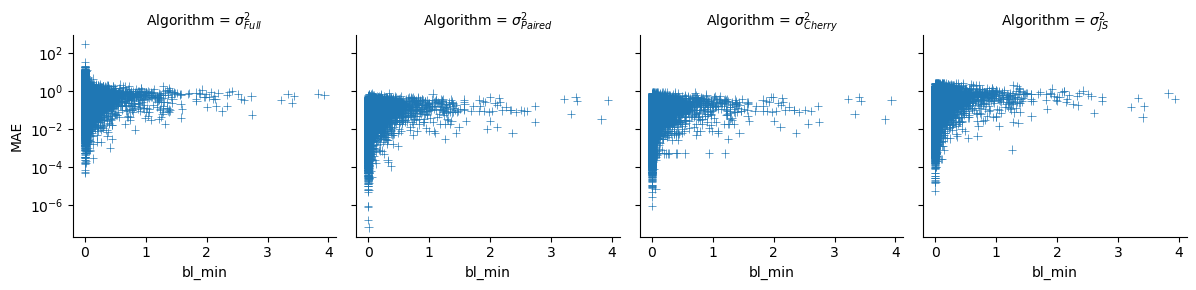

In [ ]:

# del x_mae['alg']
# g = sns.FacetGrid(
#     x_mae,#.query('lam_minus_mu<=5'),
#                   col="Algorithm",
#                       )
# g.map_dataframe(sns.scatterplot, var, "MAE",
#      style='Algorithm',
#                                markers='+'
# )


# p=sns.scatterplot(
#     data=x_mae,
#     y="MAE",
#     x=var,
#     # col='Algorithm',
#     # style='Algorithm',
#     hue='Algorithm',
#     s=10,
#     # errorbar='se',
#     # x_bins=50,
#     # sx_estimator=np.mean, 
#     # order=2
# )
# g.set_yscale('log')
plt.yscale('log')
# plt.xlabel(r'$\lambda-\mu$');
plt.savefig(f'figures/lmplot_{var}.png');

In [ ]:
x_mae = x.groupby('lam_minus_mu').mean()
x_mae

,index,lam,mu,h,bl_max,bl_mean,bl_median,bl_min,bl_q1,bl_q3,...,n,rho,sigma,sigma_cherry,sigma_js,sigma_paired,tau,mu_over_lam,h_lam_minus_mu,h_mu_over_lam
lam_minus_mu,,,,,,,,,,,,,,,,,,,,,
0.025,11609.50000,0.5,0.475,5.260870,4.407697,1.790982,1.169386,0.338483,0.508432,2.892879,...,6.895652,0.350676,0.885674,1.077707,1.042306,1.060919,0.225877,0.95,0.131522,4.997826
0.050,9279.50000,0.5,0.450,5.389831,4.633094,1.857761,1.133424,0.352410,0.479734,2.958920,...,6.338983,0.207966,0.946565,1.032988,1.068148,1.021165,0.223667,0.90,0.269492,4.850847
0.050,42789.50000,1.0,0.950,4.914439,4.654211,1.449899,0.792744,0.208754,0.333072,1.812704,...,10.026738,0.188260,1.039637,1.048835,1.092110,1.033371,0.249705,0.95,0.245722,4.668717
0.075,68469.50000,1.5,1.425,4.710638,4.274990,1.182448,0.587368,0.115436,0.226211,1.601399,...,12.353191,0.125925,1.035575,1.015053,1.054631,1.007289,0.260099,0.95,0.353298,4.475106
0.075,6799.97619,0.5,0.425,5.317460,4.116789,1.595552,0.997240,0.326915,0.510417,2.223695,...,7.928571,0.309655,0.953584,1.062249,1.075061,1.036718,0.215941,0.85,0.398810,4.519841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.500,610019.50000,11.0,5.500,1.862069,0.589818,0.075677,0.046724,0.000649,0.018977,0.101812,...,936.235632,-0.117493,1.472060,0.997712,1.000625,0.999377,0.109653,0.50,10.241379,0.931034
6.300,525829.50000,9.0,2.700,3.006689,0.594315,0.071529,0.047418,0.000297,0.019431,0.097590,...,1574.230769,-0.067691,1.460482,0.998738,0.998182,0.999056,0.084669,0.30,18.942140,0.902007
6.500,679719.50000,13.0,6.500,4.000000,0.567484,0.060804,0.038127,0.000080,0.015264,0.081095,...,1771.662500,-0.130782,1.675912,0.997121,0.998528,0.998832,0.080580,0.50,26.000000,2.000000


### scary plots

(0.0, 10.0)

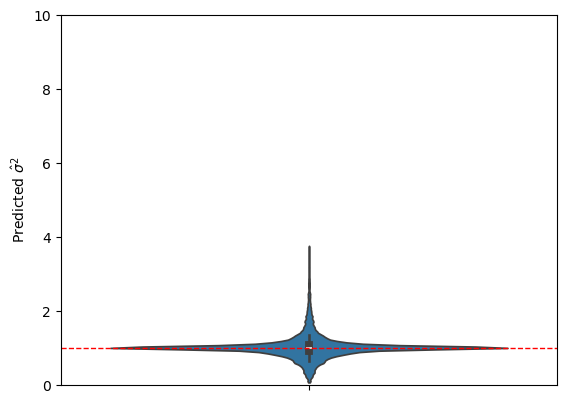

In [62]:
ax=sns.violinplot(
    (x
     # .query('sigma<=10')
    # .query('1000>n ')
    .sigma),
    cut=0
)
ylims = (0, 10)
plt.ylabel(r'Predicted $\hat{\sigma}^2$');
plt.axhline(y=1,color='r',linestyle='dashed',linewidth=1)
plt.ylim(ylims)
# plt.savefig(figdir/'pic/PIC_full_pred_violin_lt10.png')
# plt.savefig(figdir/'pic/PIC_full_pred_violin_all.png')

In [63]:
x.query('n<1000').sigma.mean(),x.sigma.agg(['min','mean'])

(np.float64(1.0243484161778118),
 min     0.056459
 mean    1.018375
 Name: sigma, dtype: float64)

In [64]:
np.mean(x.sigma>2)

np.float64(0.020989849171302404)

<Axes: >

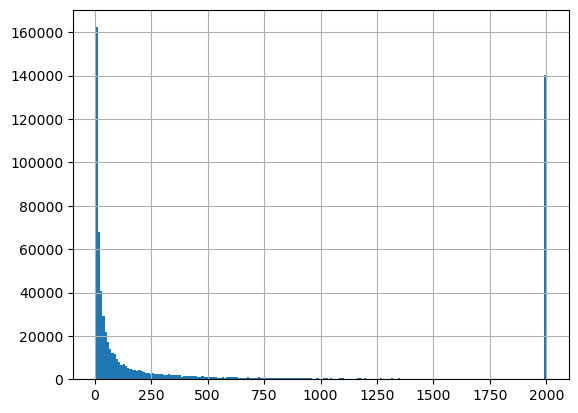

In [49]:
x.n.hist(bins=200),


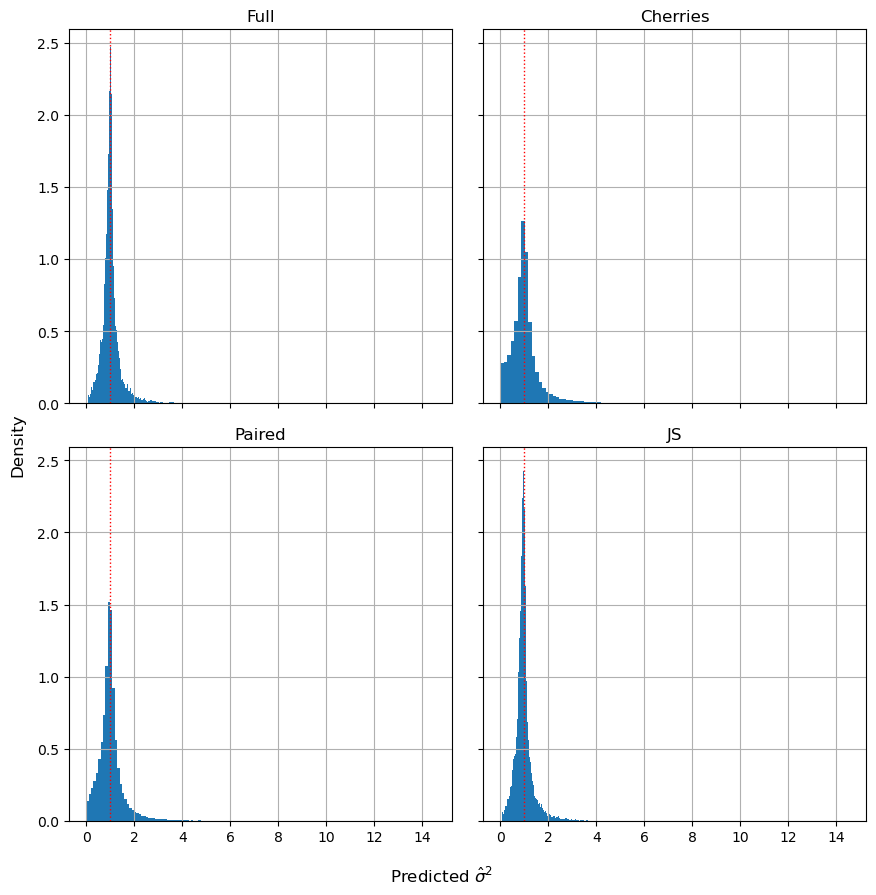

In [11]:
# fig = plt.figure(  
#     figsize=(9, 9),
#                 )

axes = (x
 .query('n<1000')[[
     'sigma','sigma_cherry','sigma_paired','sigma_js',#'sigma_js_old'
 ]]
 .rename(
     columns={
         'sigma':'Full', 'sigma_paired':'Paired','sigma_cherry':'Cherries','sigma_js':'JS',#'sigma_js_old':'JS_old'
     })
 .hist(
     bins=100, 
         figsize=(9, 9),

     density=True, sharey=True, sharex=True )
)
for ax in axes.ravel(): 
    ax.axvline(x=1,color='r',linestyle='dotted',linewidth=1)
fig = ax.get_figure()
fig.supxlabel(r'Predicted $\hat{\sigma}^2$')
fig.supylabel( 'Density')

plt.tight_layout()
plt.savefig(figdir/f'sig_preds{estimator}.png')

In [81]:
x.astype(float)

bl_max   bl_mean  bl_median    bl_min     bl_q1     bl_q3  \
lam  mu    h                                                                
0.5  0.35  1  0.494690  0.210476   0.119920  0.016818  0.016818  0.494690   
           1  0.494690  0.210476   0.119920  0.016818  0.016818  0.494690   
           1  0.494690  0.210476   0.119920  0.016818  0.016818  0.494690   
           1  0.494690  0.210476   0.119920  0.016818  0.016818  0.494690   
           1  0.494690  0.210476   0.119920  0.016818  0.016818  0.494690   
...                ...       ...        ...       ...       ...       ...   
13.0 11.70 7  4.440629  0.133747   0.062447  0.000019  0.022201  0.155759   
           7  4.440629  0.133747   0.062447  0.000019  0.022201  0.155759   
           7  4.440629  0.133747   0.062447  0.000019  0.022201  0.155759   
           7  4.440629  0.133747   0.062447  0.000019  0.022201  0.155759   
           7  4.440629  0.133747   0.062447  0.000019  0.022201  0.155759   

                bl_std       n       rho     sigma  sigma_ape  sigma_cherry  \
lam  mu    h                                                                  
0.5  0.35  1  0.205330     4.0  0.500000  2.176587        NaN      5.021602   
           1  0.205330     4.0  0.500000  2.176587        NaN      0.022909   
           1  0.205330     4.0  0.500000  2.176587        NaN      2.114911   
           1  0.205330     4.0  0.500000  2.176587        NaN      0.111339   
           1  0.205330     4.0  0.500000  2.176587        NaN      0.729480   
...                ...     ...       ...       ...        ...           ...   
13.0 11.70 7  0.231561  1413.0 -0.322002  1.029730        NaN      1.072150   
           7  0.231561  1413.0 -0.322002  1.029730        NaN      1.022196   
           7  0.231561  1413.0 -0.322002  1.029730        NaN      0.921187   
           7  0.231561  1413.0 -0.322002  1.029730        NaN      0.951124   
           7  0.231561  1413.0 -0.322002  1.029730        NaN      0.994529   

              sigma_geig  sigma_js  sigma_js_old  sigma_paired       tau  \
lam  mu    h                                                               
0.5  0.35  1         NaN  2.176587      2.176587      2.512402 -0.544949   
           1         NaN  2.176587      2.176587      0.611150  0.856349   
           1         NaN  2.176587      2.176587      1.143428 -0.544949   
           1         NaN  2.176587      2.176587      0.056881 -0.077850   
           1         NaN  2.176587      2.176587      0.609972  0.077850   
...                  ...       ...           ...           ...       ...   
13.0 11.70 7         NaN  1.008857      1.029730      1.114416  0.252965   
           7         NaN  1.008857      1.029730      1.045236  0.195773   
           7         NaN  1.008857      1.029730      0.950252  0.099885   
           7         NaN  1.008857      1.029730      1.033383  0.345909   
           7         NaN  1.008857      1.029730      1.002704  0.319942   

              tree_ix  
lam  mu    h           
0.5  0.35  1      0.0  
           1      0.0  
           1      0.0  
           1      0.0  
           1      0.0  
...               ...  
13.0 11.70 7     99.0  
           7     99.0  
           7     99.0  
           7     99.0  
           7     99.0  

[697480 rows x 18 columns]

### ML BM estimates

In [19]:
x_geig.drop(columns='tree_ix').corr('spearman')

,sig_ape,sig_geig,se_ape,se_geig,lam,h,mu,r,rho,hr,hrho,lam_minus_mu,mu_over_lam
sig_ape,1.000000,0.996073,0.953220,-0.869525,0.261428,0.427882,0.249399,0.181472,0.044354,0.578709,0.412212,0.181433,0.040904
sig_geig,0.996073,1.000000,0.948164,-0.868351,0.274122,0.422227,0.262324,0.180820,0.054494,0.574167,0.410281,0.180781,0.050863
se_ape,0.953220,0.948164,1.000000,-0.666379,0.241343,0.325985,0.251279,0.087350,0.123875,0.392134,0.342532,0.087305,0.122937
se_geig,-0.869525,-0.868351,-0.666379,1.000000,-0.239754,-0.423489,-0.196561,-0.282660,0.078331,-0.688754,-0.370037,-0.282614,0.080679
lam,0.261428,0.274122,0.241343,-0.239754,1.000000,-0.352113,0.965274,0.422417,0.392999,0.097405,-0.199606,0.422299,0.381740
h,0.427882,0.422227,0.325985,-0.423489,-0.352113,1.000000,-0.267000,-0.414620,0.122217,0.447863,0.948192,-0.414620,0.120417
mu,0.249399,0.262324,0.251279,-0.196561,0.965274,-0.267000,1.000000,0.242924,0.556830,-0.015046,-0.070002,0.242777,0.545175
r,0.181472,0.180820,0.087350,-0.282660,0.422417,-0.414620,0.242924,1.000000,-0.620581,0.566981,-0.558496,0.999999,-0.623415
rho,0.044354,0.054494,0.123875,0.078331,0.392999,0.122217,0.556830,-0.620581,1.000000,-0.491697,0.406248,-0.620621,0.989584
hr,0.578709,0.574167,0.392134,-0.688754,0.097405,0.447863,-0.015046,0.566981,-0.491697,1.000000,0.269044,0.566980,-0.493524


In [80]:
x_geig_sigs.to(float)

AttributeError: 'DataFrame' object has no attribute 'to'

% >=2: sigma_ape     0.304658
sigma_geig    0.332532
dtype: float64, 10% >sigma_ape     68.009232
sigma_geig    87.512410
Name: 0.9, dtype: float64


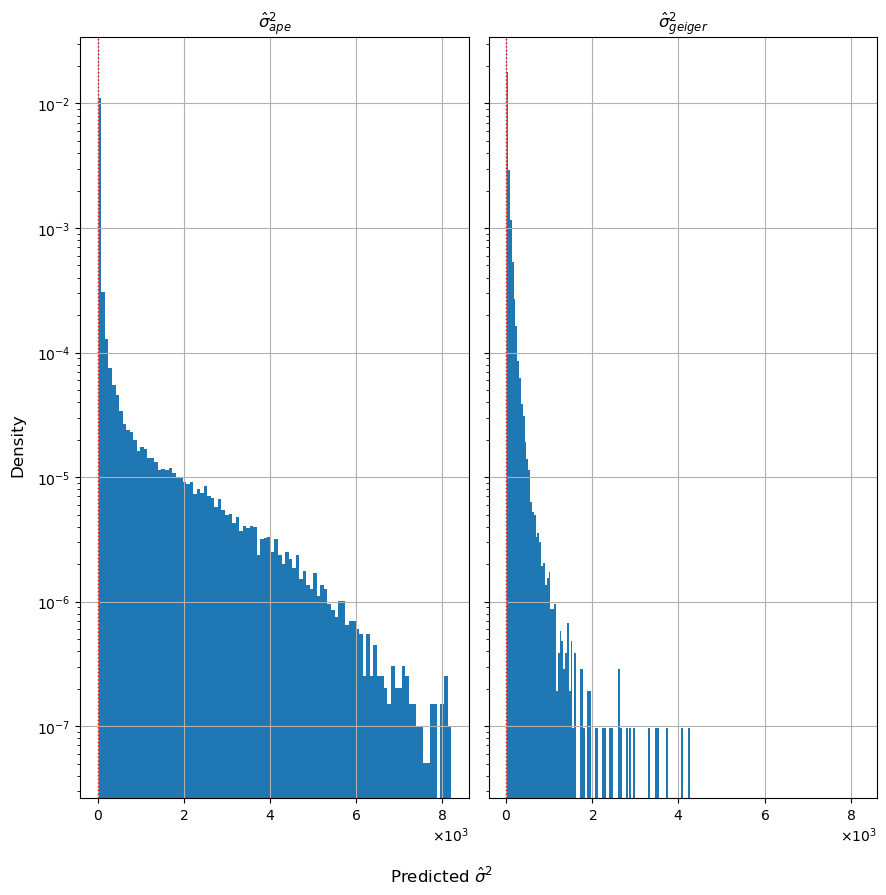

In [88]:
x_geig_sigs =( 
    x
        .query('n < 1000')# & sigma_ape < 1e6 & sigma_geig < 1e6')
        [[
     'sigma_ape', 'sigma_geig',#'se_ape', 'se_geig'
 ]])
print(f'% >=2: {(x_geig_sigs >= 2).mean()}, 10% >{ x_geig_sigs.quantile(.9)}')
axes = (x_geig_sigs
        .dropna()
 .rename(
     columns={
     'sigma_ape' : r'$\hat{\sigma}^2_{ape}$',
         'sigma_geig': r'$\hat{\sigma}^2_{geiger}$'
         # 'se_ape', 'se_geig'
     })
 .hist(
     bins = 100, 
         figsize=(9, 9),

     density=True, 
     log = True,
     sharey = True,
     sharex = True 
 )
)
for ax in axes.ravel(): 
    ax.axvline(x=1, color='r', linestyle='dotted',linewidth=1)
    # plt.xscale('log')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)

fig = ax.get_figure()
fig.supxlabel(r'Predicted $\hat{\sigma}^2$')
fig.supylabel( 'Density')

plt.tight_layout()
plt.savefig(figdir/f'sig_ml_preds{estimator}.png')

### MAE and MSE

In [28]:
(x
 # .query('n<1000')
    .dropna()[['sigma','sigma_cherry','sigma_paired','sigma_js','sigma_js_old']]
.describe())

print(x.mean())

,sigma,sigma_cherry,sigma_paired,sigma_js,sigma_js_old
count,697040.000000,6.970400e+05,697040.000000,697040.000000,697040.000000
mean,1.018348,1.004877e+00,1.003628,0.978772,1.018348
std,0.336938,5.594092e-01,0.455406,0.329152,0.336938
min,0.056459,3.495567e-10,0.000163,0.056459,0.056459
25%,0.903248,7.916701e-01,0.837598,0.861222,0.903248
50%,0.994015,9.791631e-01,0.986325,0.958140,0.994015
75%,1.072638,1.099597e+00,1.088089,1.029216,1.072638
max,3.751442,1.451526e+01,9.925636,3.751442,3.751442


In [29]:
accurate_sigma = x[(x.sigma-1).abs() <5e-3][['lam','mu','h']].value_counts()

x.set_index(accurate_sigma.index.names).loc[accurate_sigma.index].n.groupby(accurate_sigma.index.names).mean()


lam   mu     h
0.5   0.35   7      10.375000
1.0   0.30   5      41.077778
             7     200.928571
      0.50   1       5.450000
             5      28.460674
                     ...     
13.0  9.10   7    2000.000000
      11.70  1      32.344444
             3     464.000000
             5    1717.740000
             7    1988.120000
Name: n, Length: 306, dtype: float64

In [ ]:
accurate_sigma

lam   mu      h
11.0  5.500   1    80
4.5   3.150   1    80
2.0   1.600   7    60
      1.700   7    60
5.0   1.500   1    60
                   ..
12.0  10.800  1    20
              3    20
      11.400  1    20
12.5  11.250  3    20
      11.875  3    20
Name: count, Length: 128, dtype: int64

In [45]:
x['sq_err'] = (x.sigma-1)**2
x.groupby(['lam','mu','h']).agg(['mean','std']).corr('spearman')['sigma'].sort_values(by='mean')



mean       std
n            mean -0.567336 -0.970693
lam_minus_mu mean -0.362141 -0.688781
n            std  -0.343593 -0.477610
bl_max       mean -0.147552 -0.079525
             std   0.031594  0.241051
bl_std       mean  0.116937  0.363433
mu_over_lam  mean  0.126600  0.326855
bl_std       std   0.183347  0.485108
bl_mean      std   0.234769  0.564177
             mean  0.257293  0.562087
sigma_paired mean  0.294801  0.455403
sigma_cherry mean  0.296660  0.520462
bl_q3        std   0.298687  0.653088
             mean  0.303122  0.630616
tau          mean  0.310893  0.661939
bl_median    mean  0.326341  0.647347
bl_q1        mean  0.352404  0.683786
bl_median    std   0.357812  0.740550
bl_q1        std   0.401259  0.790793
bl_min       std   0.426126  0.814147
rho          std   0.469136  0.878915
bl_min       mean  0.500441  0.904523
rho          mean  0.504073  0.772024
tau          std   0.552637  0.963697
sigma_cherry std   0.563223  0.971242
sigma_paired std   0.568902  0.971718
sigma_js_old std   0.617218  1.000000
sigma        std   0.617218  1.000000
sigma_js     std   0.625451  0.998048
sq_err       mean  0.633338  0.988941
             std   0.660200  0.967914
sigma_js     mean  0.915230  0.576903
sigma_js_old mean  1.000000  0.617218
sigma        mean  1.000000  0.617218
lam_minus_mu std        NaN       NaN
mu_over_lam  std        NaN       NaN

In [67]:
x.describe()

,bl_max,bl_mean,bl_median,bl_min,bl_q1,bl_q3,bl_std,n,rho,sigma,sigma_ape,sigma_cherry,sigma_geig,sigma_js,sigma_js_old,sigma_paired,tau,tree_ix
count,697480.000000,697480.000000,697480.000000,697480.000000,697480.000000,697480.000000,697480.000000,697480.0,697040.0,697480.00000,245830.000000,697480.000000,245830.000000,697480.000000,697480.00000,697480.000000,697480.000000,697480
unique,34874.000000,34874.000000,34874.000000,34874.000000,34874.000000,34874.000000,34874.000000,1658.0,25814.0,34874.00000,245830.000000,688781.000000,245830.000000,34874.000000,34874.00000,693792.000000,593502.000000,496
top,4.440629,0.133747,0.062447,0.000019,0.022201,0.155759,0.231561,2000.0,1.0,1.02973,22.244944,2.263366,43.866523,1.008857,1.02973,2.263366,0.544949,0
freq,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,140100.0,18060.0,20.00000,1.000000,8.000000,1.000000,20.000000,20.00000,8.000000,2888.000000,8240


In [66]:
corr = x.corr('spearman')
corr['tau'].sort_values()

n              -0.359036
sigma_cherry   -0.135124
sigma_paired   -0.097703
tree_ix        -0.042140
rho            -0.023490
sigma          -0.019278
sigma_js_old   -0.019278
sigma_ape      -0.016817
sigma_js       -0.016214
sigma_geig     -0.013663
bl_max          0.124201
bl_q1           0.151025
bl_median       0.187960
bl_q3           0.236012
bl_mean         0.272860
bl_std          0.274635
bl_min          0.316861
tau             1.000000
Name: tau, dtype: float64

In [32]:
corr = x.query('4<n<200 & bl_min<.2 & h>3').corr('spearman')
for col in ['sigma_paired','sigma','sigma_cherry','sigma_js']:
    print(corr[col].sort_values(),'\n-----\n\n')
x.query('n<100 & bl_min<.2 & h>3')#.describe()

bl_mean        -0.088860
bl_std         -0.084706
bl_min         -0.078572
tau            -0.071729
bl_q3          -0.059354
bl_median      -0.049394
sq_err         -0.048911
rho            -0.043681
bl_q1          -0.038818
bl_max         -0.031839
h               0.006591
sigma_js        0.039971
sigma_js_old    0.041924
sigma           0.041924
mu              0.042482
lam             0.046657
n               0.106469
sigma_cherry    0.799872
sigma_paired    1.000000
Name: sigma_paired, dtype: float64 
-----


bl_mean        -0.044946
bl_min         -0.043363
bl_std         -0.042909
bl_median      -0.035188
bl_q3          -0.034523
rho            -0.025638
bl_q1          -0.021379
bl_max         -0.017226
tau            -0.012448
h              -0.010888
sq_err         -0.009492
mu              0.022168
lam             0.024931
sigma_cherry    0.033547
sigma_paired    0.041924
n               0.055151
sigma_js        0.987574
sigma           1.000000
sigma_js_old    1.000000
Name: 

,lam,mu,h,bl_max,bl_mean,bl_median,bl_min,bl_q1,bl_q3,bl_std,n,rho,sigma,sigma_cherry,sigma_js,sigma_js_old,sigma_paired,tau,sq_err
680,0.5,0.35,5,6.397680,1.930382,0.730475,0.095885,0.538816,1.889054,2.310847,6.0,1.000000,2.685979,3.154816,2.168285,2.685979,3.154816,0.173727,2.842525
681,0.5,0.35,5,6.397680,1.930382,0.730475,0.095885,0.538816,1.889054,2.310847,6.0,1.000000,2.685979,0.768084,2.168285,2.685979,0.768084,-0.104236,2.842525
682,0.5,0.35,5,6.397680,1.930382,0.730475,0.095885,0.538816,1.889054,2.310847,6.0,1.000000,2.685979,0.795234,2.168285,2.685979,0.795234,0.057909,2.842525
683,0.5,0.35,5,6.397680,1.930382,0.730475,0.095885,0.538816,1.889054,2.310847,6.0,1.000000,2.685979,0.575092,2.168285,2.685979,0.575092,0.428527,2.842525
684,0.5,0.35,5,6.397680,1.930382,0.730475,0.095885,0.538816,1.889054,2.310847,6.0,1.000000,2.685979,1.514488,2.168285,2.685979,1.514488,0.057909,2.842525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693595,13.0,11.70,5,4.412541,0.384351,0.087370,0.007665,0.028348,0.254331,0.968595,20.0,0.285965,0.447495,1.039747,0.438711,0.447495,1.128998,0.131244,0.305262
693596,13.0,11.70,5,4.412541,0.384351,0.087370,0.007665,0.028348,0.254331,0.968595,20.0,0.285965,0.447495,0.397005,0.438711,0.447495,0.581947,0.580725,0.305262
693597,13.0,11.70,5,4.412541,0.384351,0.087370,0.007665,0.028348,0.254331,0.968595,20.0,0.285965,0.447495,1.695788,0.438711,0.447495,1.831264,0.510020,0.305262
693598,13.0,11.70,5,4.412541,0.384351,0.087370,0.007665,0.028348,0.254331,0.968595,20.0,0.285965,0.447495,1.264164,0.438711,0.447495,1.160974,0.181100,0.305262


### BD Descriptive Stats

In [33]:
# TODO: plot bl mean
p=sns.lineplot(
    data=x.query('h==5'),
   x='lam_minus_mu',
   y='bl_mean')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$bl_{mean}$')
plt.xlabel(r'$\lambda-\mu$')
plt.savefig(figdir/'lam_minus_mu_h5_bl.png');

x[['lam','h']].value_counts().sort_values()


lam   h
0.5   1      420
6.5   7     1960
8.5   7     1980
9.0   7     2000
7.5   7     2000
           ...  
3.0   3    12520
2.0   5    12780
3.0   5    13300
2.0   7    13580
11.0  1    17240
Name: count, Length: 100, dtype: int64

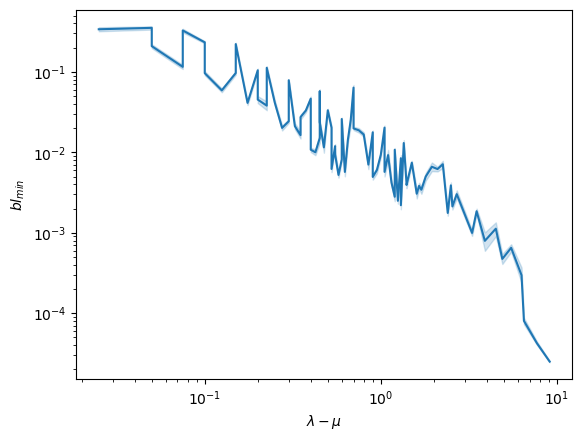

In [ ]:
# sns.heatmap(
#         x.query('h==5').groupby(['lam','mu']).bl_min.mean().unstack())
# sns.lineplot(data=x.query('h==5 & lam==3'),x='mu',y='bl_min')
p=sns.lineplot(data=x.query('h==5'),
               x='lam_minus_mu',
               y='bl_min')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$bl_{min}$')
plt.xlabel(r'$\lambda-\mu$')
plt.savefig(figdir/'lam_minus_mu_h5_bl.png');

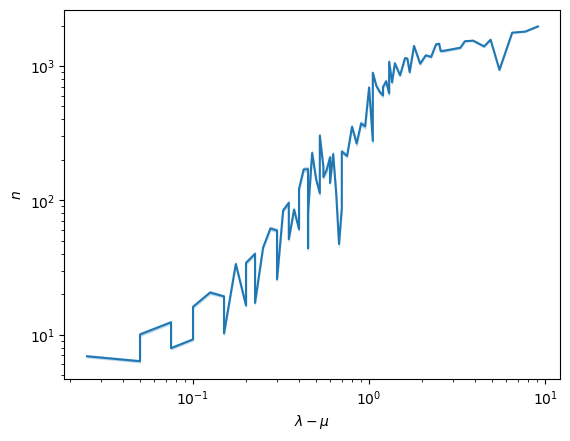

In [ ]:
# sns.heatmap(
#         x.query('h==5').groupby(['lam','mu']).bl_min.mean().unstack())
# sns.lineplot(data=x.query('h==5 & lam==3'),x='mu',y='bl_min')
p=sns.lineplot(data=x.query('h==5'),
               x='lam_minus_mu',
               y='n')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$n$')
plt.xlabel(r'$\lambda-\mu$')
plt.savefig(figdir/'lam_minus_mu_h5_n.png');

### Plot MAE

In [ ]:
# x['idx'] = pd.cut(x[var],bins=50,retbins=False,
#       ).apply(lambda a:a.right)
# x[['idx',pred]].groupby('idx', observed=True).agg(
#         mean=(pred, 'mean'),
#         q1 = (pred, partial(np.quantile,q=.25)),
#         q2 = (pred, partial(np.quantile,q=.75))
#     ) #.reset_index(level=-1, drop=True)[pred]
# # partial(np.quantile,q=.25)
#     #    # res.c
# # x.idx

In [57]:

xlabels = {
    f'bl_{stat}':r"$bl_{"+stat+"}$" for stat in ('min','max','median','q1','q3')}
xlabels.update(
    {
    'tau':r'$\tau$',
    'rho':r'$\rho$',
    'lam':r'$\lambda$',
    'mu':r'$\mu$',
    'lam_minus_mu':r'$\lambda-\mu$',
    'mu_over_lam':r'$\mu/\lambda$',  
    'h_lam_minus_mu':r'$H(\lambda-\mu)$',
    'h_mu_over_lam':r'$H\mu/\lambda$',  
})
xlabels

{'bl_min': '$bl_{min}$',
 'bl_max': '$bl_{max}$',
 'bl_median': '$bl_{median}$',
 'bl_q1': '$bl_{q1}$',
 'bl_q3': '$bl_{q3}$',
 'tau': '$\\tau$',
 'rho': '$\\rho$',
 'lam': '$\\lambda$',
 'mu': '$\\mu$',
 'lam_minus_mu': '$\\lambda-\\mu$',
 'mu_over_lam': '$\\mu/\\lambda$',
 'h_lam_minus_mu': '$H(\\lambda-\\mu)$',
 'h_mu_over_lam': '$H\\mu/\\lambda$'}

In [72]:
x.columns

Index(['lam', 'mu', 'h', 'bl_max', 'bl_mean', 'bl_median', 'bl_min', 'bl_q1',
       'bl_q3', 'bl_std', 'n', 'rho', 'sigma', 'sigma_ape', 'sigma_cherry',
       'sigma_geig', 'sigma_js', 'sigma_js_old', 'sigma_paired', 'tau',
       'tree_ix', 'lam_minus_mu', 'mu_over_lam', 'h_lam_minus_mu',
       'h_mu_over_lam', 'idx'],
      dtype='object')

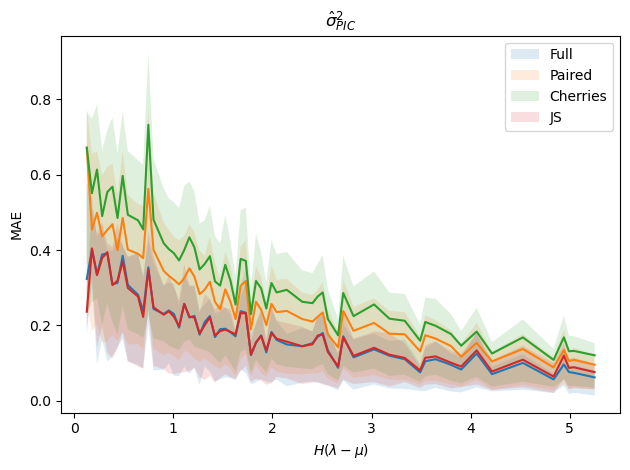

In [92]:
# x if ils else x_no_ils.reset_index()

w_lim = 0.005
var =  "h_lam_minus_mu" # "bl_min" # "n" #  "h_mu_over_lam" # h_lam_minus_mu
ils = False

query = 'rho<0'#  "bl_min < 0.25 & n>4" # 'bl_min<.2 & 500>n>4' # 'bl_min < .05 & 4 < n < 50'#'' #  'bl_min<.1'# "bl_min < 0.25 & h>1 & 4<n<1000"
if var == "n":
    eps = 10
    # query = '&'.join((query,""))
else:
    eps = 0.01
    # query = '&'.join((query, "500>n"))  # lam>5 & mu>4'#100<n<500'

bins=100

for pred, label in zip(
    # [ "sigma_ape", "sigma_geig"],
    # [ "ape", "geiger"]
    ["sigma", "sigma_paired", "sigma_cherry", "sigma_js", ],
    ["Full", "Paired", "Cherries","JS", ]
):
    # if label!='Full':continue
    if query: 
        res=x.query(query)
    else:
        res = x
    res = res[[var, pred]]
    res[pred]=(res[pred] -1).abs() # get MAE
    res[var] = pd.cut(res[var],
                          bins=bins,
                          retbins=False,
          ).apply(lambda a:a.right)
    res = res.groupby(var, observed=True).agg(
            mean=(pred, 'mean'),
            q1 = (pred, partial(np.quantile,q=.25)),
            q2 = (pred, partial(np.quantile,q=.75))
    )
    # del x['idx_tmp']
    # [pred] #.reset_index(level=-1, drop=True)[pred]
    # res.columns = res.columns.droplevel()
#     print(res.columns,
#           res.index,
#           res
# )
    # res = rolling_mae(
    #     eps,
    #     (x).query(query) if query else x,
    #     pred=pred,
    #     # limits = (w_lim,1-w_lim),
    #     var=var,
    # )
    # ax = sns.lineplot(data=x, x=var, y=pred,
    #                   err_style="band", 
    #                   label=label,
    #                  n_boot=100)

    ax=plt.plot(res.index,
                 res['mean']
               )
    plt.fill_between(
    res.index, 
        res.q1,
        res.q2, 
        # color='b', 
        alpha=.15,
         label=label)
    # plt.plot(*res,
    # plt.errorbar(
    
    #              yerr=res['std'],
    #          fmt='-o', 
    #              markersize=4,
    #              capsize=3, 
    #              label='Rolling Mean with Std Dev Error')

    # break
# plt.plot(x_grid, rolling_mae(x_grid, var='tau',limits=[w_lim,1-w_lim]),'b')
plt.xlabel(xlabels.get(var,var))
plt.ylabel(r"MAE")
plt.title(r"$\hat{\sigma}^2_{PIC}$")
plt.legend(loc="upper right")
# plt.yscale("log")

# if var == "tau":
#     plt.legend(loc="upper right")
# # elif var == "n" and not ils:
#     plt.legend(loc="center")
# else:
#     plt.legend(loc="upper left")
if ils and var != "n":
    plt.yscale("log")

plt.tight_layout()
outfile = figdir / (f"pic/pic_{var}_{query.replace(' ','')}{'_ils' if ils else ''}_mae_b{bins}.png")
plt.savefig(outfile,
            dpi = 600);

In [136]:

geiger = pd.read_csv(parent_dir / 'evorates_preds.csv.gz',index_col=x_var)

geiger[['h','model']].value_counts()

h  model     
3  EB            142780
1  EB            131340
5  EB            118100
7  EB             89100
5  delta          75840
7  delta          55880
3  delta          41020
1  rate_trend     39480
   delta          32340
3  rate_trend     23640
5  rate_trend     19860
7  rate_trend      9200
Name: count, dtype: int64

In [66]:
geiger.groupby(['model','h'])['r'].count()

model       h
EB          1    131340
            3    194580
            5    205940
            7    152300
delta       1     32340
            3     41020
            5     75840
            7     55880
rate_trend  1     40780
            3     29580
            5     23420
            7      9200
Name: r, dtype: int64

In [15]:
import pandas as pd
import seaborn as sns
geiger = pd.read_csv(parent_dir / 'evorates_preds.csv.gz')
# g = sns.FacetGrid(geiger, col="model", col_wrap=2, height=2)

In [16]:
geiger

,accelerating,CI,value,sig,lam,h,mu,r,rho,hr,hrho,model,mae
0,1.0,NaN,49.999873,1.053372e-10,0.5,1,0.350,0.150,0.70,0.150,0.70,EB,1.000000
1,1.0,0.0,49.999699,6.127784e-20,0.5,1,0.350,0.150,0.70,0.150,0.70,EB,1.000000
2,1.0,NaN,47.833870,6.591154e-16,0.5,1,0.350,0.150,0.70,0.150,0.70,EB,1.000000
3,0.0,0.0,-11.931358,9.379108e+00,0.5,1,0.350,0.150,0.70,0.150,0.70,EB,8.379108
4,1.0,0.0,49.999485,2.152653e-19,0.5,1,0.350,0.150,0.70,0.150,0.70,EB,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385875,1.0,NaN,30.000000,2.059484e+01,9.5,7,9.025,0.475,0.95,3.325,6.65,delta,19.594841
1385876,1.0,NaN,30.000000,4.951953e+00,9.5,7,9.025,0.475,0.95,3.325,6.65,delta,3.951953
1385877,1.0,NaN,30.000000,1.408854e+01,9.5,7,9.025,0.475,0.95,3.325,6.65,delta,13.088542
1385878,1.0,NaN,30.000000,1.332533e+00,9.5,7,9.025,0.475,0.95,3.325,6.65,delta,0.332533


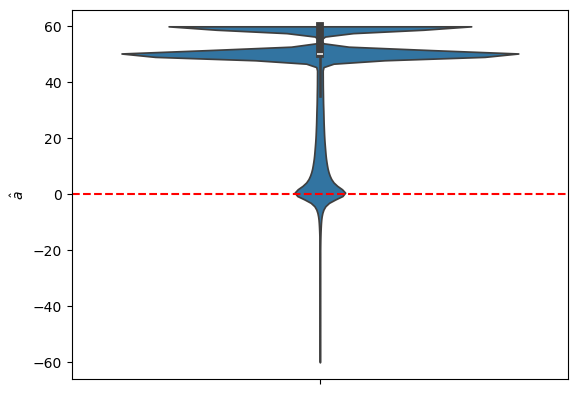

In [30]:
import math

eb = geiger.query('model=="EB"').value
# rate_est = eb.map(lambda s: math.copysign(1,s))
sns.violinplot(eb, cut=0)
plt.ylabel(r'$\hat{a}$')
plt.axhline(y=0,color='r',linestyle='dashed')
plt.savefig(figdir/'geiger/acdc_violin_plot.png')

In [63]:
np.mean(eb==eb.max()),eb.max()

(np.float64(0.1373582202993452), 60.0)

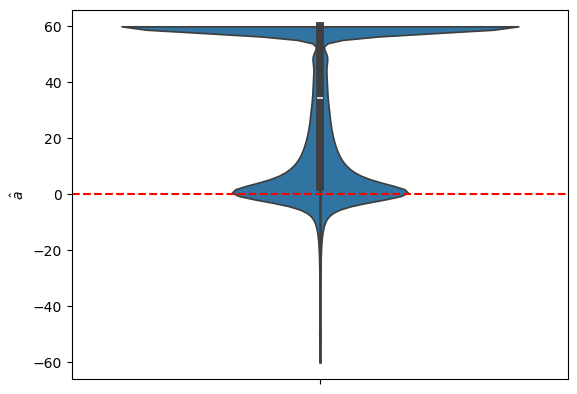

In [29]:
import math

eb = geiger.dropna(subset='CI').query('model=="EB"').value
# rate_est = eb.map(lambda s: math.copysign(1,s))
sns.violinplot(eb, cut=0)
plt.ylabel(r'$\hat{a}$')
plt.axhline(y=0,color='r',linestyle='dashed')
plt.savefig(figdir/'geiger/acdc_violin_plot_truncated.png')


### Plot Geiger Results

null:  model
EB            430063
delta         511465
rate_trend     88649
Name: sig, dtype: int64 
out of:
---
 model
EB            684115
delta         585120
rate_trend    116540
Name: sig, dtype: int64 
 model
EB            0.628641
delta         0.874120
rate_trend    0.760674
Name: sig, dtype: float64


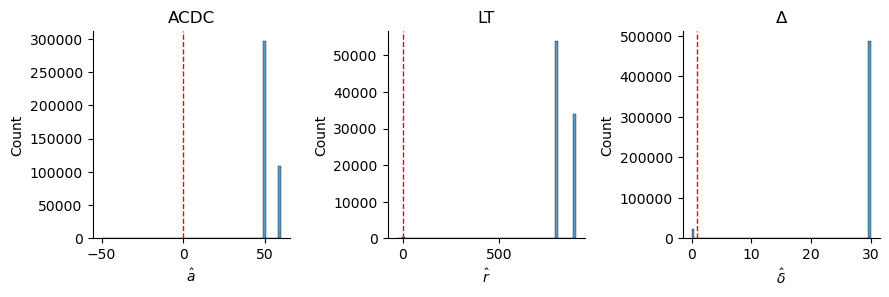

In [6]:
thetas=[r'$\hat{a}$',r'$\hat{r}$',r'$\hat{\delta}$']
labels={'EB':'ACDC','rate_trend':'LT','delta':r'$\Delta$'}
tmp = geiger[geiger.CI.isna()]
g= sns.FacetGrid(tmp,#.dropna(subset='CI'),#.query('h!=5'),
                 col='model', 
                 sharex=False,sharey=False)
g.map(sns.histplot,'value',
      bins=60,
      # log_scale=(False,True),
      fill=True,
      # element='poly'
     )
# displot(data=geiger.query('h!=5'),
#                 x='value',
#            col='model',
#                 col_wrap=4,
#                sharey=False,
#                common_bins=False,
#                kind="hist", kde=False
#            );
# g.set_ylabels(r'$\hat{\sigma}_0^2$')
g.set_xlabels()
for model, theta,thresh, ax in zip(labels.values(),thetas,[0,0,1],g.axes.flatten()):
    ax.axvline(x=thresh,color='r',
               lw=1,
               linestyle='dashed')
    ax.set_title(model)
    ax.set_xlabel(theta)
plt.savefig(figdir/'hist_trend_isna_CI.png');
null_vals=tmp.groupby('model').sig.count()
tot= geiger.groupby('model').sig.count()
print('null: ',null_vals,
      '\nout of:\n---\n',tot,
     '\n',null_vals/tot)

In [ ]:

g= sns.FacetGrid(geiger.dropna(subset='CI'),#.query('h!=5'),
                 col='model', 
                 sharex=False,sharey=False)
g.map(sns.histplot,'value',
      bins=60,
      # log_scale=(False,True),
      fill=True,
      # element='poly'
     )
# displot(data=geiger.query('h!=5'),
#                 x='value',
#            col='model',
#                 col_wrap=4,
#                sharey=False,
#                common_bins=False,
#                kind="hist", kde=False
#            );
# g.set_ylabels(r'$\hat{\sigma}_0^2$')
g.set_xlabels()
for model, theta,thresh, ax in zip(labels.values(),thetas,[0,0,1],g.axes.flatten()):
    ax.axvline(
        x=thresh,
               color='r',
               lw=1,
               linestyle='dashed')
    ax.set_title(model)
    ax.set_xlabel(theta)
plt.savefig(figdir/'hist_trend_dropna_CI.png');

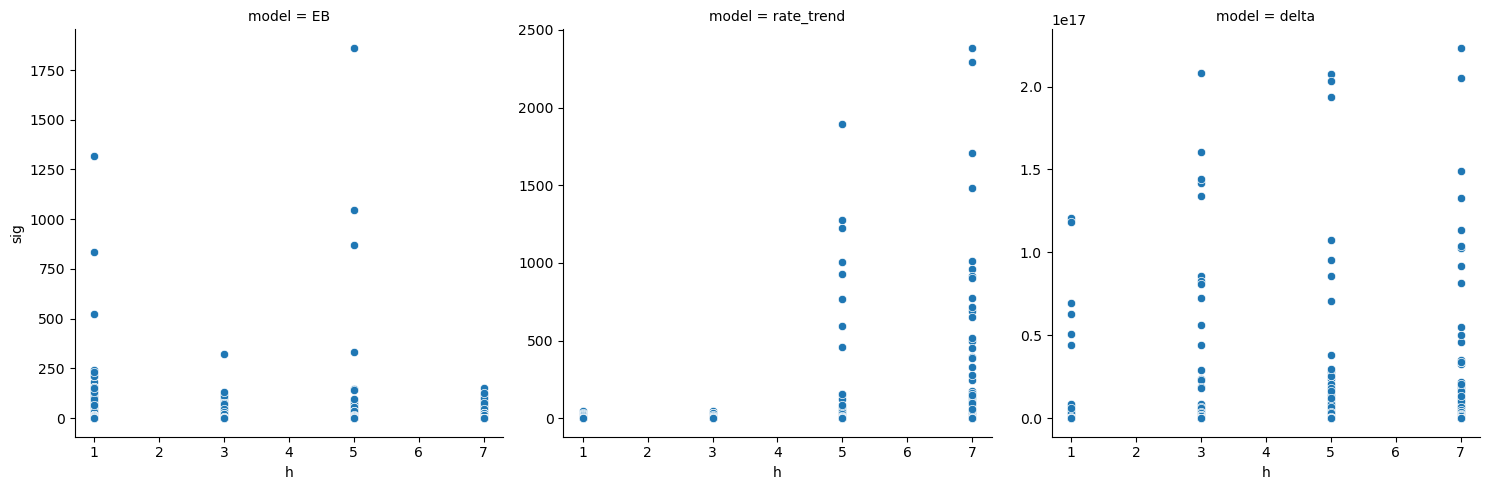

In [8]:
sns.relplot(data=geiger,
                x='h',
           y='sig',
           col='model',
           kind='scatter',
facet_kws={'sharey': False}      
           );

In [ ]:
# x if ils else x_no_ils.reset_index()
x_var = 'hr'

covariates = {
    'rho':r"$\mu/\lambda$",
    'hrho':r"H$\mu/\lambda$",
    'r':r"$\lambda-\mu$",
              'hr':r"$H(\lambda-\mu)$"}
print(parent_dir)
geiger = pd.read_csv(parent_dir / 'evorates_preds.csv.gz',index_col=x_var).query( 'hr < 20').query('h>1 & r< 8')#

bins = 30
trim = 0.05#1
q=.25
# for var,var_label in zip(['accelerating', 'mae'],['Pr(Accelerating)', r'$| \hat{\sigma}^2_{0} - \sigma^2_{0} |$']):
for var,var_label in zip(['sig' ,'mae'],[r'$ \hat{\sigma}^2_{0} $', r'$| \hat{\sigma}^2_{0} - \sigma^2_{0} |$']):
    # fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    # fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

    fig=plt.figure()

    for pred, label in zip(
        [ "rate_trend", "EB",], [ "LT", "ACDC",]
        # [ "delta","rate_trend", "EB",], [ r"$\Delta$", "ACDC", "LT",]
    ):
        # if label!='Full':continue
        res = geiger.query(f'model=="{pred}"')
        res = res[~res.CI.isna()][ var].dropna()
        if trim:
            l,u = res.quantile(trim),res.quantile(1-trim)
            res = res[(l<res) & (res<u)]
        res = res.reset_index()
        res['bin_edges'] = pd.cut(res[x_var],
                          bins=bins,
                          retbins=False,
          ).apply(lambda a:a.right)
        agg = res.groupby('bin_edges', observed=True).agg(
            mean=(var, 'median'),
            q1 = (var, partial(np.quantile,q=q)),
            q2 = (var, partial(np.quantile,q=1-q))
        )

        plt.plot(agg.index,
                     agg['mean'],
                 linestyle='--',
                    label=label)
    # plot the same data on both Axes
        # ax1.plot(agg.index,
        #              agg['mean'],
        #             label=label)
        # ax2.plot(agg.index,
        #              agg['mean'])
        # plt.scatter(res[x_var],res[var],
        #            # label = label,
        #            s=.1)
        plt.fill_between(
            agg.index, 
                agg.q1,
                agg.q2, 
                color='b', 
                alpha=.15,
                 # label=label
            )
    # if var=='mae':
    # plt.yscale('log')


  
    plt.xlabel(covariates.get(x_var, x_var))
    plt.ylabel(var_label)
# plt.title()

    plt.legend(loc="upper right",markerscale=10)

    # plt.tight_layout()
    outfile = figdir / f"evorates_{var}_{x_var}.png"
    plt.savefig(outfile,
                dpi = 600);

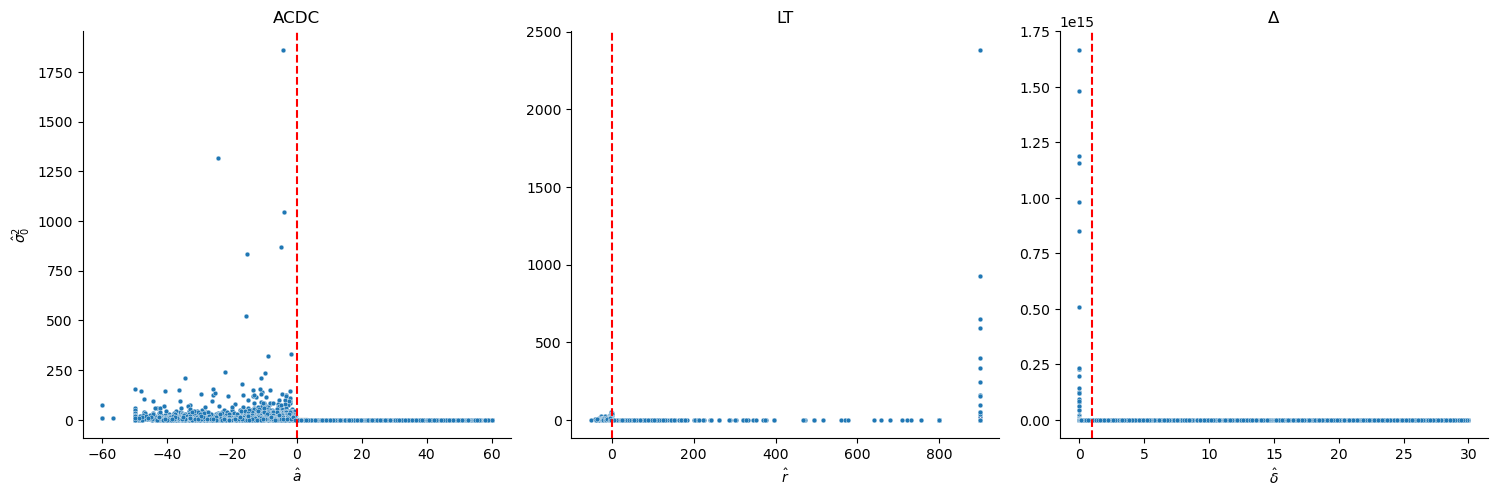

In [28]:
thetas=[r'$\hat{a}$',r'$\hat{r}$',r'$\hat{\delta}$']
labels={'EB':'ACDC','rate_trend':'LT','delta':r'$\Delta$'}
g= sns.relplot(data=geiger.dropna(subset='CI'),#.query('h!=5'),
                x='value',
           y='sig',
           col='model',
            # row='h',
           kind='scatter',
               s=12,
facet_kws={'sharey': False, 
           'sharex': False}      
           );
g.set_ylabels(r'$\hat{\sigma}_0^2$')
g.set_xlabels()
for model, theta,thresh, ax in zip(labels.values(),thetas,[0,0,1],g.axes.flatten()):
    ax.axvline(x=thresh,color='r',linestyle='dashed')
    ax.set_title(model)
    ax.set_xlabel(theta)
plt.savefig(figdir/'sig_v_trend_dropna_CI.png')

/N/project/phyloML/rate_timescaling/data


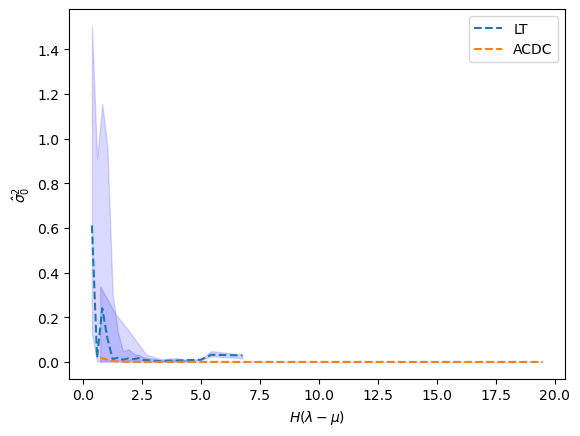

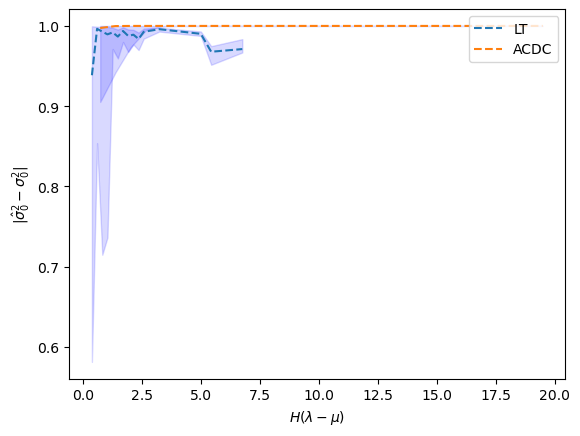

In [29]:
# x if ils else x_no_ils.reset_index()
x_var = 'hr'

covariates = {
    'rho':r"$\mu/\lambda$",
    'hrho':r"H$\mu/\lambda$",
    'r':r"$\lambda-\mu$",
              'hr':r"$H(\lambda-\mu)$"}
print(parent_dir)
geiger = pd.read_csv(parent_dir / 'evorates_preds.csv.gz',index_col=x_var).query( 'hr < 20').query('h>1 & r< 8')#

bins = 30
trim = 0.05#1
q=.25
# for var,var_label in zip(['accelerating', 'mae'],['Pr(Accelerating)', r'$| \hat{\sigma}^2_{0} - \sigma^2_{0} |$']):
for var,var_label in zip(['sig' ,'mae'],[r'$ \hat{\sigma}^2_{0} $', r'$| \hat{\sigma}^2_{0} - \sigma^2_{0} |$']):
    # fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    # fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

    fig=plt.figure()

    for pred, label in zip(
        [ "rate_trend", "EB",], [ "LT", "ACDC",]
        # [ "delta","rate_trend", "EB",], [ r"$\Delta$", "ACDC", "LT",]
    ):
        # if label!='Full':continue
        res = geiger.query(f'model=="{pred}"')
        res = res[~res.CI.isna()][ var].dropna()
        if trim:
            l,u = res.quantile(trim),res.quantile(1-trim)
            res = res[(l<res) & (res<u)]
        res = res.reset_index()
        res['bin_edges'] = pd.cut(res[x_var],
                          bins=bins,
                          retbins=False,
          ).apply(lambda a:a.right)
        agg = res.groupby('bin_edges', observed=True).agg(
            mean=(var, 'median'),
            q1 = (var, partial(np.quantile,q=q)),
            q2 = (var, partial(np.quantile,q=1-q))
        )

        plt.plot(agg.index,
                     agg['mean'],
                 linestyle='--',
                    label=label)
    # plot the same data on both Axes
        # ax1.plot(agg.index,
        #              agg['mean'],
        #             label=label)
        # ax2.plot(agg.index,
        #              agg['mean'])
        # plt.scatter(res[x_var],res[var],
        #            # label = label,
        #            s=.1)
        plt.fill_between(
            agg.index, 
                agg.q1,
                agg.q2, 
                color='b', 
                alpha=.15,
                 # label=label
            )
    # if var=='mae':
    # plt.yscale('log')


    # zoom-in / limit the view to different portions of the data
#     ax2.set_ylim(0, 2)  # outliers only
#     ax1.set_ylim(1e7, 1e11)  # most of the data

#     # hide the spines between ax and ax2
#     ax1.spines.bottom.set_visible(False)
#     ax2.spines.top.set_visible(False)
#     ax1.xaxis.tick_top()
#     ax1.tick_params(labeltop=False)  # don't put tick labels at the top
#     ax2.xaxis.tick_bottom()

#     # Now, let's turn towards the cut-out slanted lines.
#     # We create line objects in axes coordinates, in which (0,0), (0,1),
#     # (1,0), and (1,1) are the four corners of the Axes.
#     # The slanted lines themselves are markers at those locations, such that the
#     # lines keep their angle and position, independent of the Axes size or scale
#     # Finally, we need to disable clipping.

#     d = .5  # proportion of vertical to horizontal extent of the slanted line
#     kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
#                   linestyle="none", color='k', mec='k', mew=1, clip_on=False)
#     ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
#     ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    plt.xlabel(covariates.get(x_var, x_var))
    plt.ylabel(var_label)
# plt.title()

    plt.legend(loc="upper right",markerscale=10)

    # plt.tight_layout()
    outfile = figdir / f"evorates_{var}_{x_var}.png"
    plt.savefig(outfile,
                dpi = 600);

Text(0, 0.5, '$| \\hat{\\sigma}^2_{0} - \\sigma^2_{0} |$')

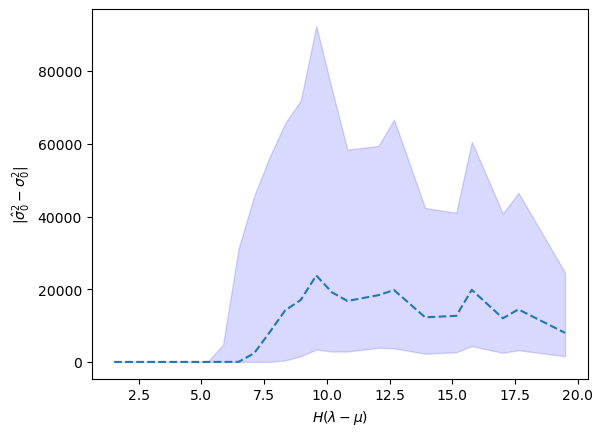

In [27]:
# geiger.describe()
res=geiger.query('model=="delta"')
res[~res.CI.isna()]
res = res.reset_index()
res['bin_edges'] = pd.cut(res[x_var],
              bins=bins,
              retbins=False,
).apply(lambda a:a.right)
agg = res.groupby('bin_edges', observed=True).agg(
mean=(var, 'median'),
q1 = (var, partial(np.quantile,q=q)),
q2 = (var, partial(np.quantile,q=1-q))
)

plt.plot(agg.index,
         agg['mean'],
     linestyle='--')
# plot the same data on both Axes
# ax1.plot(agg.index,
#              agg['mean'],
#             label=label)
# ax2.plot(agg.index,
#              agg['mean'])
# plt.scatter(res[x_var],res[var],
#            # label = label,
#            s=.1)
plt.fill_between(
agg.index, 
    agg.q1,
    agg.q2, 
    color='b', 
    alpha=.15,
     # label=label
)
plt.xlabel(covariates.get(x_var, x_var))
plt.ylabel(var_label)
# plt.title()


    # if var=='mae':

In [157]:
pred='EB'
var='sig'
res = geiger.query(f'model=="{pred}"')[ var].dropna()

l,u = res.quantile(trim),res.quantile(1-trim)
res = res[(l<res) & (res<u)].reset_index()
res['bin_edges'] = pd.cut(res[x_var],
                  bins=bins,
                  retbins=False,
  ).apply(lambda a:a.right)
agg = res.groupby(x_var, observed=True).agg(
    mean=(var, 'mean'),
    q1 = (var, partial(np.quantile,q=.25)),
    q2 = (var, partial(np.quantile,q=.75))
)

# agg[agg['mean']>agg.q2]
agg
# var

,mean,q1,q2
r,,,
0.025,4.412502e-01,3.023942e-23,4.279829e-01
0.050,4.290913e-01,2.876033e-29,4.302352e-01
0.050,3.492686e-01,1.695942e-45,2.339487e-01
0.075,2.105550e-01,3.791670e-65,1.146181e-02
0.075,3.851733e-01,5.953042e-29,2.936783e-01
0.100,3.560144e-01,1.923946e-37,2.458404e-01
0.100,1.511262e-01,5.477967e-74,2.242776e-04
0.125,1.437713e-01,1.267954e-65,1.091371e-04
0.150,1.772294e-01,5.734213e-77,2.574104e-04


In [112]:
trim=.01
res = geiger.query(f'model=="{pred}"')[ var].dropna()

l,u = res.quantile(trim),res.quantile(1-trim)
res = res[(l<res) & (res<u)].reset_index()
res


,mean,q1,q2
bin_edges,,,
0.837,0.962493,0.969936,1.0
1.649,0.971143,0.990222,1.0
2.461,0.976223,0.996410,1.0
3.272,0.980085,0.999216,1.0
4.084,0.985302,0.999960,1.0
4.896,0.986892,0.999993,1.0
5.708,0.995632,1.000000,1.0
7.332,1.000000,1.000000,1.0
8.144,1.000000,1.000000,1.0


In [ ]:
# x.query('bl_min<=.1 & n>=10 & h>1').corr('spearman').sigma.sort_values()
# x.dropna().query('bl_min<=.1 & 100>=n>=10 & h>1').sort_values('sigma', ascending=False)[:2000].describe()

traits = simulate_traits(data_dir=p, n_genes=[1], sigmas=[1])
[trait.shape for trait in traits]

for cond in ['l6.0/m5.700/h7','l7.0/m6.650/h7','l12.0/m11.400/h3','l6.0/m5.700/h5']:
    print(cond.replace('/','_')+'.tar.gz')


l6.0_m5.700_h7.tar.gz
l7.0_m6.650_h7.tar.gz
l12.0_m11.400_h3.tar.gz
l6.0_m5.700_h5.tar.gz


In [ ]:
# x.query('bl_min<=.1 & n>=10 & h>1').corr('spearman').sigma.sort_values()
x.dropna().query('bl_min<=.1 & 100>=n>=10 & h>1').sort_values('sigma', ascending=False)[:2000][['lam','mu','h']]#.value_counts()[:50]#.sort_values(['lam','mu','h'])

,lam,mu,h
382314,12.5,11.875,3
260033,6.5,5.850,3
153920,3.5,3.325,3
248366,6.0,5.700,5
235521,5.5,5.225,3
...,...,...,...
49023,1.5,1.350,7
147993,3.5,2.975,7
30707,1.0,0.900,7
176026,4.0,3.600,7


In [ ]:
x.columns

In [21]:
x['mae']=(x.sigma-1).abs()

mean      0.446064
median    0.352637
Name: mae, dtype: float64
mean      1030.415992
median      64.687682
Name: mae, dtype: float64
mean      0.401359
median    0.303209
Name: mae, dtype: float64
mean      372.221480
median     30.414315
Name: mae, dtype: float64
mean      0.467999
median    0.344991
Name: mae, dtype: float64
mean      53.810164
median     2.463246
Name: mae, dtype: float64
mean      0.421021
median    0.302255
Name: mae, dtype: float64
mean      959.776746
median     24.915722
Name: mae, dtype: float64


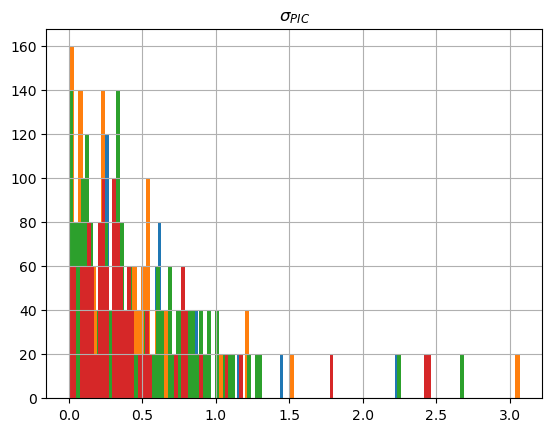

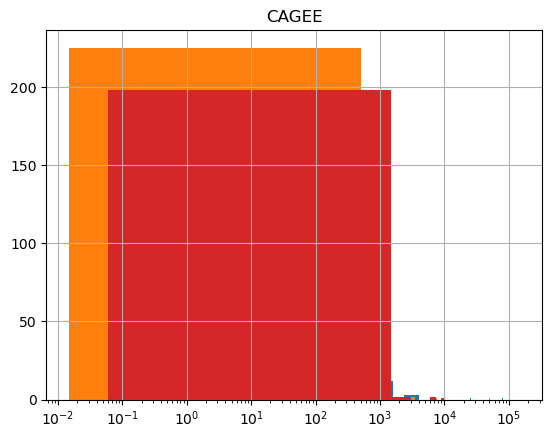

In [47]:
# low error
# f1 = plt.figure(figsize=(8, 6))
# f2 = plt.figure(figsize=(8, 6))
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
for c in [('3.5','2.450','1'),
          ('4.5','3.150','1'),
          ('4.5','3.150','3'),
         ( '7.5','7.125','1')
         ]:
    
    r=x.query(f'lam=={c[0]} and mu=={c[1]} and h=={c[2]}').mae
    r.hist(bins=100, figure=fig1)
    print(r.agg(['mean','median']))
    r=cagee.query(f'lam=={c[0]} and mu=={c[1]} and h=={c[2]}').mae
    r.hist(bins=100,figure=fig2)
    print(r.agg(['mean','median']))
ax1.set_title(r'$\sigma_{PIC}$',)
ax2.set_title('CAGEE',)

    # x[['l6.0/m5.700/h7','l7.0/m6.650/h7','l12.0/m11.400/h3','l6.0/m5.700/h5']].sigma.hist(bins=100)



mean      1.758088
median    1.253875
Name: mae, dtype: float64
mean      1.955494
median    1.336856
Name: mae, dtype: float64
mean      1.543081
median    0.930678
Name: mae, dtype: float64
mean      1.076331
median    0.447565
Name: mae, dtype: float64


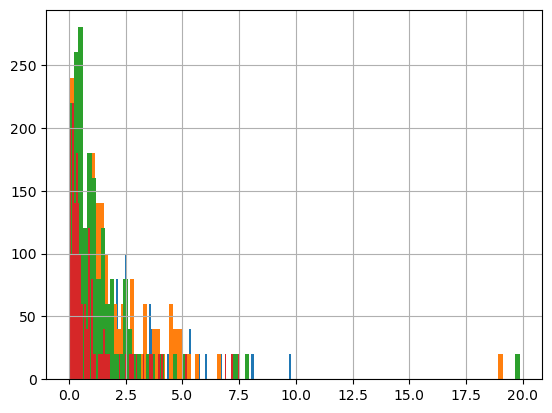

In [27]:
# high error
for c in [('6.0','5.700','7'),
          ('7.0','6.650','7'),
          ('12.0','11.400','3'),
          ('6.0','5.700','5')
         ]:
    r = x.query(f'lam=={c[0]} and mu=={c[1]} and h=={c[2]}').mae
    r.hist(bins=100)
    print(r.agg(['mean','median']))
# x[[,'l7.0/m6.650/h7','l12.0/m11.400/h3','l6.0/m5.700/h5']].sigma.hist(bins=100)



In [35]:
cagee = pd.read_csv('/N/project/phyloML/rate_timescaling/data/cagee/sig_pred.csv.gz', index_col=0).rename(columns={'L':'lam','M':'mu','H':'h'})
cagee

,sig,lam,mu,h,l_min_mu,l_min_mu_h,mae
0,541.311714,3.5,2.45,1.0,1.05,1.05,540.311714
1,459.356533,3.5,2.45,1.0,1.05,1.05,458.356533
2,574.574018,3.5,2.45,1.0,1.05,1.05,573.574018
3,2.006361,3.5,2.45,1.0,1.05,1.05,1.006361
4,0.656559,3.5,2.45,1.0,1.05,1.05,0.343441
...,...,...,...,...,...,...,...
1429,6.408626,6.0,5.70,5.0,0.30,1.50,5.408626
1430,1.438533,6.0,5.70,5.0,0.30,1.50,0.438533
1431,14.978072,6.0,5.70,5.0,0.30,1.50,13.978072
1432,37.654847,6.0,5.70,5.0,0.30,1.50,36.654847


### Find small trees with big $\sigma_{PIC}$

In [ ]:
# 3.5   2.450   1      10.462687
# 4.5   3.150

# less than 5e-3 abs error
for cond in ['l3.5/m2.450/h1','l4.5/m3.150/h1','l4.5/m3.150/h3','l7.5/m7.125/h1']:
    print(cond.replace('/','_'))
    p = Path(f'/N/project/phyloML/rate_timescaling/data/tree_sims/{cond}')
    treefile = p/'parent_trees_4plus.phy'
    with open(treefile) as f:
        trees=f.readlines()
        
    print(p)
    traits = samples = list(np.load( p/'no_ils/samples_ngenes1.npz').values())
    # print(traits)
    # traits = simulate_traits(data_dir=p, n_genes=[1], sigmas=[1])
    small_trees = []
    small_traits = []
    for trait, tree in zip(traits, trees):
        # print(len(tree), tree,trait.shape)
        if trait.shape[1] > 100: continue
        small_trees.append(tree)
        small_traits.append(trait[:5])
    for t in range(5):
        df = pd.DataFrame([trait[t] for trait in small_traits])
        df.to_csv(p/f'null_trait_{t}.csv',index=False, header=False)
    with open(p/'null_trees_cagee.phy','w') as f:
        f.writelines(small_trees)
    print(df.shape,'\n---\n')
    

l3.5_m2.450_h1
/N/project/phyloML/rate_timescaling/data/tree_sims/l3.5/m2.450/h1
(67, 31) 
---

l4.5_m3.150_h1
/N/project/phyloML/rate_timescaling/data/tree_sims/l4.5/m3.150/h1
(80, 49) 
---

l4.5_m3.150_h3
/N/project/phyloML/rate_timescaling/data/tree_sims/l4.5/m3.150/h3
(45, 97) 
---

l7.5_m7.125_h1
/N/project/phyloML/rate_timescaling/data/tree_sims/l7.5/m7.125/h1
(68, 84) 
---



In [ ]:
# for cond in ['l10.0/m9.500/h7','l7.0/m6.650/h7','l12.0/m11.400/h3','l8.0/m7.600/h5']:
for cond in ['l6.0/m5.700/h7','l7.0/m6.650/h7','l12.0/m11.400/h3','l6.0/m5.700/h5']:
    print(cond.replace('/','_'))
    p = Path(f'/N/project/phyloML/rate_timescaling/data/tree_sims/{cond}')
    treefile = p/'parent_trees_4plus.phy'
    with open(treefile) as f:
        trees=f.readlines()
        
    print(p)
    traits = samples = list(np.load( p/'no_ils/samples_ngenes1.npz').values())
    small_trees = []
    small_traits = []
    for trait, tree in zip(traits,trees):
        if trait.shape[1] > 100: continue
        small_trees.append(tree)
        small_traits.append(trait[:5])
    for t in range(5):
        df = pd.DataFrame([trait[t] for trait in small_traits])
        df.to_csv(p/f'trait_{t}.csv',index=False, header=False)
    with open(p/'trees_cagee.phy','w') as f:
        f.writelines(small_trees)
    print(df.shape,'\n---\n')
    paths.append(p)
    

l6.0_m5.700_h7
/N/project/phyloML/rate_timescaling/data/tree_sims/l6.0/m5.700/h7
(43, 98) 
---

l7.0_m6.650_h7
/N/project/phyloML/rate_timescaling/data/tree_sims/l7.0/m6.650/h7
(43, 96) 
---

l12.0_m11.400_h3
/N/project/phyloML/rate_timescaling/data/tree_sims/l12.0/m11.400/h3
(61, 96) 
---

l6.0_m5.700_h5
/N/project/phyloML/rate_timescaling/data/tree_sims/l6.0/m5.700/h5
(71, 100) 
---



In [ ]:
# 3.5   2.450   1      10.462687
# 4.5   3.150
small_trees = []
small_traits = []
conds = []
# less than 5e-3 abs error
for cond in ['l3.5/m2.450/h1','l4.5/m3.150/h1','l4.5/m3.150/h3','l7.5/m7.125/h1', 'l6.0/m5.700/h7','l7.0/m6.650/h7','l12.0/m11.400/h3','l6.0/m5.700/h5']:
    print(cond.replace('/','_'))
    p = Path(f'/N/project/phyloML/rate_timescaling/data/tree_sims/{cond}')
    treefile = p/'parent_trees_4plus.phy'
    with open(treefile) as f:
        trees=f.readlines()   
    traits = list(np.load( p/'no_ils/samples_ngenes1.npz').values())
    # print(traits)
    # traits = simulate_traits(data_dir=p, n_genes=[1], sigmas=[1])
    for trait, tree in zip(traits, trees):
        for i in range(3):
            # print(len(tree), tree,trait.shape)
            if trait.shape[1] > 100: continue
            small_trees.append(tree)
            small_traits.append(trait[i])
            conds.append(cond)
        
df = pd.DataFrame(small_traits)
df.to_csv(f'traits.csv',index=False, header=False)
with open('trees_cagee.phy','w') as f:
    f.writelines(small_trees)
with open('conds_cagee.txt','w') as f:
    f.write('\n'.join(conds))
    

l3.5_m2.450_h1
l4.5_m3.150_h1
l4.5_m3.150_h3
l7.5_m7.125_h1
l6.0_m5.700_h7
l7.0_m6.650_h7
l12.0_m11.400_h3
l6.0_m5.700_h5


In [ ]:
x.dropna().query('bl_min<=.1 & n>=10 & h>1').sort_values('sigma', ascending=False)[:2000].n.value_counts()

n
2000.0    280
20.0       40
37.0       40
17.0       40
22.0       40
         ... 
250.0      20
797.0      20
1388.0     20
691.0      20
61.0       20
Name: count, Length: 82, dtype: int64

In [ ]:
# x.corr('spearman').rho.sort_values()

small_trees = x.query('bl_min<.1 & n==4 & h>1').sort_values('sigma',ascending=False)[:500]#, x.h.value_counts()#,x_no_ils.index
small_trees[small_trees.sigma>small_trees.sigma_cherry]


,lam,mu,h,bl_max,bl_mean,bl_median,bl_min,bl_q1,bl_q3,bl_std,n,rho,sigma,sigma_cherry,sigma_paired,tau
88091,2.5,2.000,3,4.869513,1.688095,0.179232,0.015541,0.015541,4.869513,2.250594,4.0,1.0,38.523316,0.964929,1.861519,-0.233550
10919,0.5,0.475,3,3.649888,1.260817,0.074992,0.057572,0.057572,3.649888,1.689343,4.0,1.0,32.343924,0.816383,1.423424,-0.077850
88702,2.5,2.000,3,3.144752,1.151130,0.307794,0.000844,0.000844,3.144752,1.415262,4.0,1.0,23.773159,1.194015,2.375921,-0.233550
10907,0.5,0.475,3,3.649888,1.260817,0.074992,0.057572,0.057572,3.649888,1.689343,4.0,1.0,23.240976,1.272161,0.673647,-0.077850
219916,5.0,4.750,3,4.089930,1.385882,0.061735,0.005981,0.005981,4.089930,1.912186,4.0,0.5,23.085176,10.160173,5.128937,-0.544949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236985,5.5,5.225,5,5.803529,1.970366,0.094773,0.012795,0.012795,5.803529,2.710662,4.0,1.0,4.134821,0.463610,8.752789,0.856349
80604,2.0,1.900,7,8.093594,2.710813,0.024716,0.014128,0.014128,8.093594,3.806204,4.0,0.5,4.131631,0.117967,1.259382,0.700649
3716,0.5,0.400,5,6.685753,2.500410,0.769960,0.045516,0.045516,6.685753,2.974226,4.0,0.5,4.127478,1.500437,0.844299,-0.233550
264711,6.5,6.175,7,7.719642,2.590710,0.051074,0.001414,0.001414,7.719642,3.626759,4.0,0.5,4.125332,1.598370,0.814200,-0.544949


In [ ]:
p = Path('/N/project/phyloML/rate_timescaling/data/tree_sims/l2.5/m2.000/h3/parent_trees_4plus.phy')
parent_trees = [
            dendropy.Tree.get_from_string(s, schema="newick", rooting="force-rooted")
            for s in p.open("r")
        ] 

traits = simulate_traits(data_dir=p.parent, n_genes=[1], sigmas=[1])
len(traits),len(parent_trees)
for tree, trait in zip(parent_trees,traits):
    if len(tree) == 4 and any(l.length<.016 for l in tree.internal_edges()):
        break
print(tree)

pic = PIC(
    t=tree,
    chars=trait,
    calculate_pic=BrownianBridgePIC,
    max_replicates=20,
    eps=None,
)
res = np.vstack(
    (
        pic.estimate_sigmas(),
        pic.cherries_sigma(),
        pic.paired_lineages_sigma(),
    )
)

res.max(1)

((T4:0.6768071612691018,(T1:0.49757546557973636,T2:0.49757546557973636):0.17923169568936548):0.015541415268491773,T3:0.6923485765375936):4.869512639653985


array([1.31763622, 7.566904  , 7.49521303])

In [ ]:
x['r'] = x.lam-x.mu
x['mu_over_lam'] = x.mu/x.lam
x['blq_over_n'] = x.bl_q1/x.n
x['bl_over_n'] = x.bl_min/x.n
# x.corr().sigma, dirname
x.query('bl_min<.1 & 300<n<320').corr('spearman').sigma.sort_values(), x.h.value_counts()#,x_no_ils.index
# x.query('bl_min<.1 & n==4').corr('spearman').sigma.sort_values(), x.h.value_counts()#,x_no_ils.index

(rho            -0.430883
 r              -0.290750
 bl_q1          -0.260148
 blq_over_n     -0.258443
 bl_median      -0.228518
 bl_q3          -0.150285
 n              -0.136328
 bl_mean        -0.081364
 bl_min         -0.064988
 bl_over_n      -0.060859
 bl_std          0.052983
 n_over_bl       0.060859
 sigma_cherry    0.082861
 sigma_paired    0.096450
 h               0.172699
 bl_max          0.195687
 lam             0.275836
 mu              0.327915
 mu_over_lam     0.431599
 tau             0.443401
 sigma           1.000000
 Name: sigma, dtype: float64,
 h
 3    137000
 1    127340
 7     78180
 5     46880
 Name: count, dtype: int64)

In [ ]:
x.query('bl_min<.15')[['lam','mu','h']].value_counts()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/N/project/phyloML/app/Quartz/miniconda3/envs/p311/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3672, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3110678/312202961.py", line 1, in <module>
    x.query('bl_min<.15')[['lam','mu','h']].value_counts()
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^
  File "/N/project/phyloML/app/Quartz/miniconda3/envs/p311/lib/python3.11/site-packages/pandas/core/frame.py", line 4113, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/N/project/phyloML/app/Quartz/miniconda3/envs/p311/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 6212, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "/N/project/phyloML/app/Quartz/miniconda3/envs/p311/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 

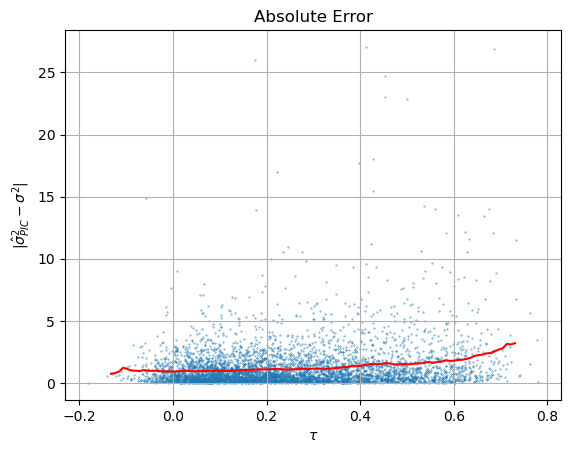

In [ ]:
# x = pd.DataFrame(
#     {'sigs':sigs,'taus': taus})

query = "20 == n"

# < 200')
# plt.xlabel(r'$\tau$')
# plt.ylabel(r'$\hat{\sigma}^2$');
# plt.savefig(figdir / 'pic_tauplot_all.png')
# rmse = np.sqrt(((x.sigma-1)**2).mean())
# mae = np.abs(x.sigma-1).mean()
eps = 0.05
var = "tau"
pred = 'sigma'
label = ''
ax = plt.subplot(1, 1, 1)

y = x.query(query) if query else x

res = rolling_mae(
    eps,
    y,
    pred=pred,
    # limits = (w_lim,1-w_lim),
    var=var,
)
plt.plot(*res, label=label, c="r")
# ax.set_yscale('log')
plt.xlabel("n" if var == "n" else rf"$\{var}$")
plt.grid(visible=True)
plt.ylabel(r"$|\hat{\sigma}^2_{PIC} - \sigma^2|$")
plt.title(r"Absolute Error")
ytau, ysig = y[[var, "sigma"]].values.T
ysig = np.abs(ysig - 1)
ax.scatter(ytau, ysig, s=0.1)
plt.savefig(figdir / f"mae_{var}_{query}{'_ils' if ils else ''}_n4.png")


29.0 29.0


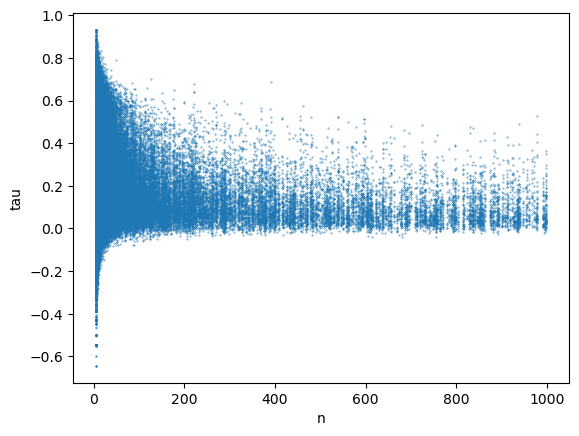

In [ ]:
x.query("n<1000").plot.scatter(x="n", y="tau", s=0.1)
print(np.max(x.query("tau<-.1").n), np.max(x.query("n<30 & tau<-.1").n))

In [ ]:
print(figdir)

/N/project/phyloML/rate_timescaling/figures


In [ ]:
eps = 0.08

x_grid = np.linspace(-1 + eps, 1 - eps, 100)

plt.plot(x_grid, rolling_mae(x_grid, var="rho"), "r")
# plt.plot(x_grid, rolling_mae(x_grid, var='rho',limits=[w_lim,1-w_lim]),'b')

plt.xlabel(r"$\rho$")
plt.ylabel(r"MAE")
print(d, rmse, mae)

In [ ]:
eps = 10

x_grid = np.linspace(4 + eps, 2000 - eps, 100)
plt.plot(x_grid, rolling_mae(x_grid, var="n"), "r")
plt.plot(x_grid, rolling_mae(x_grid, var="n", limits=[w_lim, 1 - w_lim]), "k")
plt.xlabel(r"$n$")
plt.ylabel(r"MAE")
print(d, rmse, mae)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/N/project/phyloML/app/Quartz/miniconda3/envs/p311/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3672, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_725126/2867265537.py", line 4, in <module>
    plt.plot(x_grid, rolling_mae(x_grid, var="n"), "r")
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: rolling_mae() missing 1 required positional argument: 'x'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/N/project/phyloML/app/Quartz/miniconda3/envs/p311/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2178, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/N/project/phyloML/app/Quartz/miniconda3/envs/p311/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1182, in structured_traceback
    return Format

In [ ]:
eps = 0.08

x_grid = np.linspace(-1 + eps, 1 - eps, 100)

x["deviation"] = x.sigma - 1
ax1 = x.plot.scatter(x="rho", y="sigma", s=0.5)
ax1.set_ylim(bottom=0)
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\hat{\sigma}^2$")
print(x.sigma.min())

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# ax2.plot(x_grid, rolling_mae(x_grid, var='rho'),'r')
# ax2.plot(x_grid, rolling_mae(x_grid, var='rho',limits=[w_lim,1-w_lim]),'k')
# # plt.xlabel(r'$\$')
# ax2.set_ylim(ax1.get_ylim())#0,5)
# ax2.set_ylabel(r'MAE');
print(d, rmse, mae)
plt.savefig(figdir / "pic_rhoplot_all.png")

In [ ]:
x.plot.scatter(x="n", y="sigma", s=0.5)
plt.xlabel("n")
plt.ylabel(r"$\hat{\sigma}^2$")
plt.savefig(figdir / "pic_nplot_all.png")

In [ ]:
x.reset_index().plot.scatter(x="h", y="sigma", s=0.5)
plt.xlabel("h")
plt.ylabel(r"$\hat{\sigma}^2$")
plt.savefig(figdir / "pic_nplot_all.png")

In [ ]:
x_ils = pd.DataFrame(
    {
        "taus": taus[: len(s_ils), :max_rep].ravel(),
        "sigs_ils": np.array(s_ils).ravel() / ngenes,
    }
)  # must normalize by ngenes
x_ils.plot.scatter(x="taus", y="sigs_ils")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\hat{\sigma}^2$")
rmse = np.sqrt(((x_ils.sigs_ils - 1) ** 2).mean())
print(d, rmse)

# Find areas where PIC fails

In [96]:
y_vars = [ "sigma_ape", "sigma_geig", "sigma", "sigma_paired", "sigma_cherry", "sigma_js", ]
    
x_high_error = x[x.sigma>3]
x_low_error = x.query('.6 < sigma < 1.4')

# .describe()

x.columns, xlabels, (x_high_error[y_vars].mean(), x_low_error[y_vars].mean())
print(x_high_error[xlabels.keys()].mean(), '\n---\n' ,x_low_error[xlabels.keys()].mean() )
x['sigma_mae'] = (1-x.sigma).abs()
print(x.corr('spearman')['sigma_mae'].sort_values())

bl_min            0.154842
bl_max            2.379735
bl_median         0.583458
bl_q1             0.229782
bl_q3             1.328205
tau               0.287557
rho               0.393991
lam               4.023810
mu                3.548214
lam_minus_mu      0.475595
mu_over_lam       0.826190
h_lam_minus_mu    0.975595
h_mu_over_lam     2.419048
dtype: float64 
---
 bl_min            0.022508
bl_max            2.520917
bl_median         0.211373
bl_q1             0.085235
bl_q3             0.516417
tau               0.223056
rho              -0.119748
lam               5.450323
mu                4.707913
lam_minus_mu      0.742409
mu_over_lam       0.838593
h_lam_minus_mu    2.138471
h_mu_over_lam     3.161155
dtype: float64
n                -0.625885
sigma_ape        -0.539856
sigma_geig       -0.537903
h_lam_minus_mu   -0.432096
h                -0.271572
h_mu_over_lam    -0.236436
idx              -0.168613
lam_minus_mu     -0.167905
bl_max           -0.156509
lam              -0

# Fit model for MAE, compare features

In [3]:
import xgboost as xgb
import sklearn

params = {
    'objective': 'reg:squarederror', # Objective function for regression (squared error)
    'n_estimators': 100,             # Number of boosting rounds (trees)
    'learning_rate': 0.1,            # Step size shrinkage to prevent overfitting
    'max_depth': 5,                  # Maximum depth of a tree
    'subsample': 0.8,                # Subsample ratio of the training instance
    'colsample_bytree': 0.8,         # Subsample ratio of columns when constructing each tree
    'random_state': 42,              # Seed for reproducibility
    'n_jobs': 16                     # Use all available CPU cores
}

# Initialize the XGBoost Regressor model
print("\nInitializing XGBoost Regressor...")
models={}
estimators = ['sigma','sigma_cherry','sigma_paired']
x=x.dropna()
X_train = x.drop(columns=estimators)


for var in estimators:
    model = xgb.XGBRegressor(**params)
    y_train = (x[var]-1).abs()
    # Train the model on the training data
    print("Training the model...")
    model.fit(X_train, y_train)
    print("Model training complete.")

    # XGBoost provides a way to get feature importance
    print("\nFeature Importances (fscore):")
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(feature_importances)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances.values, y=feature_importances.index)
    plt.title(var)
    models[var] = model

ModuleNotFoundError: No module named 'xgboost'

### Plot geiger results

In [2]:
sig_geiger = pd.read_csv(
    "/N/project/phyloML/rate_timescaling/data/tree_sims/geiger_res_no_ils.csv.gz"
)
sig_geiger.rename(columns={"sigmas": "sigma", "taus": "tau"}, inplace=True)
# sig_geiger.to_csv('/N/project/phyloML/rate_timescaling/data/tree_sims/geiger_res_no_ils_long.csv.gz')
sig_geiger.describe()

/tmp/ipykernel_3515666/2117441122.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  sig_geiger = pd.read_csv(


,value,sigma,lam,mu,h,bl_corr,n,tau,r,rho
count,732030.000000,1.195195e+06,1.195240e+06,1.195240e+06,1.195240e+06,1.194580e+06,1.195240e+06,1.195240e+06,1.195240e+06,1.195240e+06
mean,109.723577,2.133958e+12,6.203097e+00,4.788272e+00,4.003146e+00,-9.283054e-02,5.633734e+02,1.923555e-01,1.414825e+00,7.790385e-01
std,232.034068,4.975039e+14,3.475450e+00,2.948132e+00,2.102593e+00,3.442242e-01,8.056780e+02,1.975279e-01,1.784581e+00,1.893505e-01
min,-52.108390,1.915170e-174,5.000000e-01,3.000000e-01,1.000000e+00,-1.000000e+00,4.000000e+00,-6.445034e-01,2.500000e-02,3.000000e-01
25%,30.000000,6.634616e-17,3.000000e+00,2.400000e+00,3.000000e+00,-3.103170e-01,1.500000e+01,5.694971e-02,4.000000e-01,7.000000e-01
50%,50.000000,1.459615e+00,5.500000e+00,4.275000e+00,5.000000e+00,-1.838240e-01,7.100000e+01,1.379030e-01,7.500000e-01,8.500000e-01
75%,50.000000,9.708059e+01,9.000000e+00,6.500000e+00,5.000000e+00,-8.179690e-03,9.830000e+02,2.908367e-01,1.500000e+00,9.000000e-01
max,900.000000,2.233247e+17,1.300000e+01,1.187500e+01,7.000000e+00,1.000000e+00,2.000000e+03,9.545214e-01,9.100000e+00,9.500000e-01


In [ ]:
sig_geiger_ils = pd.read_csv(
    "/N/project/phyloML/rate_timescaling/data/tree_sims/geiger_res_ils.csv.gz"
)
sig_geiger_ils.rename(columns={"sigmas": "sigma", "taus": "tau"}, inplace=True)
# sig_geiger.to_csv('/N/project/phyloML/rate_timescaling/data/tree_sims/geiger_res_no_ils_long.csv.gz')
for name, g in sig_geiger_ils.groupby("model"):
    print(name, g.describe())

In [ ]:
for ils, df in zip((True, False), (sig_geiger_ils, sig_geiger)):
    for var in ["tau", "bl_corr", "n"]:
        for model in ["BM", "EB", "rate_trend", "delta"]:
            query = ""  # 1000>n>20 &'
            eps = 25 if var == "n" else 0.075
            res = rolling_mae(
                eps,
                df.query(f'{query} model=="{model}"'),
                pred="sigma",
                # limits = (w_lim,1-w_lim),
                var=var,
            )
            ax = plt.subplot(1, 1, 1)
            plt.plot(*res, label=model, c="r")
            ax.set_yscale("log")
            if var in ["lambda", "rho", "mu", "tau"]:
                plt.xlabel(rf"$\{var}$")
            else:
                plt.xlabel(var)
            plt.grid(visible=True)
            plt.ylabel(r"$|\hat{\sigma}^2_0 - \sigma^2|$")
            plt.title(r"Absolute Error")
            gtau, gsig = df.query(f'model=="{model}"')[[var, "sigma"]].values.T
            gsig = np.abs(gsig - 1)
            ax.scatter(gtau, gsig, s=0.1)
            plt.savefig(
                figdir
                / f"mae_geiger_{var}_{model}_{query}{'_ils' if ils else ''}_log.png"
            )
            plt.close()


In [ ]:
w_lim = 0.02

critical_values = {"EB": 0, "rate_trend": 0, "delta": 1}
# margin = .5
for ils, df in zip((True, False), (sig_geiger_ils, sig_geiger)):
    for var in ["tau", "bl_corr", "rho", "h", "n"]:
        ax = plt.subplot(1, 1, 1)
        for model, label in zip(
            ["BM", "EB", "rate_trend", "delta"], ["BM", "ACDC", "LT", r"$\Delta$"]
        ):
            # if model=='delta':continue
            query = "2000>n> 20 &"  # 2000>n>20 &'
            # if model!='BM':
            #     query+= f'value > {critical_values[model]+margin} &'
            eps = 25 if var == "n" else 0.075
            res = rolling_mae(
                eps,
                df.query(f'{query} model=="{model}"'),
                pred="sigma",
                # limits = (w_lim,1-w_lim),
                var=var,
            )
            plt.plot(*res, label=label)  # , c='r')
        ax.set_yscale("log")
        if var in ["lambda", "rho", "mu", "tau"]:
            plt.xlabel(rf"$\{var}$")
        else:
            plt.xlabel(var)
        plt.grid(visible=True)
        plt.ylabel("MAE")
        # plt.ylabel(r'$|\hat{\sigma}^2_0 - \sigma^2|$');
        plt.title(r"Absolute Error")
        plt.legend()
        # gtau,gsig = sig_geiger.query(f'model=="{model}"')[[var,'sigma']].values.T
        # gsig=np.abs(gsig-1)
        # ax.scatter(gtau,gsig, s=.1)
        plt.savefig(figdir / f"mae_geiger_{var}_{query}{'_ils' if ils else ''}_log.png")
        plt.close()


In [ ]:
print(critical_values)
sig_geiger["I"] = sig_geiger.apply(
    lambda df: df["value"] > df[critical_values[model]], axis=1
)

In [ ]:
delta = sig_geiger.query('model=="delta"')[["value", "sigma"]]
fig = plt.figure()
ax1 = plt.subplot(1, 2, 1)
delta.query("value<1").plot.scatter(x="value", y="sigma", c="k", ax=ax1, s=0.1)
ax1.set_ylabel(r"$\hat{\sigma}_0^2$")
plt.loglog()
ax1.set_xlabel("")

ax = plt.subplot(1, 2, 2)
delta.query("value> 1").plot.scatter(
    x="value", y="sigma", c="k", ax=ax, s=0.8, sharey=ax1
)
ax.set_xlabel("")
ax.set_ylabel("")
print(delta.query("10>value> 1 & 1e4>sigma>1").mean())
ax.hlines(1, 0, 30, lw=1, colors="r")
ax1.hlines(1, 0, 30, lw=1, colors="r")
# print(sig_geiger.query('model=="delta"').max())
plt.loglog()
fig.text(0.5, 0.02, r"$\delta$", ha="center", va="center")
# fig.tight_
plt.tight_layout()
plt.savefig(figdir / f"delta_vs_sig_log.png")


In [ ]:
sns.relplot(
    data=sig_geiger.query('model!="BM"'),
    hue="model",
    x="value",
    y="sigma",
    kind="scatter",
    col="I",
)
# for model, label in zip(['BM','EB','rate_trend','delta'], ['BM','ACDC','LT', r'$\Delta$']):
#     # if model=='delta':continue
#     # if model!='BM':
#     #     query+= f'value > {critical_values[model]+margin} &'
#     sig_geiger.plot(x='value', y='sigma', label = label)#, c='r')
ax.set_yscale("log")
# plt.xlabel(r'$\theta$')
# plt.grid(visible=True)
# plt.ylabel(r'$\hat{\sigma}^2_0$');
# # plt.ylabel(r'$|\hat{\sigma}^2_0 - \sigma^2|$');
# plt.title(r'Absolute Error');
# plt.legend()
# gtau,gsig = sig_geiger.query(f'model=="{model}"')[[var,'sigma']].values.T
# gsig=np.abs(gsig-1)
# ax.scatter(gtau,gsig, s=.1)
plt.savefig(figdir / f"sig_vs_rate_param_log.png")

In [ ]:
sig_geiger.query('model=="delta" & sigma>1000').describe()

In [ ]:
sig_geiger.query('model=="delta"')

In [ ]:
y = sig_geiger.reset_index()

y["r"] = y.lam - y.mu
query = 'model=="EB"'  # n>500'
if query:
    y = y.query(query)
y.plot.scatter(x="rho", y="tau", s=0.1)
y.corr(method="spearman")

# sns.pairplot(data = y);

## BD Tree statistics
Calculate Spearman's $\rho$(branch_length, depth) for all trees, then tree-wide branch length stats

In [ ]:
def process_dir(d):
    outfile = d / "rhos.npy"
    infile = d / "parent_trees_4plus.phy"
    if infile.exists() and not outfile.exists():
        with open(infile, "r") as f:
            trees = [
                dendropy.Tree.get_from_string(t, "newick", rooting="force-rooted")
                for t in f
            ]
        c = np.empty((len(trees), 2))
        for j, t in enumerate(trees):
            taxa = len(t)
            x = get_branch_lengths_and_heights(t)
            c[j, 0] = stats.spearmanr(x, axis=1).correlation
            c[j, 1] = taxa
        np.save(outfile, c)



with Parallel(njobs) as parallel:
    parallel(
        delayed(process_dir)(d)
        for h in (7, 1, 3, 5)
        for d in parent_dir.glob(f"*/*/h{h}")
    )


In [ ]:
def process_dir(d):
    outfile = d / "BL_stats.csv.gz"
    infile = d / "parent_trees_4plus.phy"
    results=[]
    
    if infile.exists() and not outfile.exists():
        with open(infile, "r") as f:
            for t in f:
                t = dendropy.Tree.get_from_string(t, "newick", rooting="force-rooted")
                res = get_bl_stats(t)
                results.append(res)
        results = pd.DataFrame(results)
        results.to_csv(outfile)

print(parent_dir)
with Parallel(njobs) as parallel:
    parallel(
        delayed(process_dir)(d)
        for h in (7, 1, 3, 5)
        for d in parent_dir.glob(f"tree_sims/*/*/h{h}")
    )


/N/project/phyloML/rate_timescaling/data


## Other simulators
msprime works only on Quartz, with gsl loaded. Otherwise msprime and ipcoal don't work due to dependency conflicts.

In [ ]:
! module load gsl
import msprime

# reload(msprime)
import subprocess


def infer_tree(
    parent_tree, Ne=10000, rec_rate=1e-8, mut_rate=2e-7, seq_len=500_000, seed=5678
):
    demo = msprime.Demography.from_species_tree(
        parent_tree.as_string("newick").replace("[&R]", "").strip(),
        time_units="yr",
        generation_time=1 / Ne,
        initial_size=Ne,
    )
    ts = msprime.sim_ancestry(
        samples={i: 1 for i in range(demo.num_populations)},
        sequence_length=seq_len,
        recombination_rate=rec_rate,
        demography=demo,
    )

    ts = msprime.sim_mutations(ts, rate=mut_rate, random_seed=seed)

    tmpdir = Path("/tmp")
    prefix = tmpdir / "".join(random.choices(string.ascii_uppercase, k=10))
    print(f"using temp dir {tmpdir}, prefix {prefix}")
    ifile = prefix.with_suffix(".fasta")
    try:
        ts.write_fasta(ifile)

        raxml_cline = f"""raxml-ng --msa {ifile} --prefix {prefix}  \
                             --model GTR+G --msa-format FASTA \
                                            --workers 4 --threads 4 > /dev/null"""
        p1 = subprocess.Popen(raxml_cline, shell=True, executable="/bin/bash")
        p1.wait()
        with open(prefix.with_suffix(".raxml.bestTree"), "r") as f:
            inferred_tree = dendropy.Tree.get_from_string(f.read(), "newick")

        return inferred_tree
    finally:
        ifile.unlink()
        for fn in prefix.glob("*"):
            fn.unlink()

In [ ]:
for t in parent_trees:
    itree = infer_tree(t)
    with open(data_dir / "inferred_trees.phy", "a") as f:
        f.write(itree.as_string("newick") + "\n")

In [ ]:
Ne = 10000
# parent_tree.scale_edges(Ne)
parent_tree = parent_trees[0]
ts = msprime.sim_ancestry(
    samples={i: 1 for i in range(demo.num_populations)},
    sequence_length=500_000,
    recombination_rate=1e-8,
    demography=demo,
)
# mts = msprime.sim_mutations(ts, rate=0.01, random_seed=5678)
ts

In [ ]:
mts = msprime.sim_mutations(ts, rate=2e-7, random_seed=5678)
mts

In [ ]:
from Bio.Phylo.Applications import RaxmlCommandline
from tempfile import TemporaryDirectory, TemporaryFile
import subprocess

# with TemporaryDirectory() as tdir:
ifile = "tmp.input.fasta"

mts.write_fasta(ifile)

raxml_cline = f"""raxml-ng --msa {ifile} --prefix T1  \
                     --model GTR+G --msa-format FASTA \
                                    --workers 4 --threads 4"""
subprocess.Popen(raxml_cline, shell=True, executable="/bin/bash")
# os.remove(ifile)
with open("T1.raxml.bestTree", "r") as f:
    inferred_tree = dendropy.Tree.get_from_string(f.read(), "newick")


In [ ]:
import ipcoal
import toytree

t = toytree.rtree.bdtree(b=lam, d=mu, time=tree_height)
unlinked = ipcoal.Model(tree=t, Ne=1e5, seed=1234)
unlinked.sim_trees(nloci=10, nsites=1)

In [ ]:
# taxon set association
genes_to_species = dendropy.TaxonNamespaceMapping.create_contained_taxon_mapping(
    containing_taxon_namespace=containing_taxa, num_contained=1
)

# Ne=10000
# stepwise_tree.scale_edges(Ne)
# convert to containing tree
stepwise_tree = reconcile.ContainingTree(
    parent_tree,
    contained_taxon_namespace=genes_to_species.domain_taxon_namespace,
    contained_to_containing_taxon_map=genes_to_species,
)
stepwise_tree.build_edge_taxa_sets()
num_reps = 10

# for each rep
for rep in range(num_reps):
    stepwise_tree.embed_contained_kingman()


In [ ]:
! ls